# Batch Spectroscopy File Parsing Script

### Author: Vinicio Soto, CICIMA
### This script works with raw Lambdas1050's ASC files in batch. It corrects Lambdas1050's detector jump between 857 nm and 858 nm and performs a Savitzky-Golay filtering on the corrected data

#### exclusion_list.txt: You can add a file with this name to the folder with the data to exclude any file with that name

This script reads every l1050 file in folder and its subfolders and create a unique average, jump_corrected_files, report and std_dev folders
It creates sections for each folder with its information


### Dependencies

In [1]:
import pandas as pd #Data analysis
import numpy as np  #Array and numeric methods
from matplotlib.backends.backend_pdf import PdfPages #pri*nt PDFS
import matplotlib #pri*nt graphs
import matplotlib.pyplot as plt #pri*nt graphs
import os #operating system
import re #regular expression manipulation
from datetime import datetime #date and time methods
import logging #to log errors

#import spectraltools
#This script requires the file spectraltools.py to work
import sys
# Add the external folder to the system path
current_dir = os.getcwd()
external_folder_path = os.path.abspath(os.path.join(current_dir, '../libraries'))
sys.path.append(external_folder_path)

#This line of code allow us to access data in colab
#functionality to reload modules

import importlib
import spectraltools
import metrics
import datapath_selector

# clear the import cache
importlib.reload(metrics)
importlib.reload(spectraltools)
importlib.reload(datapath_selector)
# now you can import my_class and it'll be updated
from metrics import *
from spectraltools import *
from datapath_selector import get_paths
from pathlib import Path


### Instructions:

Write your archive folders' path in file_folder_data_path list

In [2]:
#parent folder path
date = str(datetime.today().date())

#file_folder_data_path =[ #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\DORSAL",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\VENTRAL",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-03-REFLECTANCE\without iris nor lens",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\2024-04-INBUCR-REFLECTANCE",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\2023-03-CICIMAUCR-2-REFLECTANCE",
                         #r"C:\Users\esteb\cicima\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\DORSAL"
                       #]
parent_folder_data_path = Path(r"../test/data/test_step_jump_correction/files") 

#create a subfolder called report with the correction process info  
report_path = ((parent_folder_data_path.parent / "reports" )/ f"{date}") / (parent_folder_data_path.name)
#pri*nt(report_path)
report_path.mkdir(parents=True, exist_ok=True)

#create a subfolder called corrected_files
corrected_files_path = ((parent_folder_data_path.parent / f"corrected_files_{date}" )/ f"{date}") / parent_folder_data_path.name
#pri*nt(corrected_files_path)
corrected_files_path.mkdir(parents=True, exist_ok=True)

#create a subfolder called average and std

average_files_path = ((parent_folder_data_path.parent / f"average" )/ f"{date}") / parent_folder_data_path.name
#pri*nt(average_files_path)
average_files_path.mkdir(parents=True, exist_ok=True)

std_files_path = ((parent_folder_data_path.parent / f"std" )/ f"{date}") / parent_folder_data_path.name
#pri*nt(std_files_path)
std_files_path.mkdir(parents=True, exist_ok=True)



#### Collections

In [3]:
"""OPTIONS: cicima_laptop, colaboratory, wfh, cicima_desktop
    """
collection_paths = get_paths()
#pri*nt(collection_paths)

inbio_2018_2019_collection = Specimen_Collection("INBIO", collection_paths["2018_2019_inbio_collection_path"] , collection_paths["2018_2019_inbio_collection_metadata"] , "HIGH")
angsol_collection = Specimen_Collection("ANGSOL", collection_paths["angsol_collection_path"] , collection_paths["angsol_collection_metadata"] , "HIGH")
angsol_collection.set_description("ANGSOL collection has specimens that belong to Angel Solís. The confidence that we have about specimen identification is high.")

cicimaucr_collection = Specimen_Collection("CICIMAUCR1", collection_paths["cicimaucr_collection_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
cicimaucr_collection_2 = Specimen_Collection("CICIMAUCR2", collection_paths["cicimaucr_collection_2_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
cicimaucr_collection_3 = Specimen_Collection("CICIMAUCR3", collection_paths["cicimaucr_collection_3_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
inbucr_collection = Specimen_Collection("INBUCR", collection_paths["inbucr_collection_path"] , collection_paths["inbucr_metadata"] , "HIGH")
bioucr_collection = Specimen_Collection("BIOUCR", collection_paths["bioucr_collection_path"] , collection_paths["bioucr_metadata"] , "LOW")

collection_list = [
                    inbio_2018_2019_collection,
                    angsol_collection,
                    cicimaucr_collection,
                    cicimaucr_collection_2,
                    cicimaucr_collection_3,
                    inbucr_collection,
                    bioucr_collection,
                    ]
#pri*nt(collection_list)

### Constants
Define your constants

In [4]:
#determine 
markersize = 1
#date


correction_file_path = Path(r"..\test\data\test_step_jump_correction\corrections\aluminum_mirror_reflectance.txt")
correction_df = pd.read_csv(correction_file_path, sep="\t",decimal=",", names = ["wavelength","reflectance"], skiprows=1)
correction_df

def integer_generator(start=0):
    if(start%100==0):
        print(f"{start=}")
    while True:
        yield start
        start += 1
gen = integer_generator()

### Functions

#### Check if it is a L1050 file or a CRAIC file

### Correction process function

In [5]:
def jump_correction(Spectrum):
    """Receives a l1050 spectrum and corrects its detector jump"""
    metadata = Spectrum.get_metadata()
    df = Spectrum.get_dataframe()
    
    #measuring_mode
    measuring_mode = metadata["measuring_mode"]
    
    #convert columns to float
    df['wavelength'] = df['wavelength'].astype(float)
    df[measuring_mode] = df[measuring_mode].astype(float)
    

    #This code finds the rows before and after the detector change
    #freq1 is the frequency before the change and freq2 is the frequency after the change
    wavelenght1 = 857.000000 #857
    wavelenght2 = 858.000000 #858
    
    #pri*nt("Loc")
    row1 = df.loc[ df['wavelength'] == wavelenght1]
    row2 = df.loc[ df['wavelength'] == wavelenght2]
    row12 = df.loc[ df['wavelength'] == wavelenght1-1]
    row13 = df.loc[ df['wavelength'] == wavelenght1-2]
    row14 = df.loc[ df['wavelength'] == wavelenght1-3]
    row15 = df.loc[ df['wavelength'] == wavelenght1-4]
    
    #This code finds the values corresponding to those frequencies and creates a correction factor
    
    try:
        data1 = row1.iat[0,1]
        data2 = row2.iat[0,1]
        data22 = row12.iat[0,1]
        data23 = row13.iat[0,1]
        data24 = row14.iat[0,1]
        data25 = row15.iat[0,1]
    
        data1_avg = (data1 + data22+data23)/3 #+data24+data25)/5
        data2_avg = (data2)
        correction_factor= data1_avg/data2_avg  
    
        #Multiply all frequencies equal or greater than freq2 by correction_factor
        df2 = df
        df2.loc[df2["wavelength"] >= wavelenght2 , [measuring_mode]] *= correction_factor
        
        
        return df
    except Exception as e:
        
        #pri*nt(e)
        return pd.DataFrame([])
    
    

### Define Savitzky-Golay Filter

In [6]:
from scipy.signal import savgol_filter

def savitzky_golay_filter(metadata, df) -> pd.DataFrame:
    """Defines a Savitzky Golay Filter: Basically, smooths out the function. https://es.wikipedia.org/wiki/Filtro_de_Savitzky%E2%80%93Golay"""
    measuring_mode = metadata["measuring_mode"]
    y = df[measuring_mode] = df[measuring_mode].astype(float)
    
    # Apply Savitzky-Golay filter
    window_length = 21  # Window length (odd number)
    polyorder = 2  # Polynomial order
    y_smooth = savgol_filter(y, window_length, polyorder)
    
    #create new dataframe
    df_smooth = pd.DataFrame([])
    df_smooth["wavelength"] =df["wavelength"]
    df_smooth[measuring_mode] = y_smooth
    
    return df_smooth
    

### Define function that filters selected extensions

In [7]:
def list_all_filepaths(parent_folder):
    filepaths = []
    
    # Walk through the directory
    for root, dirs, files in os.walk(parent_folder):
        for file in files:
            # Combine the root directory with the file name to get the full path
            filepath = os.path.join(root, file)
            filepaths.append(filepath)
    
    return filepaths
file_list = list_all_filepaths(parent_folder_data_path)
#pri*nt(f"{file_list=}")

In [8]:
def get_exclusion_list(file_list):
        """Only files whose name is in the exclusion list"""
        #file extension
        file_extension = "exclusion_list"
    
        # filters a list of strings to create a new list containing only the elements that have exclusion_list"
    
        def filter_substring_elements(path_strings, substring):
            filtered_paths = [path for path in path_strings if substring in path]
            return filtered_paths
    
        # Filter elements
        filtered_list = filter_substring_elements(file_list, file_extension)
    
        # Displaying the filtered list
        #pri*nt(filtered_list)
        
        return filtered_list
exclusion_list = get_exclusion_list(file_list)
#pri*nt(f"{exclusion_list=}")

In [9]:
def filter_list_CRAIC_and_l1050(path_list):
    """Only l1050 files and CRAIC files are read"""
    filtered_list = []

    filtered_list += [path for path in path_list if (check_CRAIC_file(path) or check_l1050_file(path))]

    return filtered_list

filtered_list = filter_list_CRAIC_and_l1050(file_list)

#pri*nt(f"{filtered_list=}")

In [10]:
def filter_failed_runs(filtered_list):
    """Filter runs that failed"""
    #file extension
    fail_strings = ["fail"]

    # filters a list of strings to create a new list containing only the elements that end with ".ASC"

    def filter_substring_elements(path_strings, substring):
        filtered_paths = [path for path in path_strings if substring not in path]
        return filtered_paths

    # Filtering elements with any of the fail strings
    for string in fail_strings: 
        filtered_list = filter_substring_elements(filtered_list, string)

    # Displaying the filtered list
    #pri*nt(filtered_list)
    
    return filtered_list

successful_list = filter_failed_runs(filtered_list)
#pri*nt(f"{successful_list=}")

### Logic: Remove jumps

In [11]:
# From this list we will make a set of codes.
#pri*nt(filenames)
 
codes = []
for path in successful_list:
    code = get_code_from_filename(path)
    if code: 
        codes.append(code)
codes = set(codes)
codes = sorted(codes)

#pri*nt(f"codes {codes}")

In [12]:
#for each file in the exclusion list
exclusion_list_df = pd.DataFrame()
for file in exclusion_list:
    df = pd.read_csv(file, header = 0, names=["filename", "reason"], delimiter = "\t")
    exclusion_list_df = pd.concat([exclusion_list_df, df], ignore_index = True)
#pri*nt(exclusion_list_df)
#pri*nt(f"{exclusion_list_df=}")

In [13]:
#remove excluded files
def remove_excluded_files(successful_list, exclusion_list_df):
    filtered_list = []

    #if the file is not empty it gets all files that are not in that list
    if not exclusion_list_df.empty:
        #gets a exclusion list
        exclusion_list = exclusion_list_df["filename"].values
        for excluded_file in exclusion_list:
                    filtered_list = [filename for filename in successful_list if excluded_file not in filename ]
    filtered_list = successful_list
    return filtered_list
    
successful_list_without_excluded_files = remove_excluded_files(successful_list, exclusion_list_df)
#pri*nt(f"{successful_list_without_excluded_files=}")

In [14]:
def remove_empty_files(successful_list_without_excluded_files):
    non_empty_files = [filename for filename in successful_list_without_excluded_files if ((not check_empty_CRAIC_file(filename)) and (not check_empty_l1050_file(filename)))]
    return non_empty_files

non_empty_files = remove_empty_files(successful_list_without_excluded_files)
#non_empty_files

In [15]:
def save_corrected_plot(folder, basename, metadata, dataframe, label = None):
    """
    Saves the dataframe into a file
    Inputs: A dataframe, the filename of the file from which the dataframe comes from and its metadata
    Output: None
    
    """
    #
    #pri*nt(f"save_corrected_df: {folder=}")
    #pri*nt(f"save_corrected_df: {basename=}")
    #pri*nt(f"save_corrected_df: {metadata=}")
    #pri*nt(f"save_corrected_df: {dataframe=}")
    
    plt.plot(dataframe["wavelength"], dataframe[metadata["measuring_mode"]], label = label, color= get_contrasting_color())
    

In [16]:
def save_corrected_df(folder, basename, metadata, dataframe):
    """
    Saves the dataframe into a file
    Inputs: A dataframe, the filename of the file from which the dataframe comes from and its metadata
    Output: None
    
    """
    #
    #pri*nt(f"save_corrected_df: {folder=}")
    #pri*nt(f"save_corrected_df: {basename=}")
    #pri*nt(f"save_corrected_df: {metadata=}")
    #pri*nt(f"save_corrected_df: {dataframe=}")
    
    #get only wavelength and metadata["measuring_mode"]
    dataframe = dataframe[["wavelength", metadata["measuring_mode"]]]
    #variables
    header = metadata["header"]
    
    #convert dataframe to numpy
    my_numpy_df_data = dataframe.to_numpy()

    #create folder
    if not os.path.exists(folder):
        os.mkdir(folder)

    #saves file, removes .ASC and removes .SAMPLE
    unnecessary_text = [".Sample", ".Cycle1"]
    replace_text = basename
    
    for text in unnecessary_text:
        #pri*nt(temp_text)
        replace_text = replace_text.replace(text, "")

    #new_archive_name
    new_archive_name = folder / replace_text

    #saves info
    with open(new_archive_name, 'wb') as f:
        np.savetxt(new_archive_name, my_numpy_df_data,fmt = "%.6f", delimiter="\t", header=header, comments='', )
    with open(new_archive_name, "r") as f:
        data = f.read()
    with open(new_archive_name, "w") as f:
        f.write(data.replace("#DATA\n","#DATA"))

In [17]:
def save_corrected_CRAIC_spectrum(pdf, code, spectrum, folder):
    """
    Saves the dataframe into a file
    Inputs: A dataframe, the filename of the file from which the dataframe comes from and its metadata
    Output: None
    
    """
    df, filename,metadata = spectrum.get_dataframe(), spectrum.get_filename(), spectrum.get_metadata()
    #variables
    header = metadata["header"]
    
    #convert dataframe to numpy
    my_numpy_df_data = df.to_numpy()
    
    #get basename
    basename = code + ".csv"

    if not os.path.exists(folder):
        os.mkdir(folder)

    #new_archive_name
    new_archive_name = folder / basename

    #saves info
    with open(new_archive_name, 'wb') as f:
        np.savetxt(new_archive_name, my_numpy_df_data,fmt = "%.6f", delimiter="\t", header=header, comments='', )


In [18]:
def save_corrected_l1050_spectrum(pdf, code, spectrum, folder):
    """
    Saves the dataframe into a file
    Inputs: A dataframe, the filename of the file from which the dataframe comes from and its metadata
    Output: None
    """
    df, filename,metadata = spectrum.get_dataframe(), spectrum.get_filename(), spectrum.get_metadata()
    #variables
    header = metadata["header"]
    
    #convert dataframe to numpy
    my_numpy_df_data = df.to_numpy()
    
    #get basename
    basename = code + ".csv"

    if not os.path.exists(corrected_path):
        os.mkdir(corrected_path)

    #new_archive_name
    new_archive_name = folder / basename

    #saves info
    with open(new_archive_name, 'wb') as f:
        np.savetxt(new_archive_name, my_numpy_df_data,fmt = "%.6f", delimiter="\t", header=header, comments='', )
    with open(new_archive_name, "r") as f:
        data = f.read()
    with open(new_archive_name, "w") as f:
        f.write(data.replace("#DATA\n","#DATA"))

In [19]:
def save_corrected_spectrum(pdf, code, spectrum, folder):
    """
    Saves the dataframe into a file
    Inputs: A dataframe, the filename of the file from which the dataframe comes from and its metadata
    Output: None
    
    """
    df, filename,metadata = spectrum.get_dataframe(), spectrum.get_filename(), spectrum.get_metadata()
    #variables
    header = metadata["header"]
    
    #convert dataframe to numpy
    my_numpy_df_data = df.to_numpy()
    
    #Create new folder to save the corrected dataframes
    corrected_path = Path(parent_folder_data_path)
    
    #get basename
    basename = Path(filename).name

    if not os.path.exists(corrected_path):
        os.mkdir(corrected_path)

    #saves file, removes .ASC and removes .SAMPLE
    unnecessary_text = [".Sample", ".Cycle1"]
    temp_text = basename
    
    for text in unnecessary_text:
        #pri*nt(temp_text)
        temp_text = temp_text.replace(text, "")

    #new_archive_name
    new_archive_name = corrected_path / temp_text

    #saves info
    with open(new_archive_name, 'wb') as f:
        np.savetxt(new_archive_name, my_numpy_df_data,fmt = "%.6f", delimiter="\t", header=header, comments='', )
    with open(new_archive_name, "r") as f:
        data = f.read()
    with open(new_archive_name, "w") as f:
        f.write(data.replace("#DATA\n","#DATA"))

In [20]:
def plot_corrected_spectrum(pdf, code, spectrum, folder, label = None):
    """
    Saves the dataframe into a file
    Inputs: A dataframe, the filename of the file from which the dataframe comes from and its metadata
    Output: None
    
    """
    df, filename,metadata = spectrum.get_dataframe(), spectrum.get_filename(), spectrum.get_metadata()
    equipment = metadata["equipment"]
    polarization = metadata["polarization"]
    genus = metadata["genus"]
    species = metadata["species"]
    species_text = species
    if species == "na":
        species_text = "sp."
    #creates a figure to plot 
    
    
    #plots
    #title = (f'1. Corrected {equipment} spectrum. Code: {code}. {genus} {species_text}. {polarization} pol.')
    
    plt.plot(df["wavelength"], df[metadata["measuring_mode"]], label = label, color= get_contrasting_color())
    #plt.show()
    #save figure
    


In [21]:
def get_label_and_color(spectrum, code_file_counter):
    metadata, df = spectrum.get_metadata(), spectrum.get_dataframe()
    filename = spectrum.get_filename()
    basename = Path(filename).name

    #After that we will average the spectra
    #create figure
    color = get_contrasting_color()
    #correct the label to only show the code 
    label_corrected = basename.replace(".csv", "").replace(".ASC", "").replace(".txt", "")

    return label_corrected, color

In [22]:
def l1050_get_corrected_dataframe_and_info(file, code, collection_list, code_file_counter):
                #create a spectrum object
                spectrum = create_spectrum_from_file(file, code, collection_list)
                label, color = get_label_and_color(spectrum, code_file_counter)
    
                #Fix jump correction
                
                df_corrected = jump_correction(spectrum)
                
                corrected_dict = {"df":df_corrected, "complete_path": file, "metadata": metadata, "code":code}

                return corrected_dict
                

In [23]:
def create_spectrum_from_file(file, code, collection_list):
            #pri*nt("Create spectrum from file")
            collection = Specimen_Collection.collection_lookup(code, collection_list)
            #pri*nt(f"{collection=}")
            #pri*nt(f"{file=}")
            spectrum = Spectrum(file, collection)
            
            #plt.figure()
            #spectrum.get_dataframe().plot()
            #plt.show()
            #pri*nt(f"{spectrum=}")
            return spectrum
    

In [46]:
def std_CRAIC_df(file_list, code, collection_list):
    #pri*nt(f"Average Craic")
    print(f"Suspicious code {code=}")
    spectra = []
    #create a spectrum for each file
    for file in file_list:
        try:
            
            spectrum = create_spectrum_from_file(file, code, collection_list)
            spectra.append(spectrum)
            #pri*nt(f"{spectra=}")
        except Exception as e: 
            pass
            #pri*nt(e)
    
    #initialize
    std_df = pd.DataFrame([])
    std_df["wavelength"] = []
    std_df["%R"] = []
    #get each dataframe
    dfs = [spectrum.get_dataframe() for spectrum in spectra]
    dfs = [df for df in dfs if not df.empty]
    #print(dfs)
    #average each dataframe
    if dfs:
        grouped_df = pd.concat(dfs).groupby('wavelength')
    std_df = grouped_df.std().reset_index()
    
    #return average dataframe
    return std_df

In [47]:
def average_CRAIC_df(file_list, code, collection_list):
    #pri*nt(f"Average Craic")
    print(f"Susp. {code}")
    spectra = []
    #create a spectrum for each file
    for file in file_list:
        try:
            spectrum = create_spectrum_from_file(file, code, collection_list)
            spectra.append(spectrum)
            #pri*nt(f"{spectra=}")
        except Exception as e: 
            
            print(e)
    #init average_df
    average_df = pd.DataFrame([])
    average_df["wavelength"] = []
    average_df["%R"] = []
    #get each dataframe
    #print(f"{spectra=}")
    dfs = [spectrum.get_dataframe() for spectrum in spectra]
    dfs = [df for df in dfs if not df.empty]
    #print(f"{dfs=}")
    #average each dataframe
    if dfs:
        grouped_df = pd.concat(dfs).groupby('wavelength')
        average_df = grouped_df.mean().reset_index()
    
    #return average dataframe
    return average_df

In [26]:
def CRAIC_get_average_polarizations(files_with_code, code):
    #pri*nt(f"{files_with_code=}")
    #pri*nt(f"{code=}")
    #get right and left polarization 
    right_pol= [file for file in files_with_code if "R" in Path(file).name ]
    left_pol= [file for file in files_with_code if "L" in Path(file).name ]
    #no_polarization = [file for file in files_with_code if "O" in Path(file).name]
    no_polarization_average_df = None
    #pri*nt(f"{right_pol=}")
    #pri*nt(f"{left_pol=}")
    #pri*nt(f"{no_polarization=}")
    #average each polarization
    #pri*nt("4. right average_CRAIC_df")
    right_average_df = average_CRAIC_df(right_pol, code, collection_list)
    right_average_df["%R"] = right_average_df["%R"] *0.5 #TODO spectral factor for filter correction  
    #pri*nt("4. left average_CRAIC_df")
    left_average_df = average_CRAIC_df(left_pol, code, collection_list)
    right_average_df["%R"] = right_average_df["%R"] *0.5 #TODO spectral factor for filter correction  
    #pri*nt(f"{right_average_df=}")
    #pri*nt(f"{left_average_df=}")
    return right_average_df, left_average_df, no_polarization_average_df

    

In [27]:
def CRAIC_get_dataframe_and_info(file, code, collection_list):
                #create a spectrum object
                spectrum = create_spectrum_from_file(file, code, collection_list)
                #no correction needed
                df_corrected = spectrum.get_dataframe()
                metadata = spectrum.get_metadata()
                corrected_dict = {"df":df_corrected, "complete_path": file, "metadata": metadata, "code":code}
    
                return corrected_dict
    

In [28]:
def plot_dataframe_before_changes(pdf, file, code, collection_list, code_file_counter):

    #create a spectrum object
    spectrum = create_spectrum_from_file(file, code, collection_list)
    label, color = get_label_and_color(spectrum, code_file_counter)
    
    #get df and metadata
    df = spectrum.get_dataframe()
    metadata = spectrum.get_metadata()
    species = spectrum.get_species()
    genus = spectrum.get_genus()
    polarization = spectrum.get_polarization()
    
    if species == "na":
        species_text = "sp."
    else:
        species_text = species
    
    #pri*nt(f"{species=}")
    #pri*nt(f"{genus=}")
    #creates a figure to plot 
    #plt.figure(figsize=(10, 4))
    
    #plots before changes
    plot_wavelength_intensity(metadata, df, kind = None, s=None, alpha = None, color = None, label = label)


In [29]:
def interpolate_mirror_reflectance(df):
    """real_reflectance = measured_reflectance/100*actual_reflectance"""
    df_copy = df.copy()

    #pri*nt(f"{df_copy =}")
    def actual_reflectance(wavelength):
        actual_reflectance = np.interp(wavelength, correction_df['wavelength'].astype(float), correction_df['reflectance'].astype(float))
        return actual_reflectance

    # Use the interpolation method
    df_copy["actual_reflectance"] = df["%R"].apply(actual_reflectance)
    #pri*nt(f"{df_copy["actual_reflectance"] =}")
    df_copy["%R"] = df["%R"] /100* df_copy["actual_reflectance"]
    #pri*nt(f"{df_copy["%R"]=}")
        
    return df_copy.drop("actual_reflectance", axis=1)

In [30]:
def CRAIC_get_total_average_dataframe(right_average_df, left_average_df):
    
    # Ensure the DataFrames have the same structure
    if right_average_df.shape != left_average_df.shape:
        raise ValueError("DataFrames must have the same shape to compute total averages.")
    
    # Calculate the total average DataFrame
    total_average_df = right_average_df
    total_average_df["%R"] = (right_average_df["%R"] + left_average_df["%R"])
    
    return total_average_df


In [31]:
def CRAIC_correct_total_average(total_average_df):
    """Corrects the reflectance for each wavelength using interpolate_mirror_reflectance."""
   
    corrected_df = total_average_df.copy()
    corrected_df = interpolate_mirror_reflectance(total_average_df)
                
    return corrected_df

start=0


C:\Users\EstebanSoto\Jupyter\escarabajos\libraries\spectraltools.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
C:\Users\EstebanSoto\AppData\Local\Temp\ipykernel_19868\2015460127.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 4))


The provided code (1309364) is not in the collection list:
 [INBIO, ANGSOL, CICIMAUCR1, CICIMAUCR2, CICIMAUCR3, INBUCR, BIOUCR] 
. Returning None instead
The provided code (1309364) is not in the collection list:
 [INBIO, ANGSOL, CICIMAUCR1, CICIMAUCR2, CICIMAUCR3, INBUCR, BIOUCR] 
. Returning None instead
The provided code (1309364) is not in the collection list:
 [INBIO, ANGSOL, CICIMAUCR1, CICIMAUCR2, CICIMAUCR3, INBUCR, BIOUCR] 
. Returning None instead
The provided code (1309364) is not in the collection list:
 [INBIO, ANGSOL, CICIMAUCR1, CICIMAUCR2, CICIMAUCR3, INBUCR, BIOUCR] 
. Returning None instead
The provided code (1309364) is not in the collection list:
 [INBIO, ANGSOL, CICIMAUCR1, CICIMAUCR2, CICIMAUCR3, INBUCR, BIOUCR] 
. Returning None instead
The provided code (1309364) is not in the collection list:
 [INBIO, ANGSOL, CICIMAUCR1, CICIMAUCR2, CICIMAUCR3, INBUCR, BIOUCR] 
. Returning None instead
The provided code (2142454) is not in the collection list:
 [INBIO, ANGSOL, 

<Figure size 1000x400 with 0 Axes>

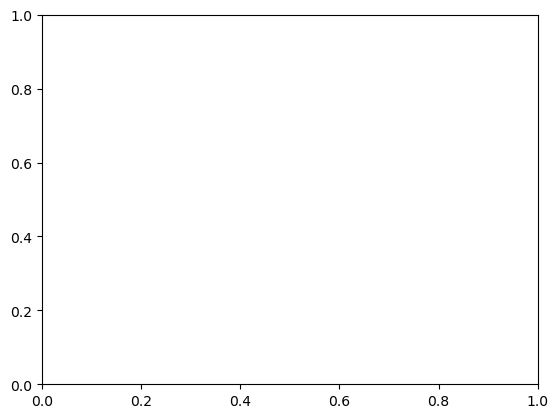

<Figure size 1000x400 with 0 Axes>

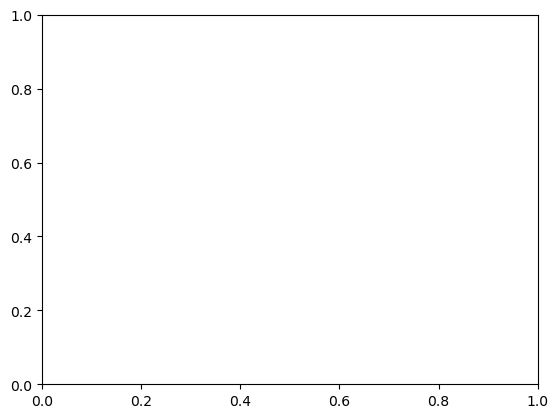

<Figure size 1000x400 with 0 Axes>

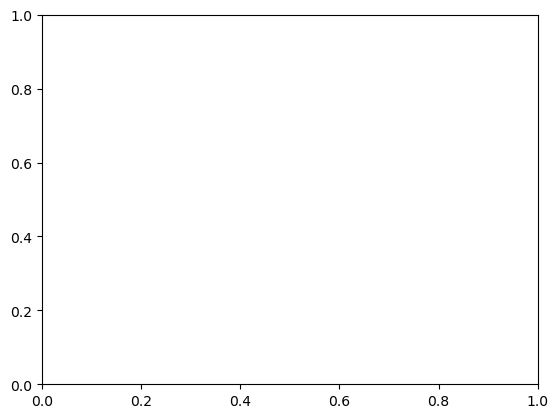

<Figure size 1000x400 with 0 Axes>

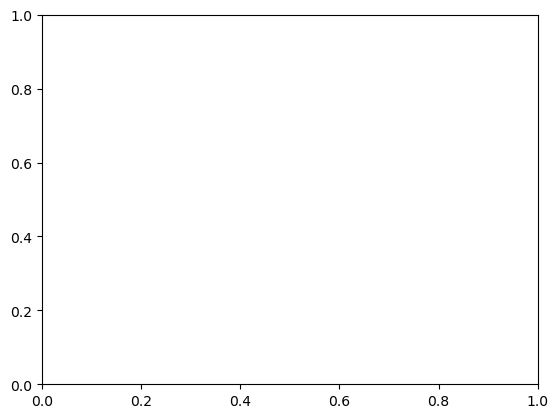

<Figure size 1000x400 with 0 Axes>

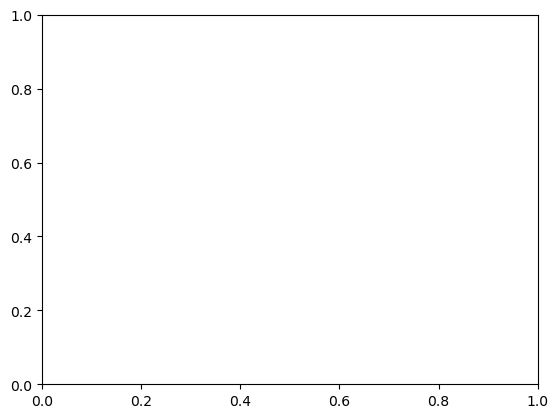

<Figure size 1000x400 with 0 Axes>

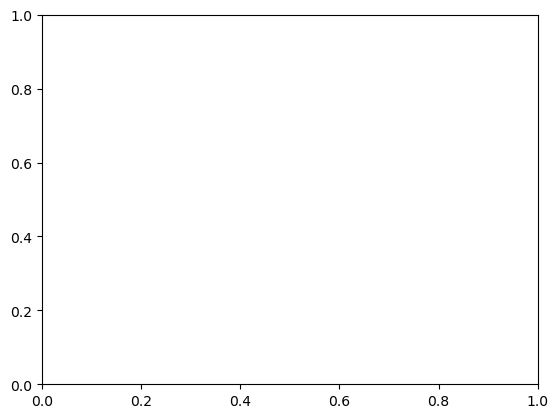

<Figure size 1000x400 with 0 Axes>

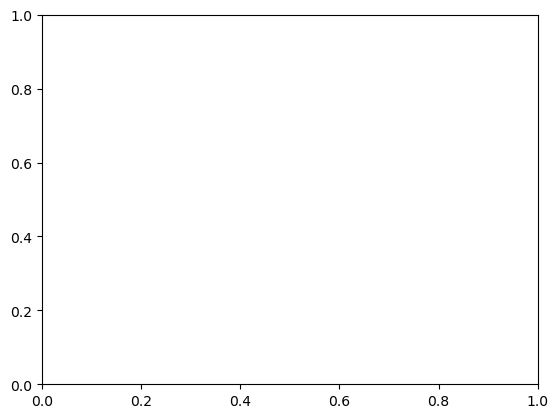

<Figure size 1000x400 with 0 Axes>

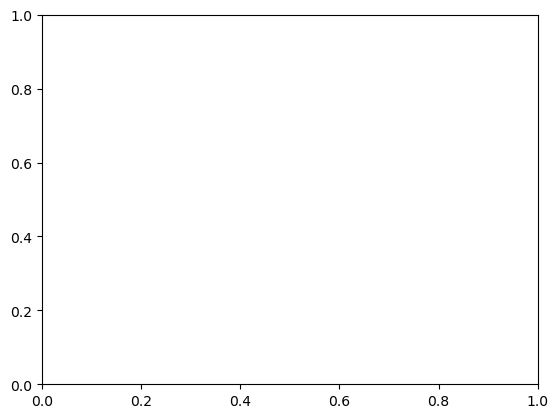

<Figure size 1000x400 with 0 Axes>

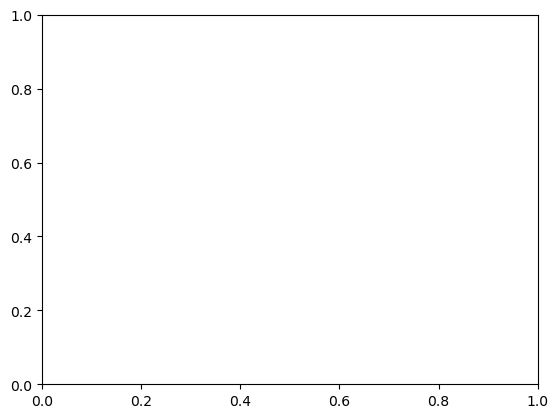

<Figure size 1000x400 with 0 Axes>

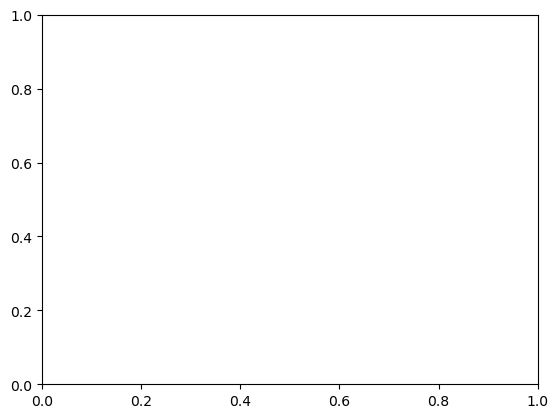

<Figure size 1000x400 with 0 Axes>

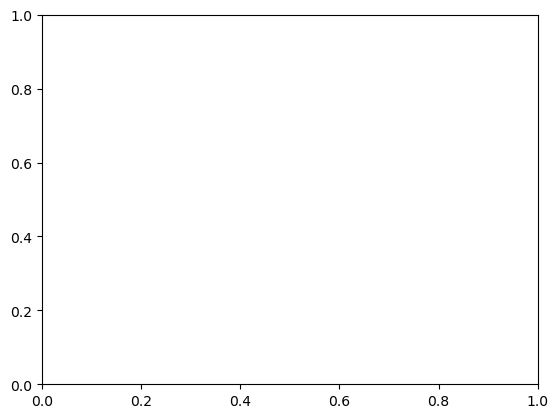

<Figure size 1000x400 with 0 Axes>

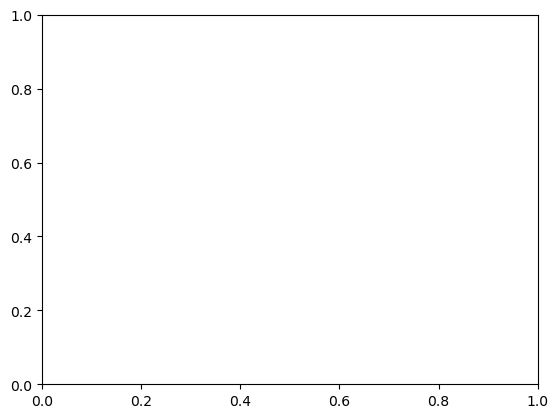

<Figure size 1000x400 with 0 Axes>

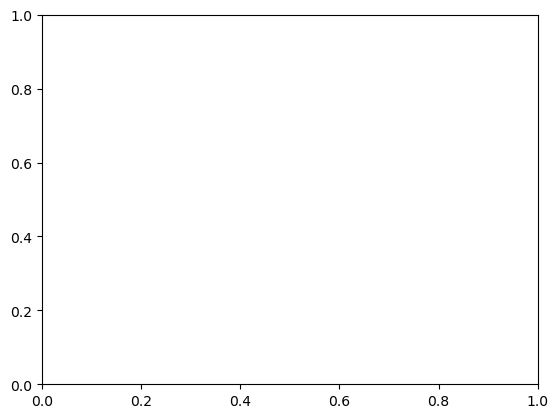

<Figure size 1000x400 with 0 Axes>

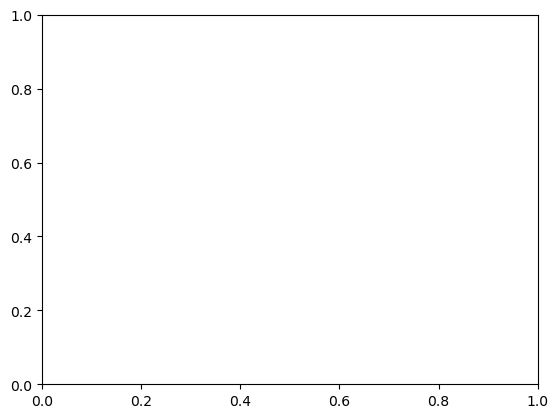

<Figure size 1000x400 with 0 Axes>

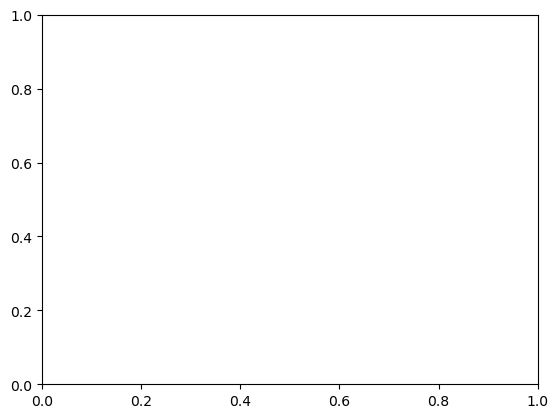

<Figure size 1000x400 with 0 Axes>

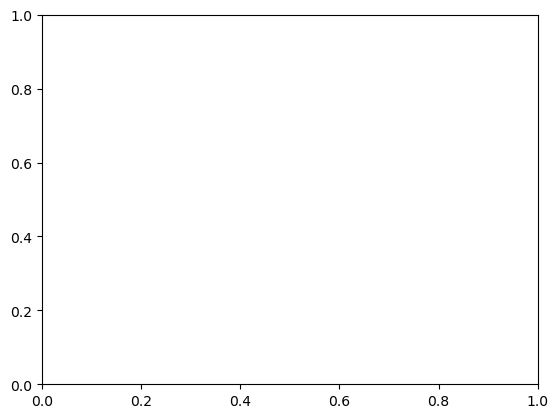

<Figure size 1000x400 with 0 Axes>

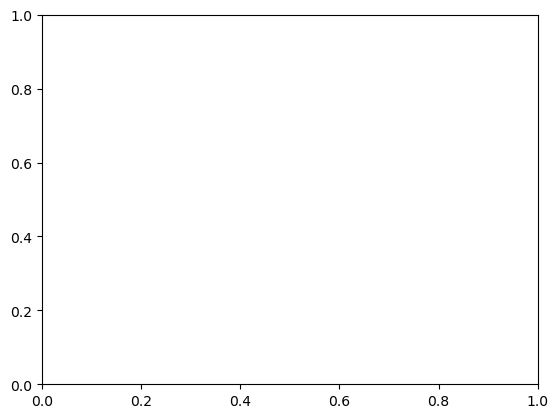

<Figure size 1000x400 with 0 Axes>

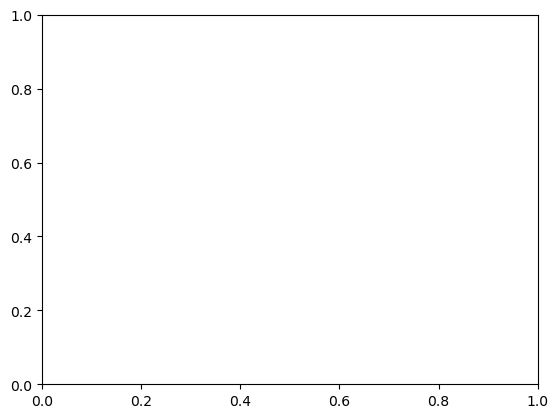

<Figure size 1000x400 with 0 Axes>

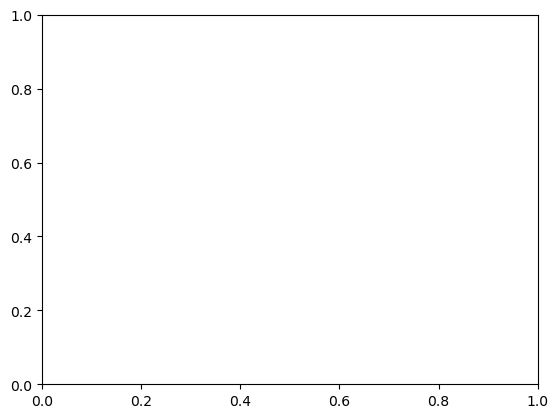

<Figure size 1000x400 with 0 Axes>

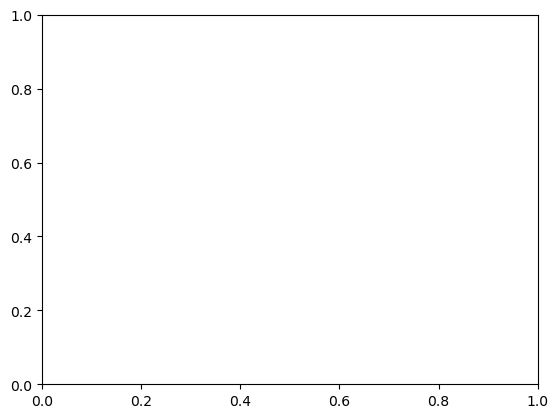

<Figure size 1000x400 with 0 Axes>

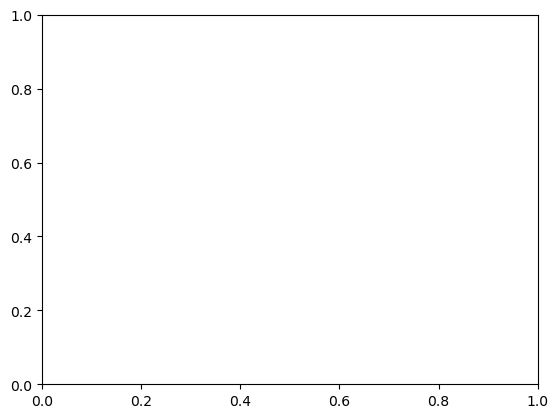

<Figure size 1000x400 with 0 Axes>

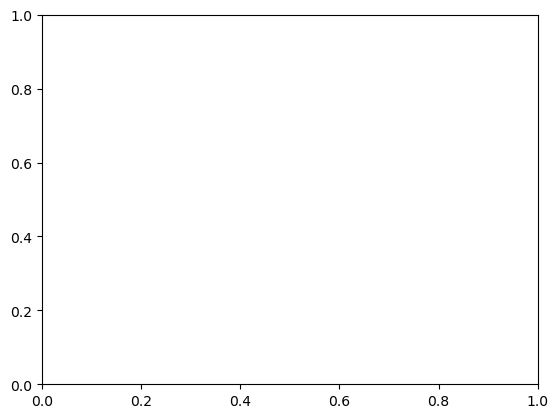

<Figure size 1000x400 with 0 Axes>

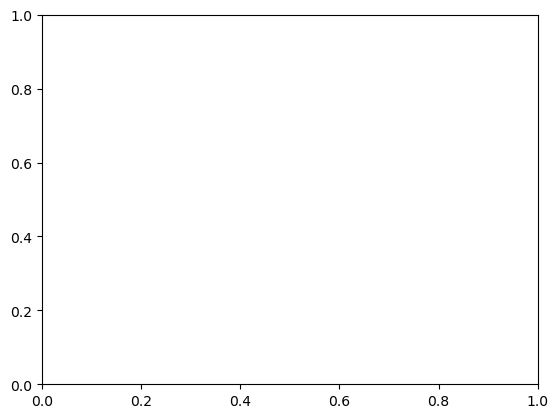

<Figure size 1000x400 with 0 Axes>

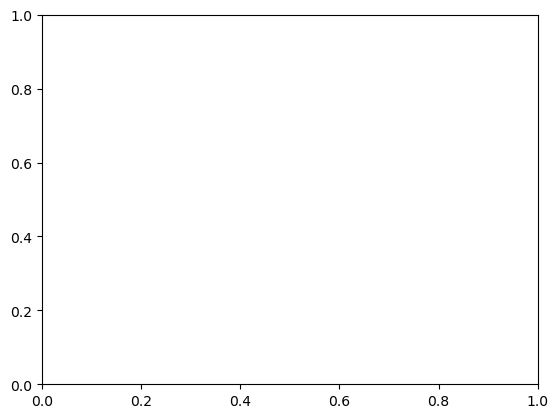

<Figure size 1000x400 with 0 Axes>

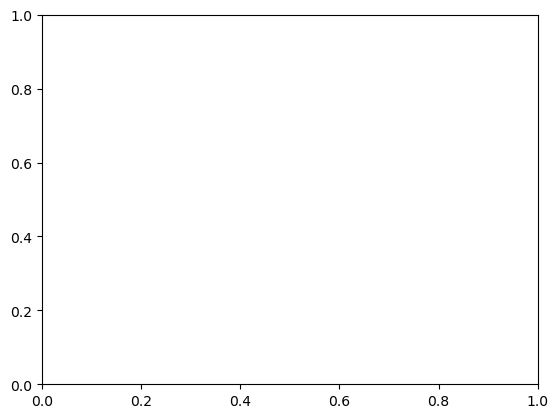

<Figure size 1000x400 with 0 Axes>

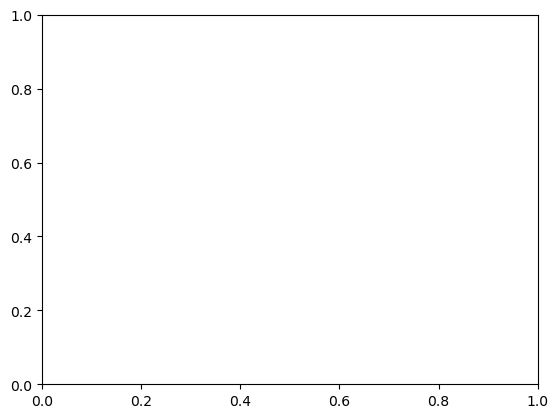

<Figure size 1000x400 with 0 Axes>

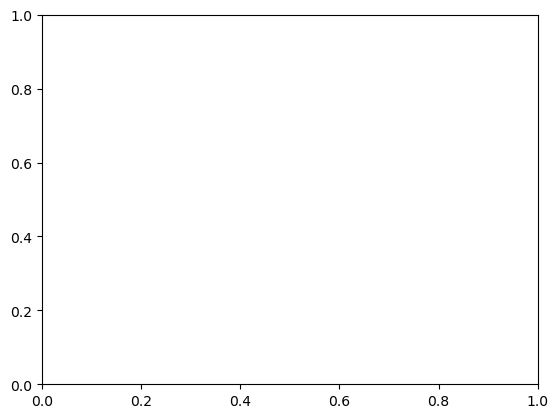

<Figure size 1000x400 with 0 Axes>

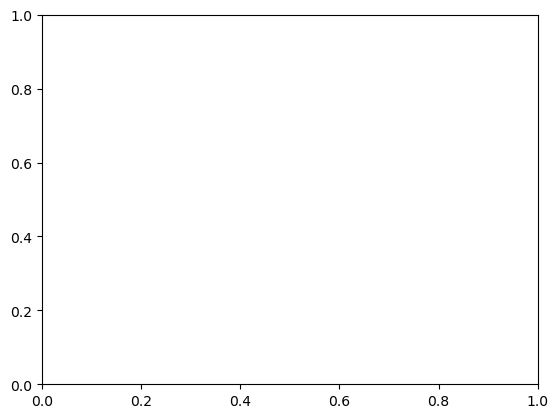

<Figure size 1000x400 with 0 Axes>

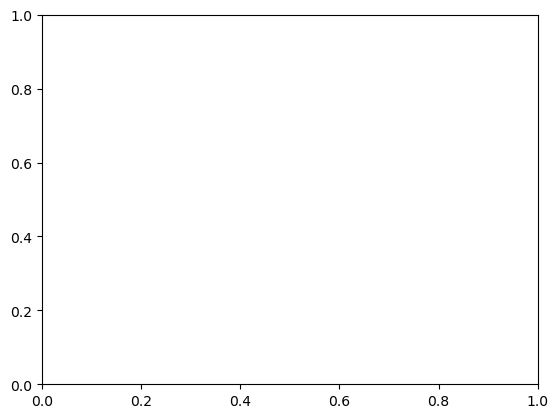

<Figure size 1000x400 with 0 Axes>

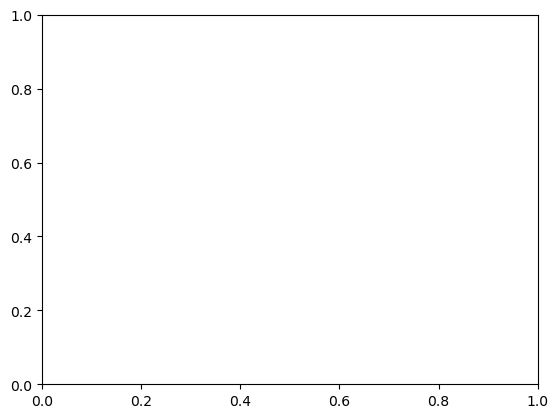

<Figure size 1000x400 with 0 Axes>

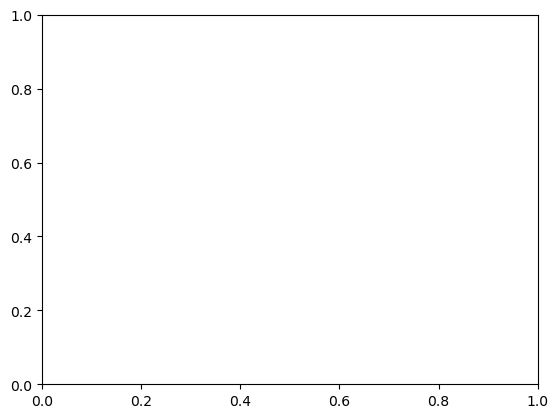

<Figure size 1000x400 with 0 Axes>

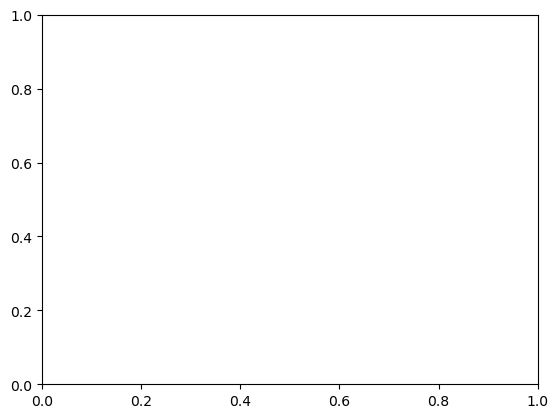

<Figure size 1000x400 with 0 Axes>

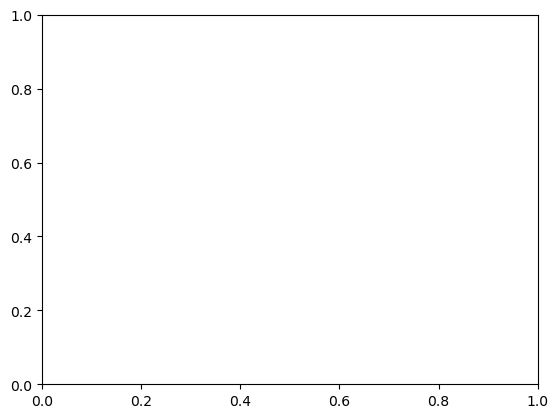

<Figure size 1000x400 with 0 Axes>

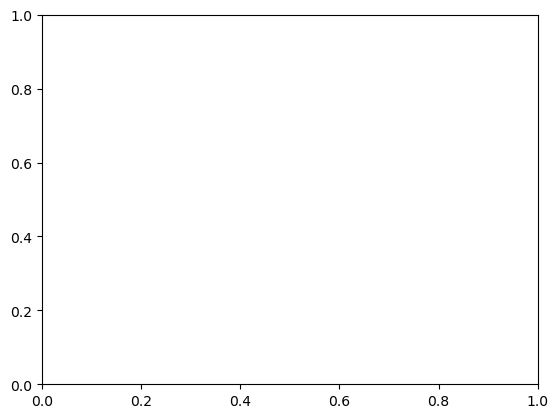

<Figure size 1000x400 with 0 Axes>

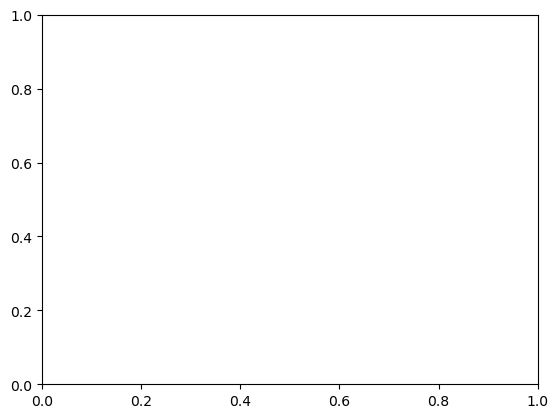

<Figure size 1000x400 with 0 Axes>

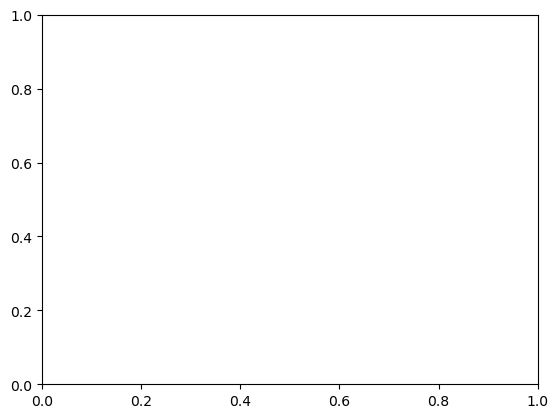

<Figure size 1000x400 with 0 Axes>

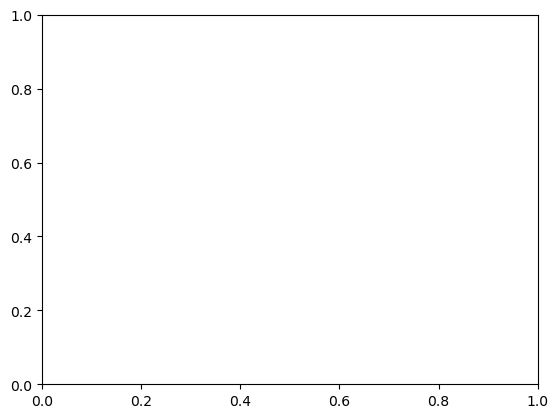

<Figure size 1000x400 with 0 Axes>

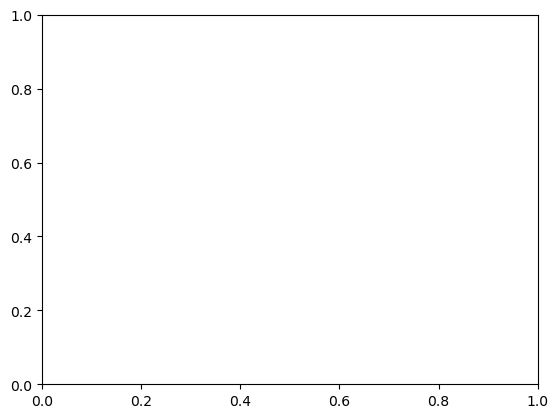

<Figure size 1000x400 with 0 Axes>

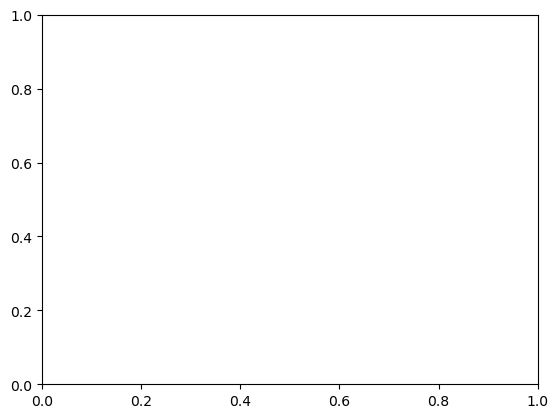

<Figure size 1000x400 with 0 Axes>

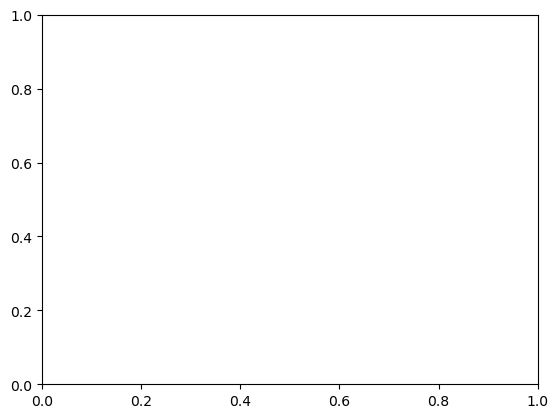

<Figure size 1000x400 with 0 Axes>

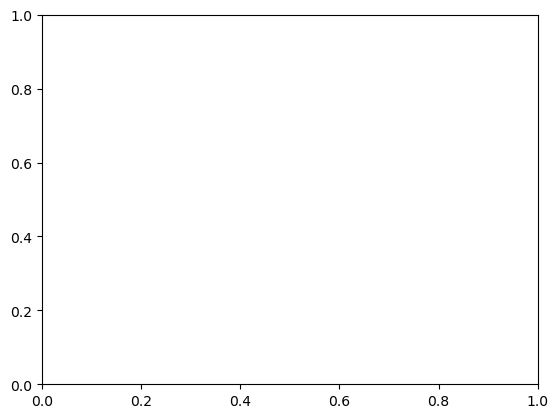

<Figure size 1000x400 with 0 Axes>

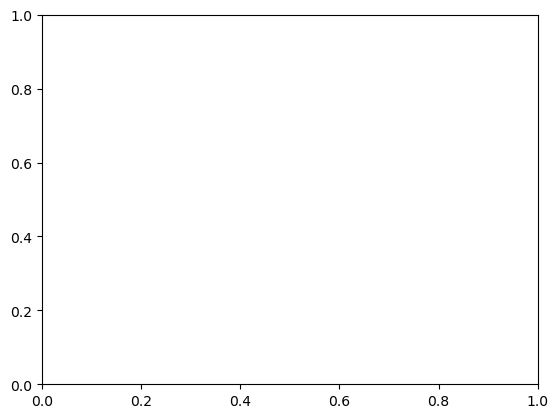

<Figure size 1000x400 with 0 Axes>

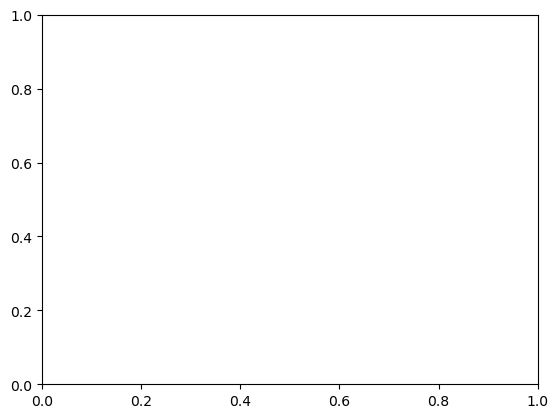

<Figure size 1000x400 with 0 Axes>

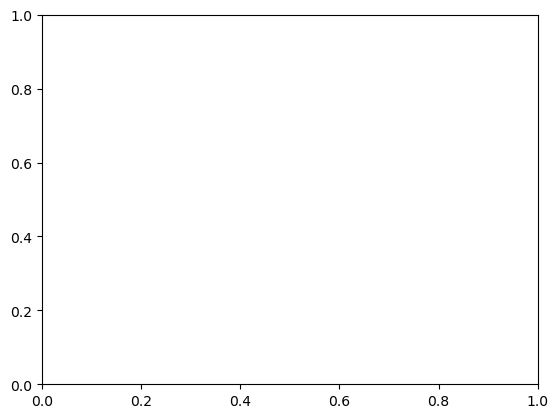

<Figure size 1000x400 with 0 Axes>

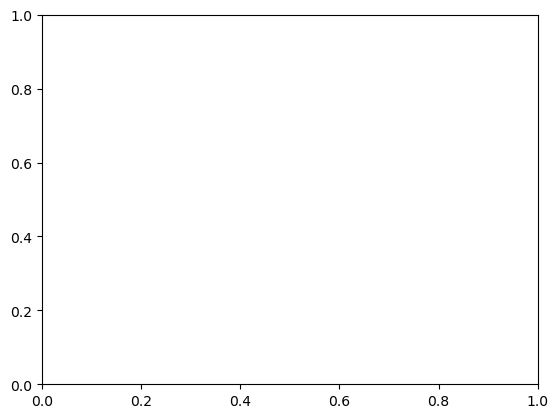

<Figure size 1000x400 with 0 Axes>

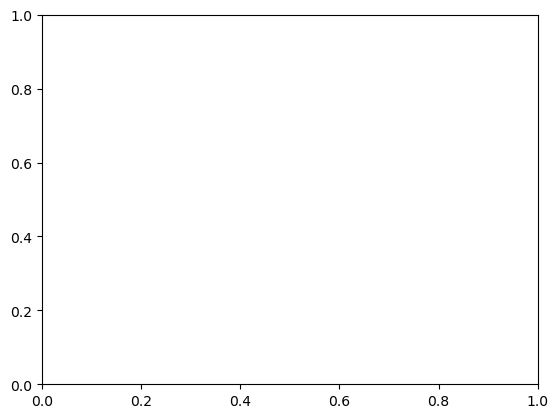

<Figure size 1000x400 with 0 Axes>

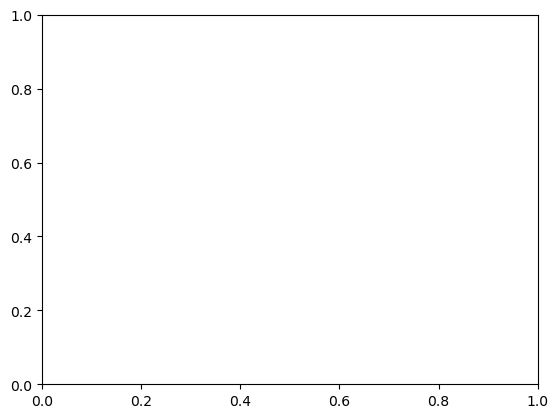

<Figure size 1000x400 with 0 Axes>

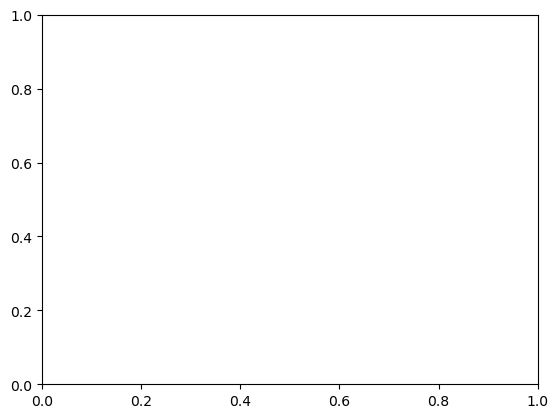

<Figure size 1000x400 with 0 Axes>

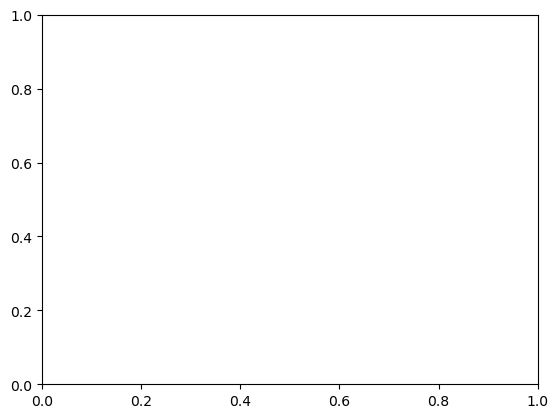

<Figure size 1000x400 with 0 Axes>

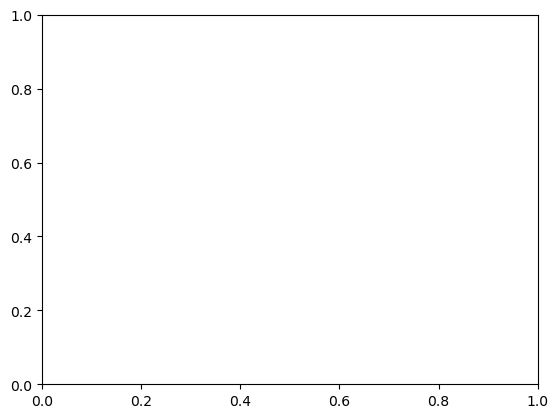

<Figure size 1000x400 with 0 Axes>

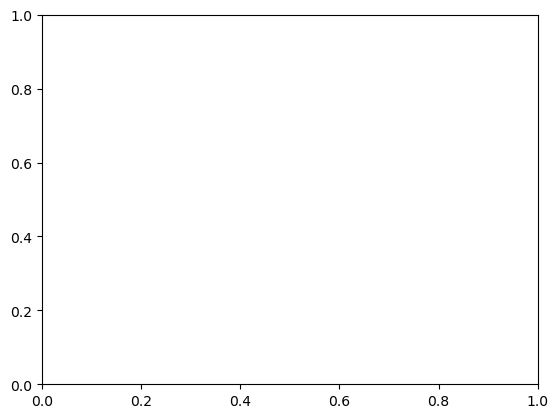

<Figure size 1000x400 with 0 Axes>

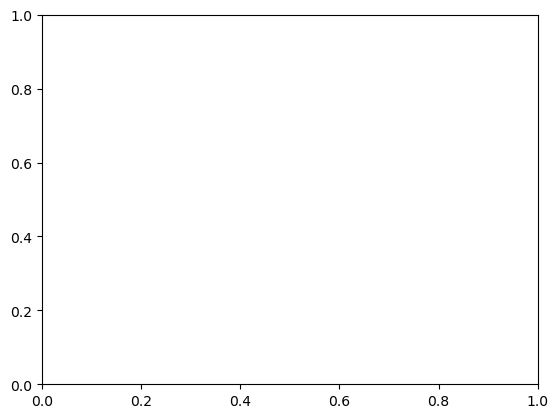

<Figure size 1000x400 with 0 Axes>

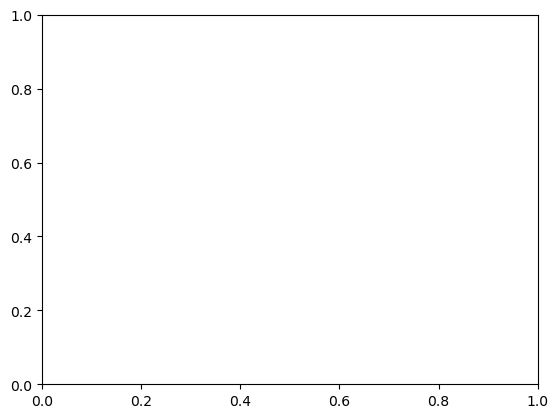

<Figure size 1000x400 with 0 Axes>

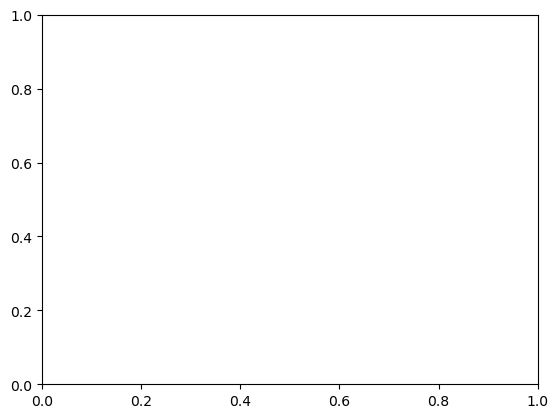

<Figure size 1000x400 with 0 Axes>

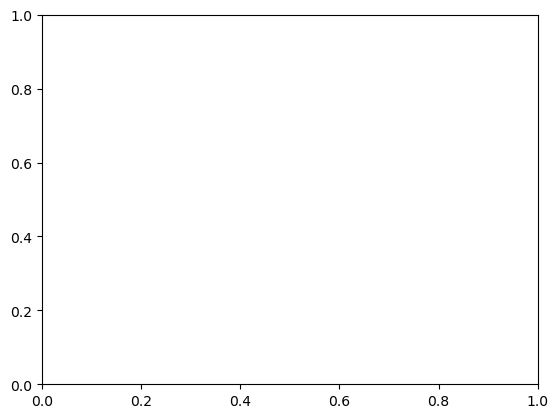

<Figure size 1000x400 with 0 Axes>

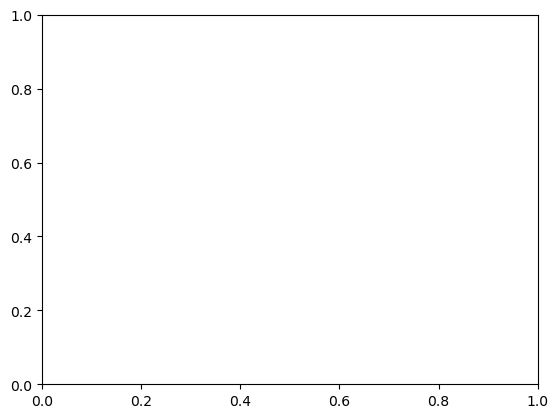

<Figure size 1000x400 with 0 Axes>

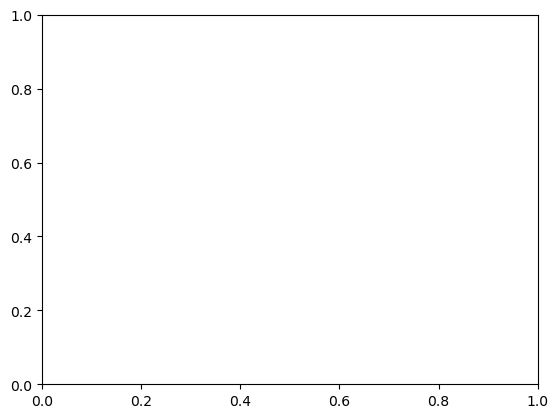

<Figure size 1000x400 with 0 Axes>

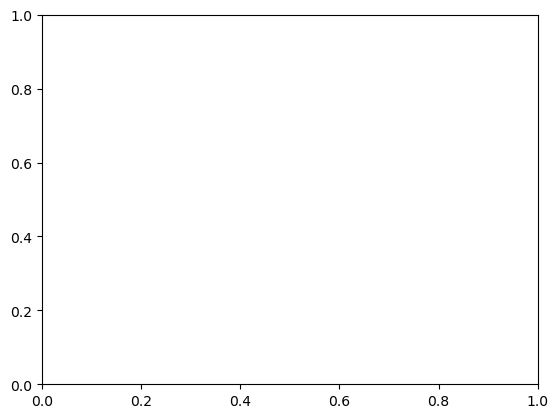

<Figure size 1000x400 with 0 Axes>

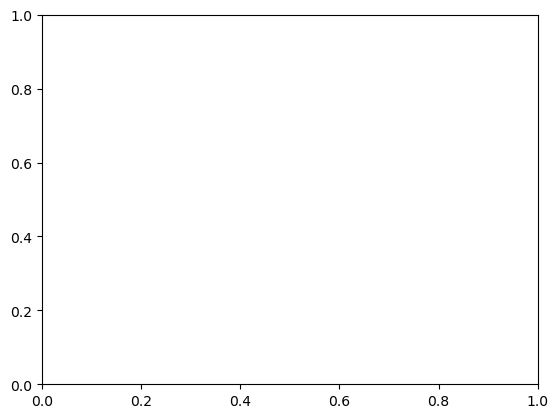

<Figure size 1000x400 with 0 Axes>

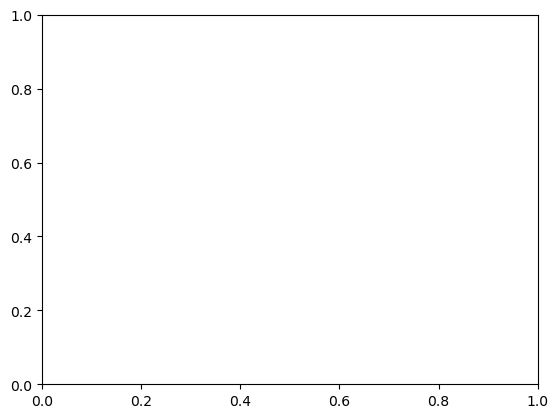

<Figure size 1000x400 with 0 Axes>

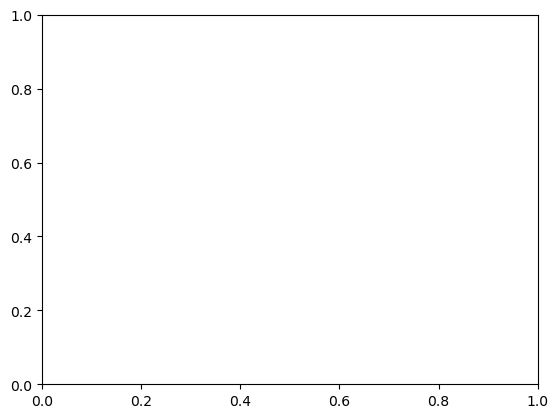

<Figure size 1000x400 with 0 Axes>

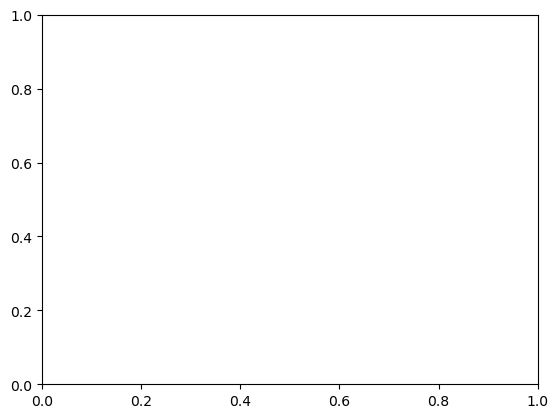

<Figure size 1000x400 with 0 Axes>

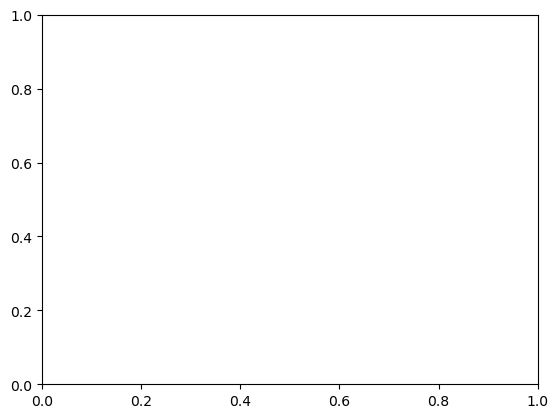

<Figure size 1000x400 with 0 Axes>

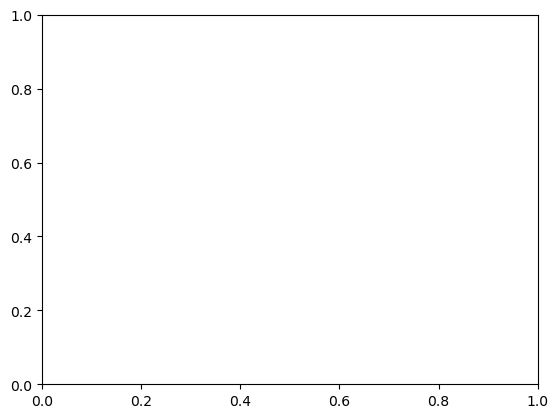

<Figure size 1000x400 with 0 Axes>

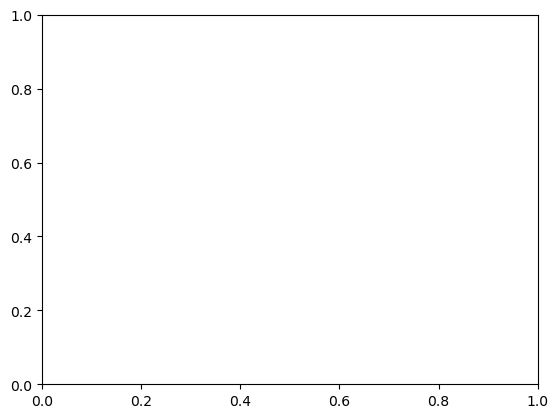

<Figure size 1000x400 with 0 Axes>

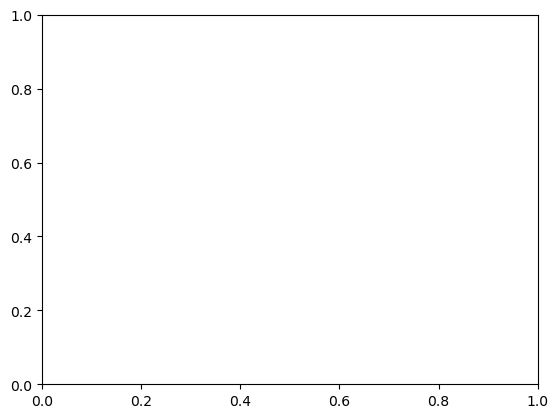

<Figure size 1000x400 with 0 Axes>

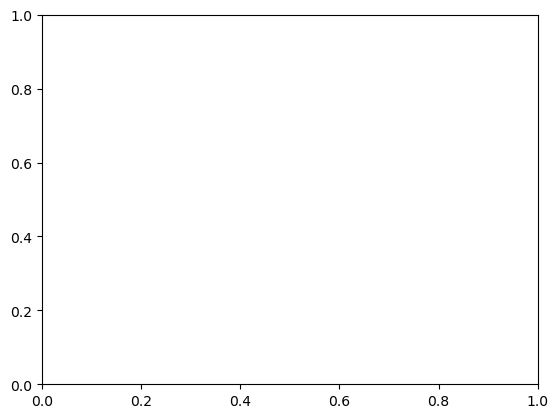

<Figure size 1000x400 with 0 Axes>

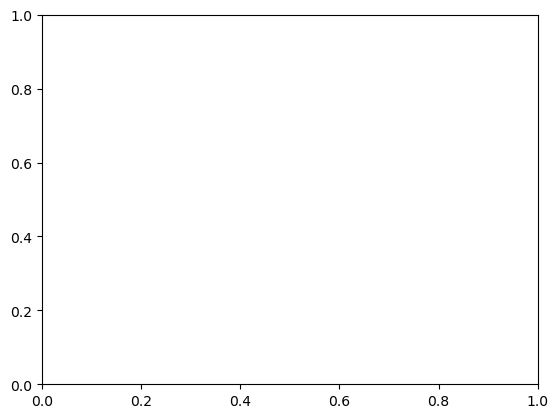

<Figure size 1000x400 with 0 Axes>

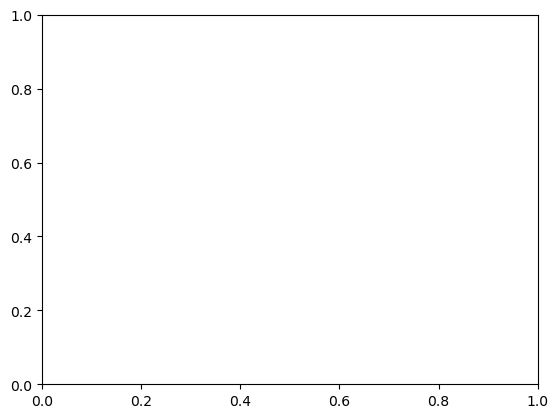

<Figure size 1000x400 with 0 Axes>

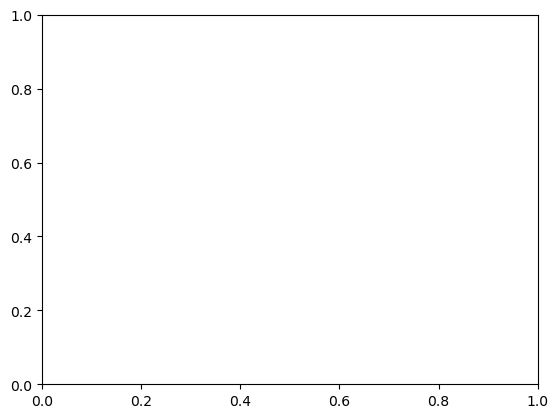

<Figure size 1000x400 with 0 Axes>

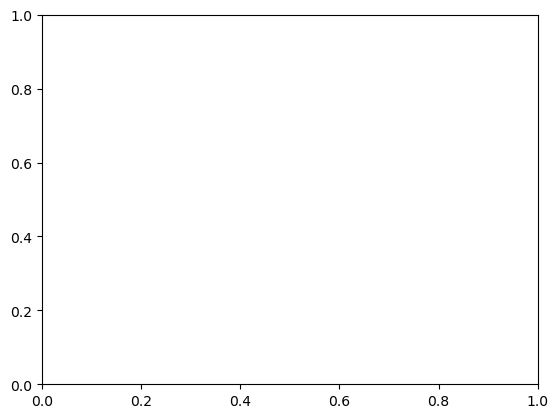

<Figure size 1000x400 with 0 Axes>

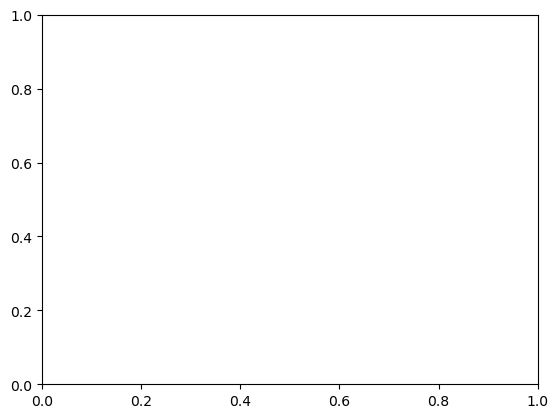

<Figure size 1000x400 with 0 Axes>

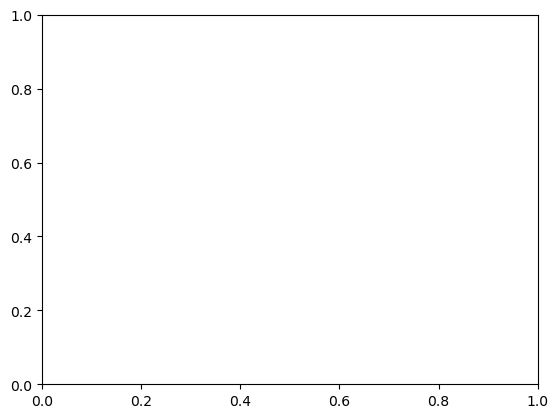

<Figure size 1000x400 with 0 Axes>

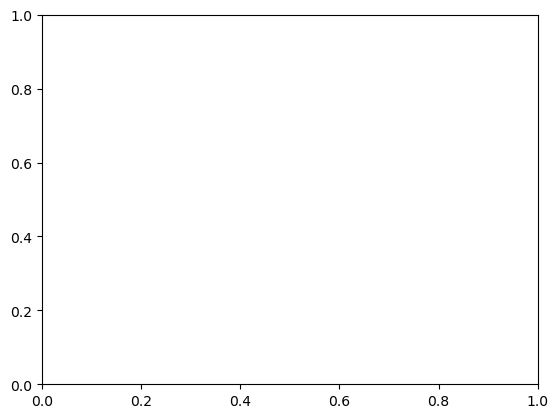

<Figure size 1000x400 with 0 Axes>

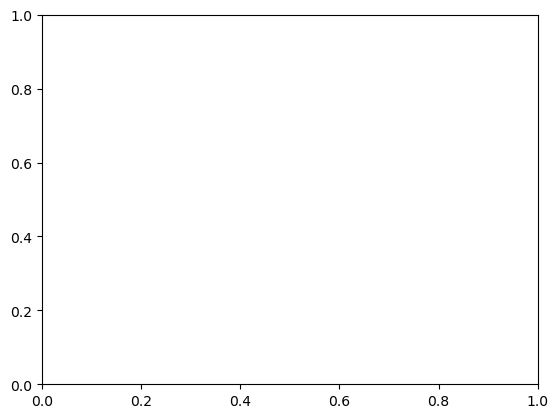

<Figure size 1000x400 with 0 Axes>

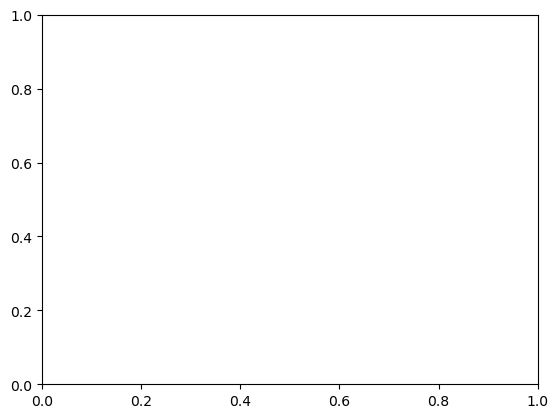

<Figure size 1000x400 with 0 Axes>

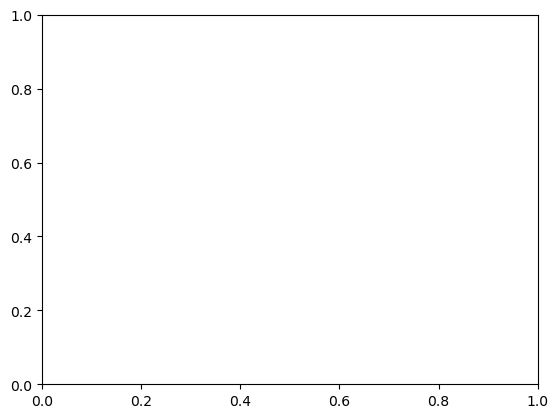

<Figure size 1000x400 with 0 Axes>

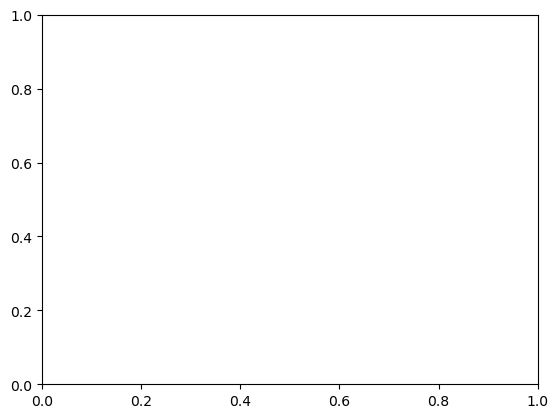

<Figure size 1000x400 with 0 Axes>

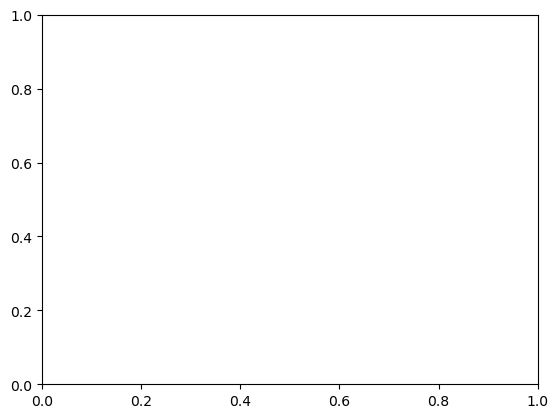

<Figure size 1000x400 with 0 Axes>

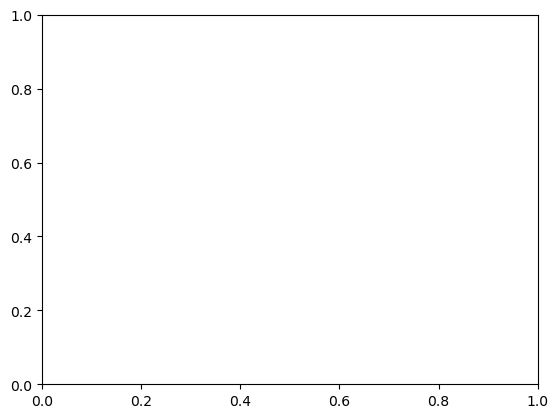

<Figure size 1000x400 with 0 Axes>

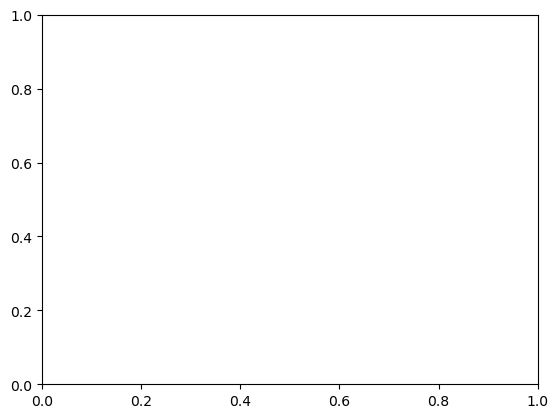

<Figure size 1000x400 with 0 Axes>

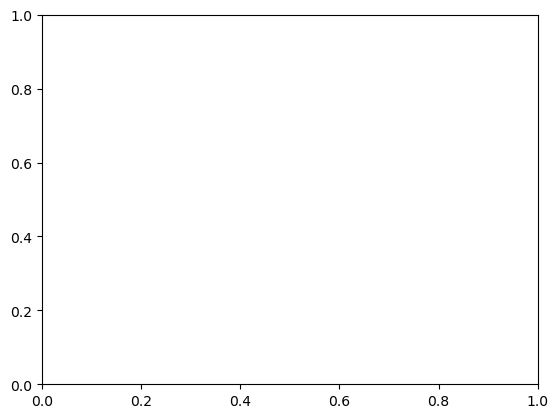

<Figure size 1000x400 with 0 Axes>

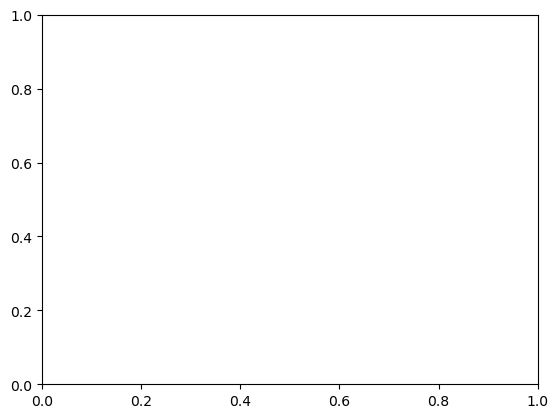

<Figure size 1000x400 with 0 Axes>

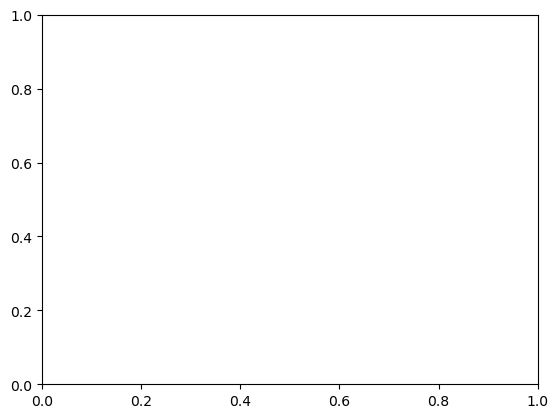

<Figure size 1000x400 with 0 Axes>

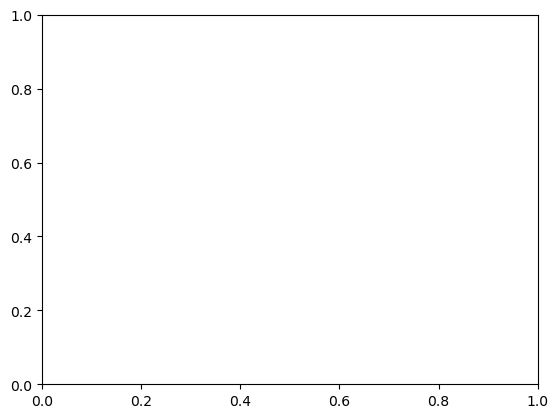

<Figure size 1000x400 with 0 Axes>

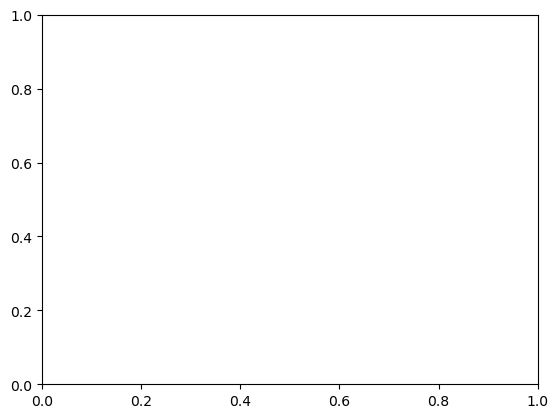

<Figure size 1000x400 with 0 Axes>

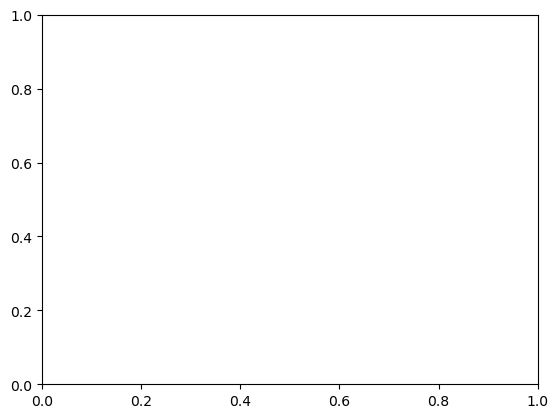

<Figure size 1000x400 with 0 Axes>

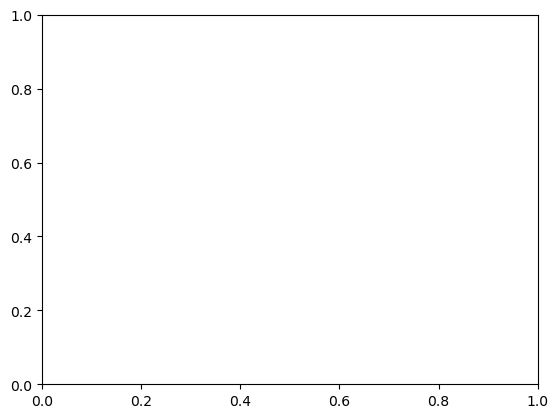

<Figure size 1000x400 with 0 Axes>

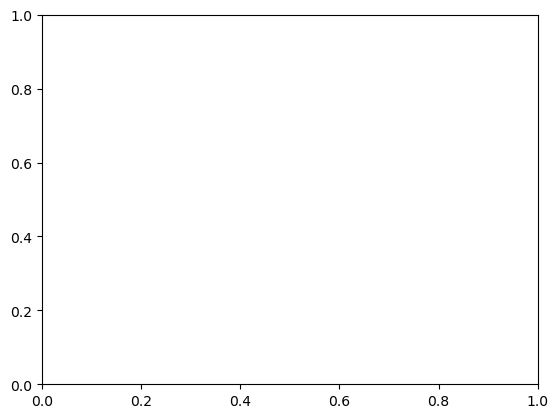

<Figure size 1000x400 with 0 Axes>

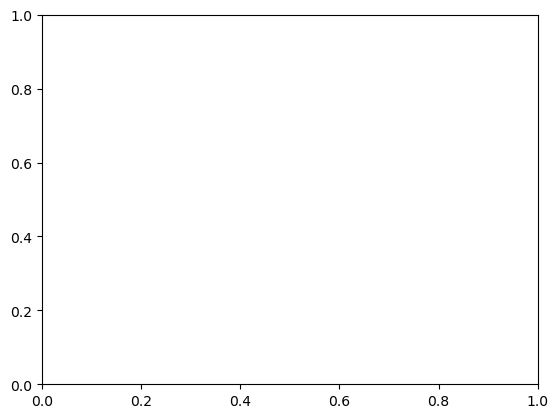

<Figure size 1000x400 with 0 Axes>

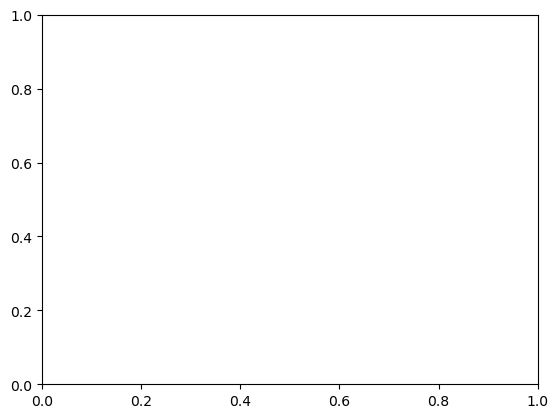

<Figure size 1000x400 with 0 Axes>

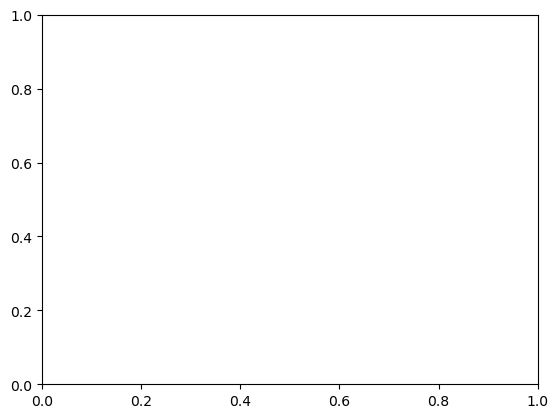

<Figure size 1000x400 with 0 Axes>

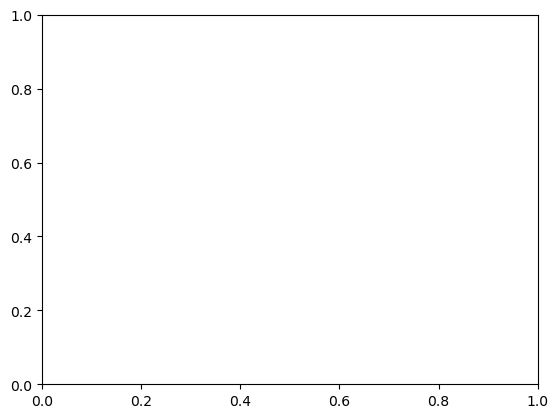

<Figure size 1000x400 with 0 Axes>

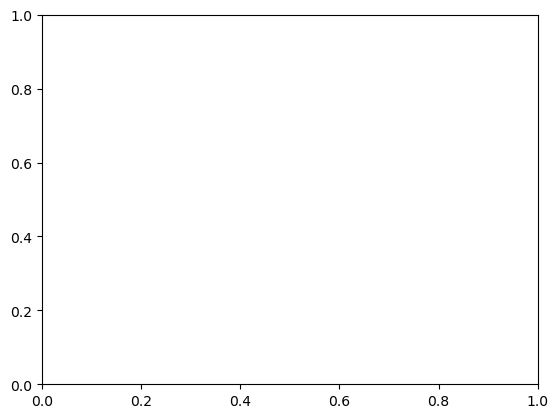

<Figure size 1000x400 with 0 Axes>

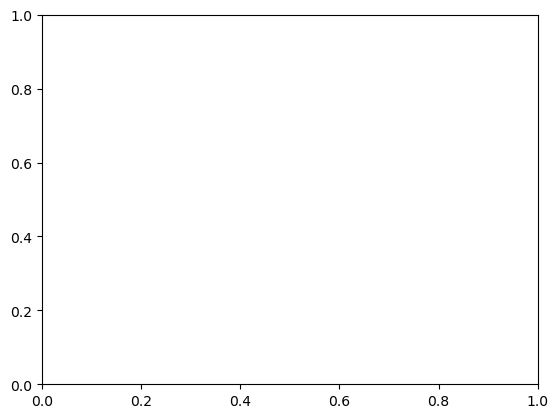

<Figure size 1000x400 with 0 Axes>

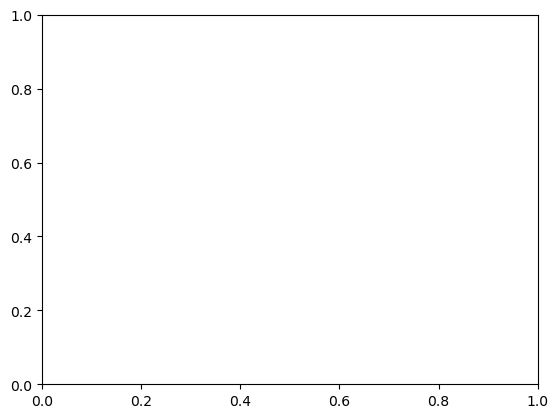

<Figure size 1000x400 with 0 Axes>

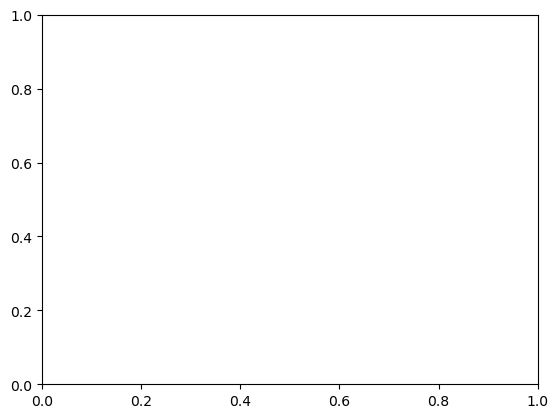

<Figure size 1000x400 with 0 Axes>

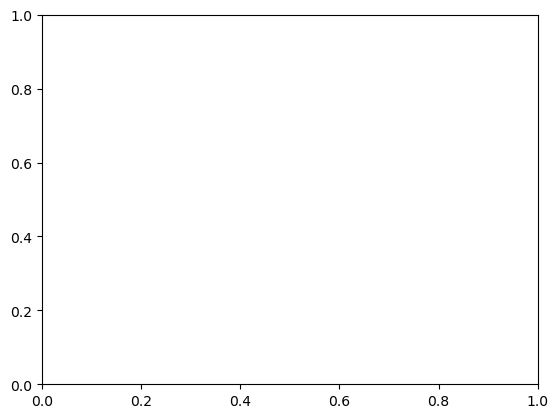

<Figure size 1000x400 with 0 Axes>

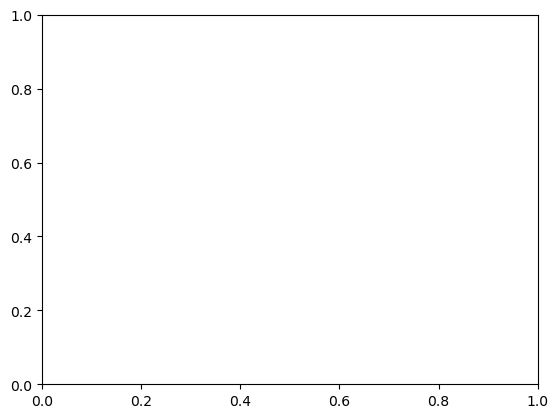

<Figure size 1000x400 with 0 Axes>

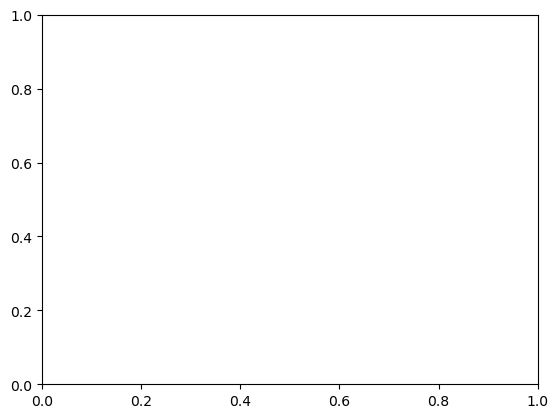

<Figure size 1000x400 with 0 Axes>

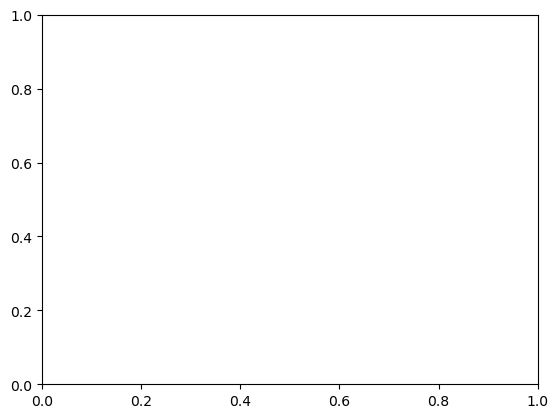

<Figure size 1000x400 with 0 Axes>

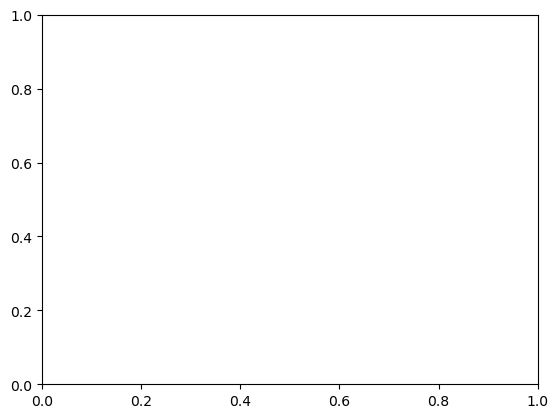

<Figure size 1000x400 with 0 Axes>

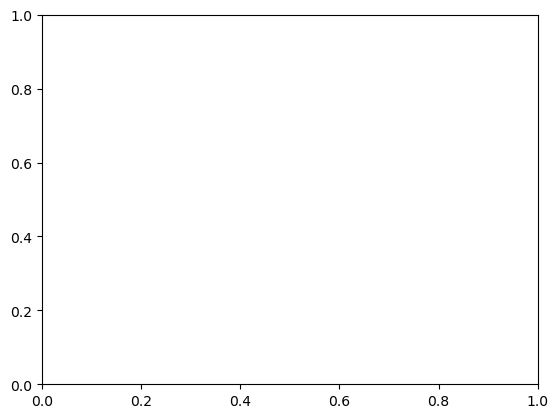

<Figure size 1000x400 with 0 Axes>

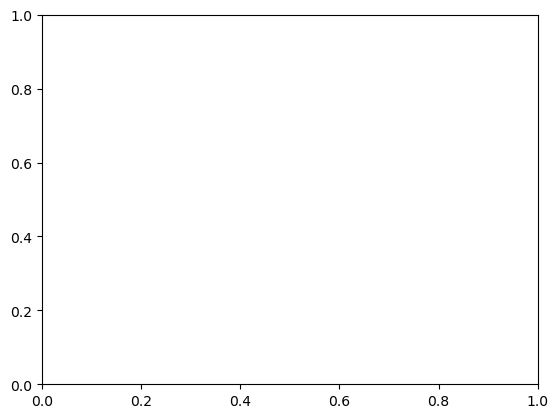

<Figure size 1000x400 with 0 Axes>

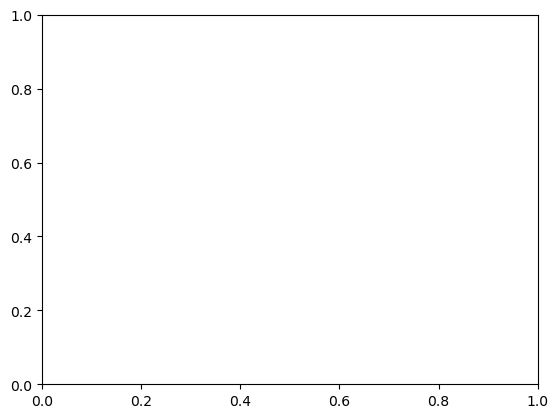

<Figure size 1000x400 with 0 Axes>

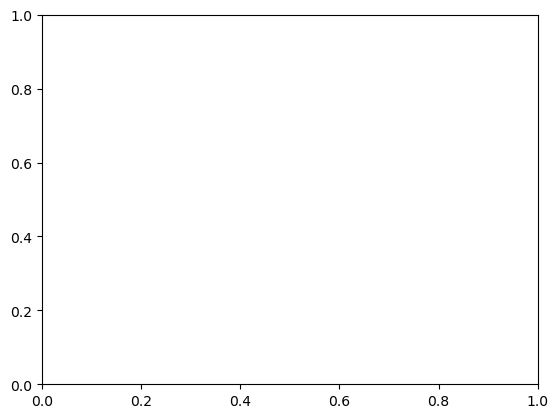

<Figure size 1000x400 with 0 Axes>

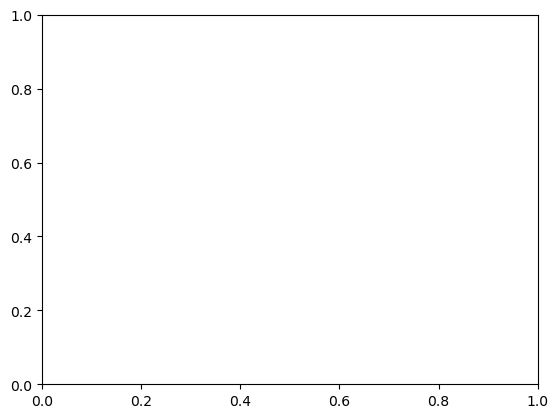

<Figure size 1000x400 with 0 Axes>

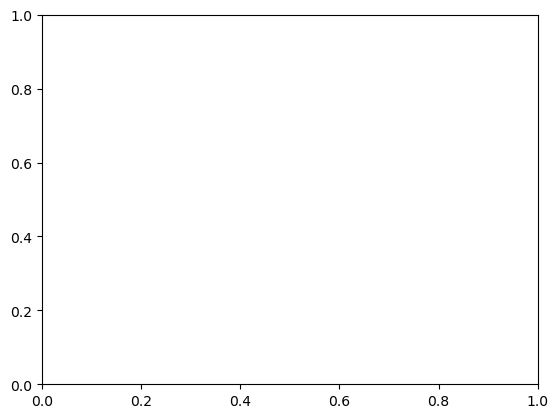

<Figure size 1000x400 with 0 Axes>

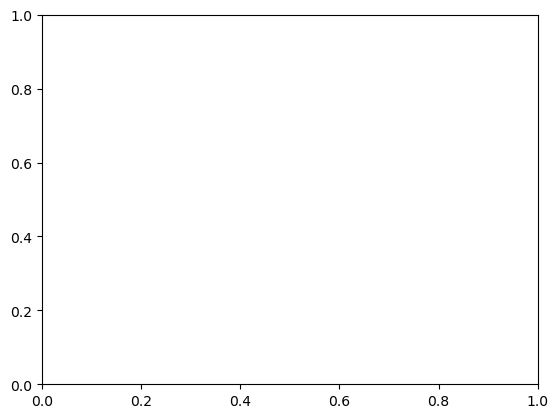

<Figure size 1000x400 with 0 Axes>

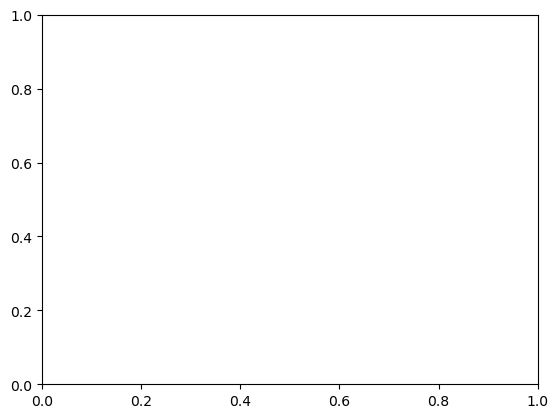

<Figure size 1000x400 with 0 Axes>

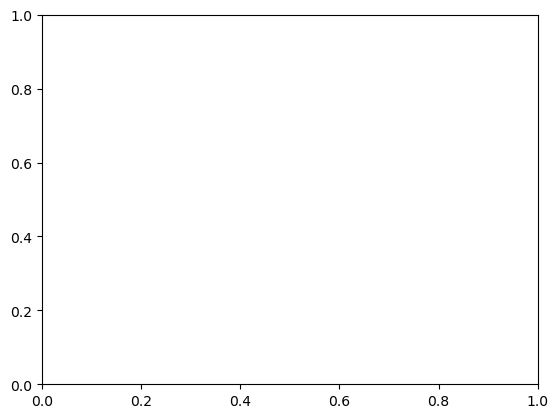

<Figure size 1000x400 with 0 Axes>

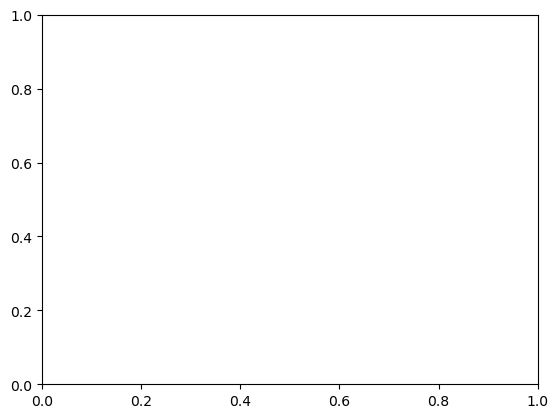

<Figure size 1000x400 with 0 Axes>

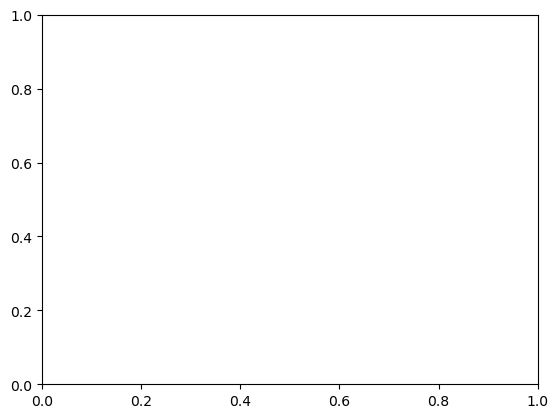

<Figure size 1000x400 with 0 Axes>

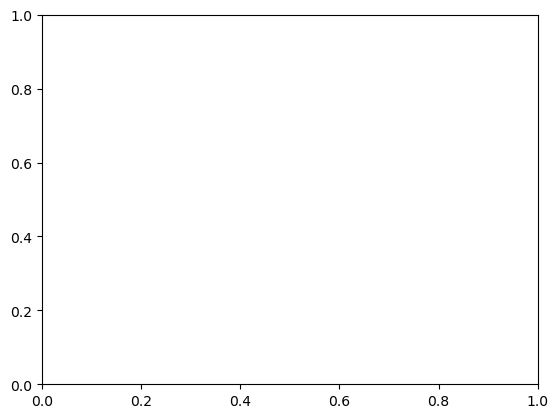

<Figure size 1000x400 with 0 Axes>

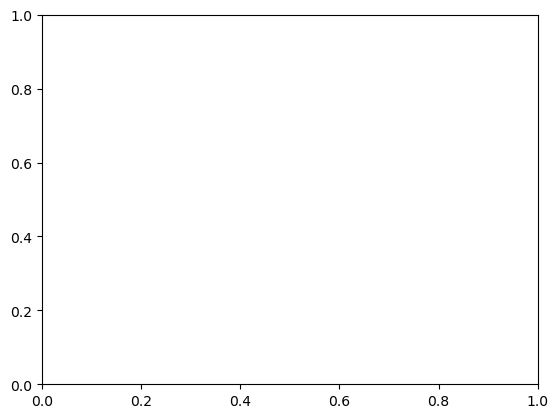

<Figure size 1000x400 with 0 Axes>

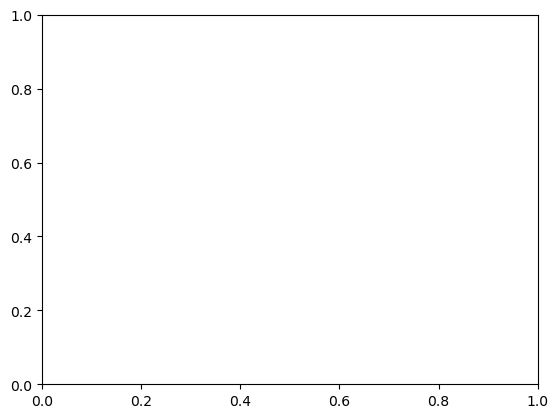

<Figure size 1000x400 with 0 Axes>

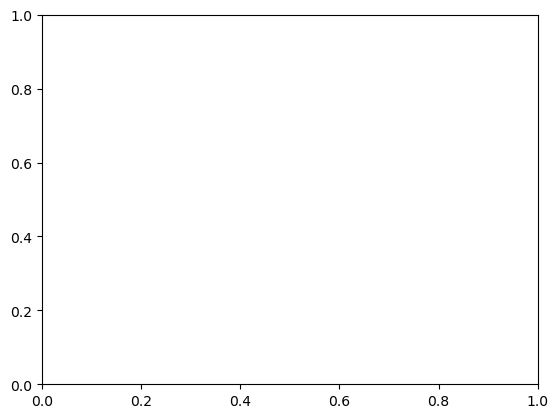

<Figure size 1000x400 with 0 Axes>

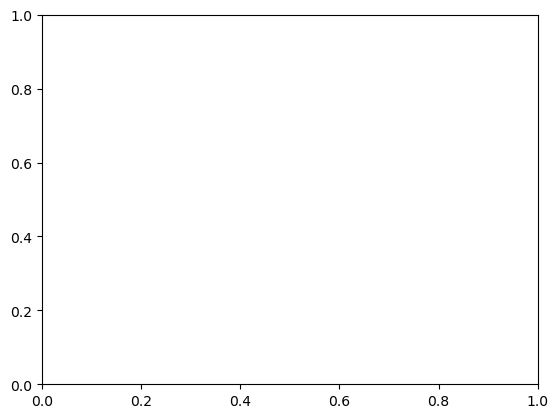

<Figure size 1000x400 with 0 Axes>

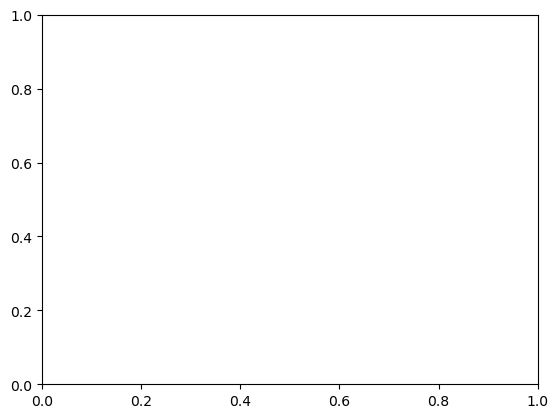

<Figure size 1000x400 with 0 Axes>

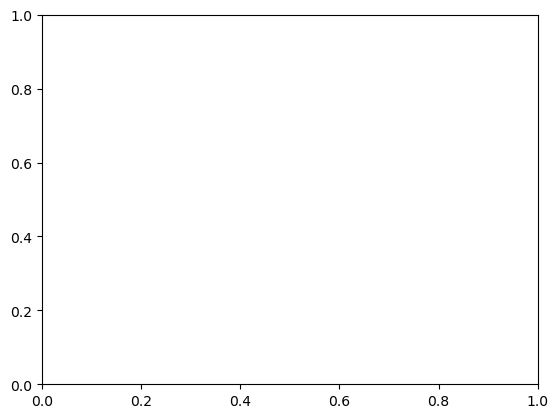

<Figure size 1000x400 with 0 Axes>

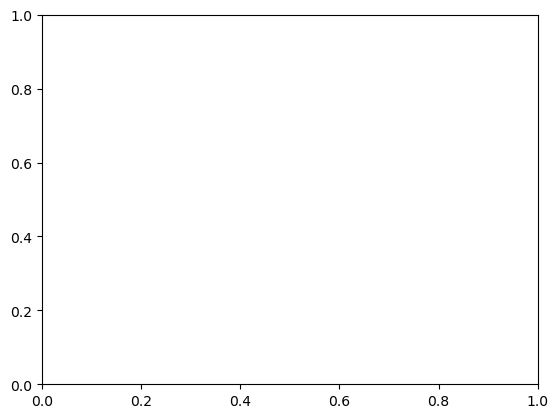

<Figure size 1000x400 with 0 Axes>

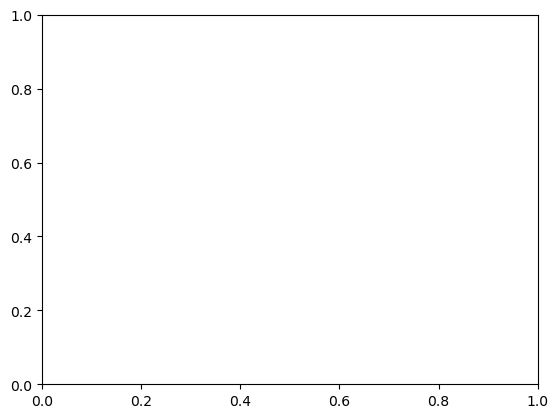

<Figure size 1000x400 with 0 Axes>

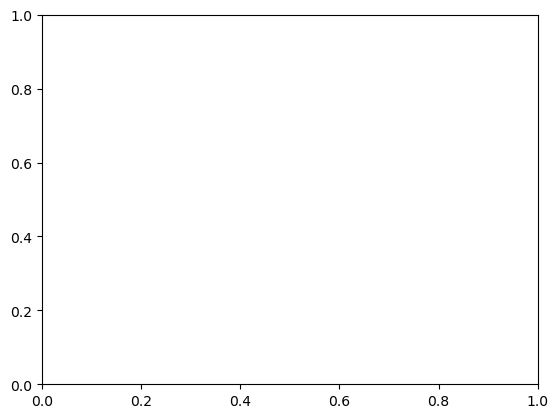

<Figure size 1000x400 with 0 Axes>

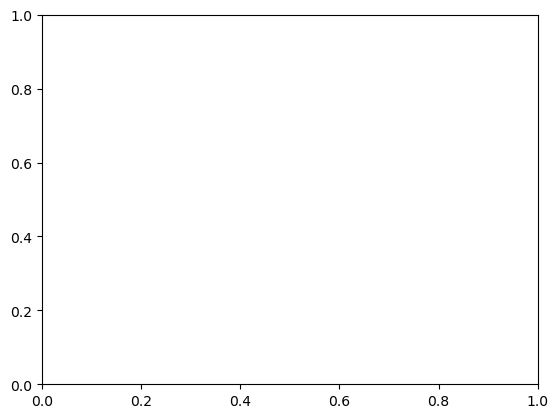

<Figure size 1000x400 with 0 Axes>

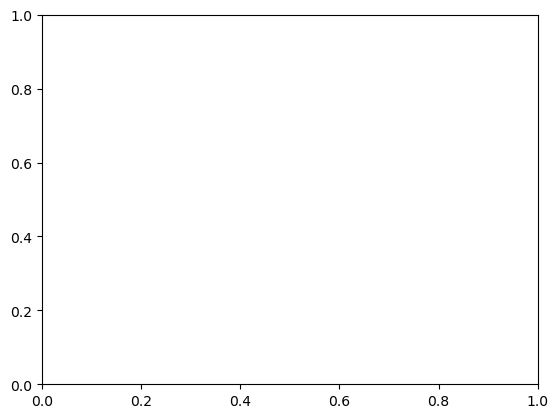

<Figure size 1000x400 with 0 Axes>

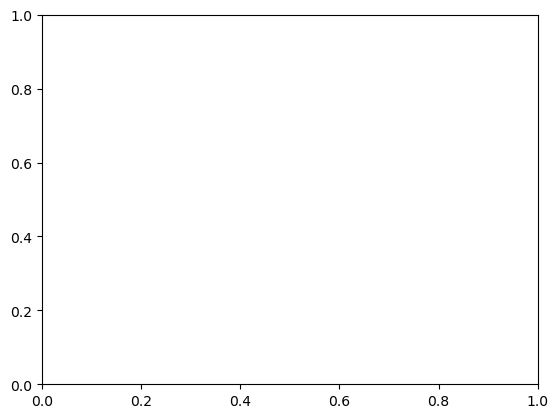

<Figure size 1000x400 with 0 Axes>

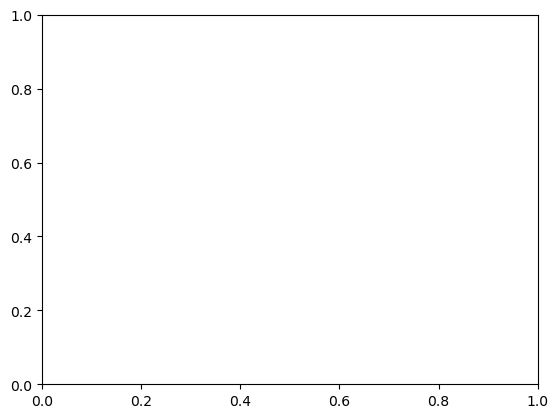

<Figure size 1000x400 with 0 Axes>

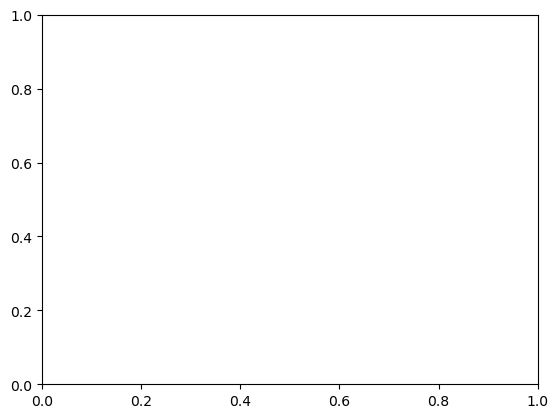

<Figure size 1000x400 with 0 Axes>

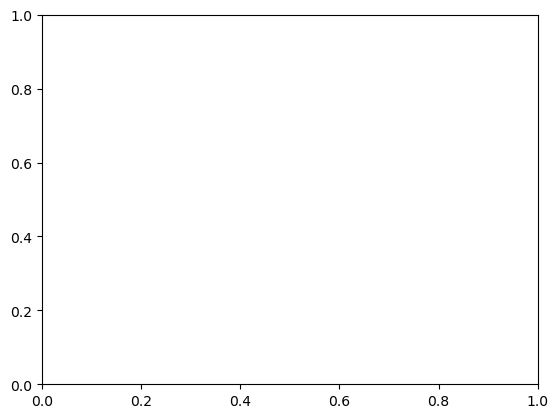

<Figure size 1000x400 with 0 Axes>

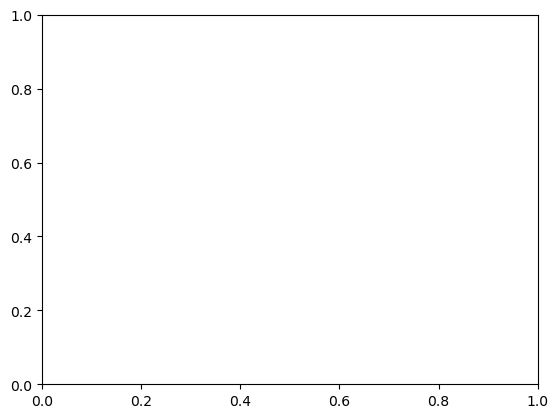

<Figure size 1000x400 with 0 Axes>

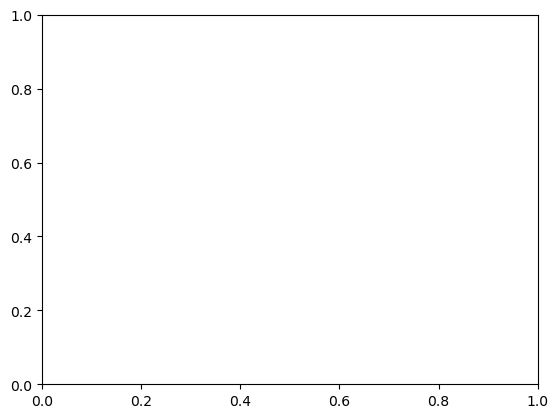

<Figure size 1000x400 with 0 Axes>

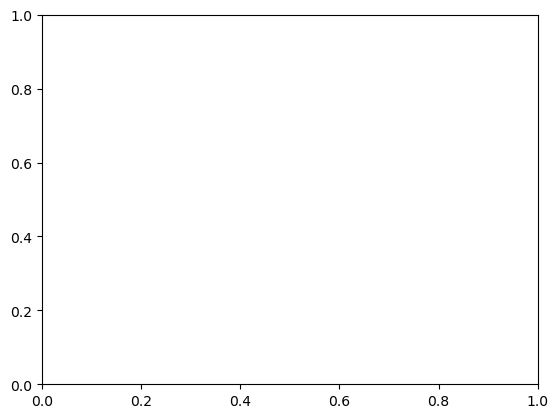

<Figure size 1000x400 with 0 Axes>

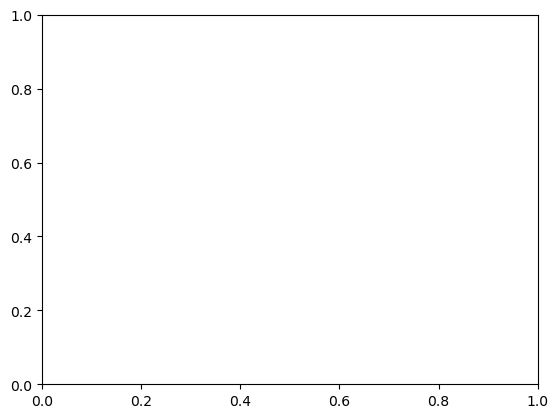

<Figure size 1000x400 with 0 Axes>

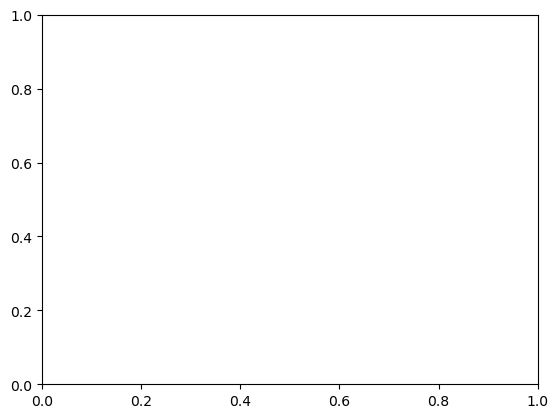

<Figure size 1000x400 with 0 Axes>

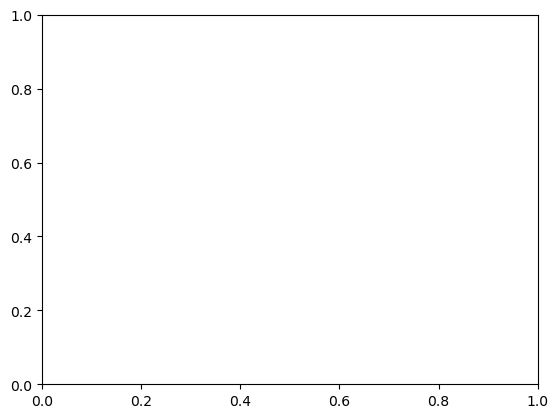

<Figure size 1000x400 with 0 Axes>

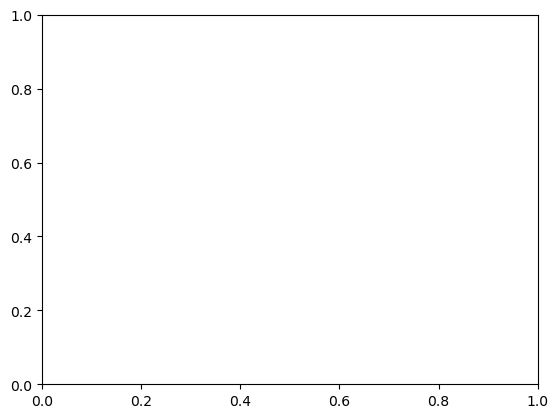

<Figure size 1000x400 with 0 Axes>

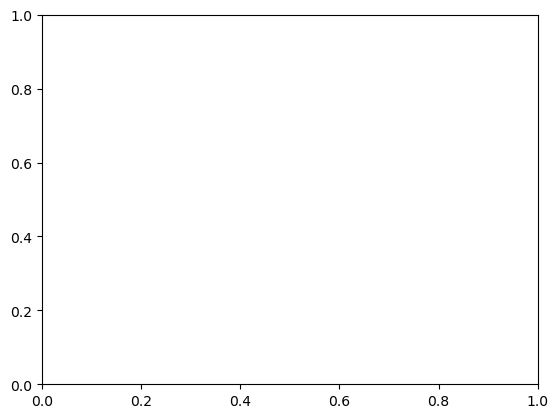

<Figure size 1000x400 with 0 Axes>

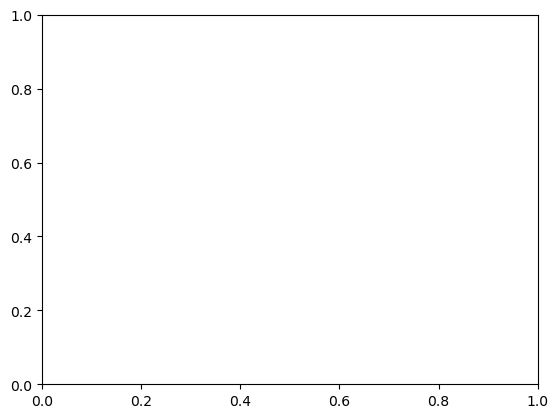

<Figure size 1000x400 with 0 Axes>

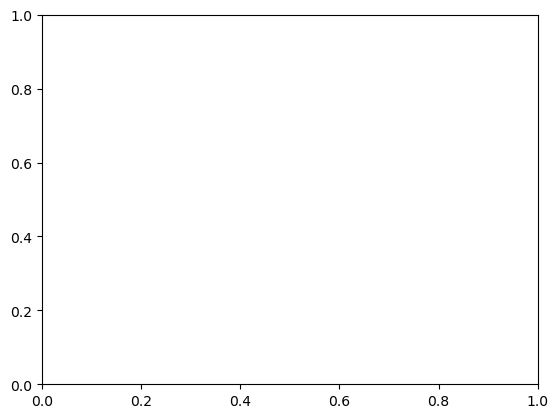

<Figure size 1000x400 with 0 Axes>

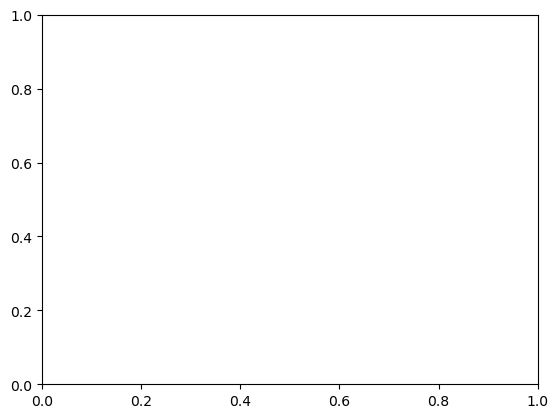

<Figure size 1000x400 with 0 Axes>

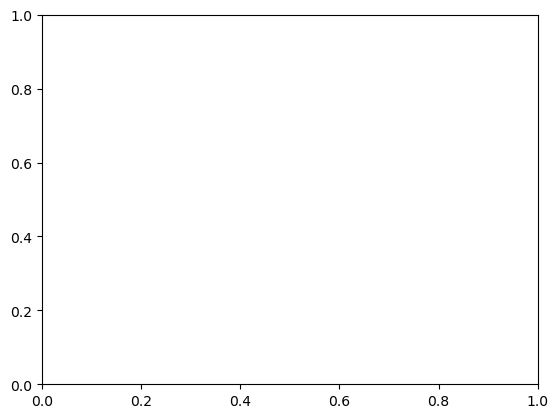

<Figure size 1000x400 with 0 Axes>

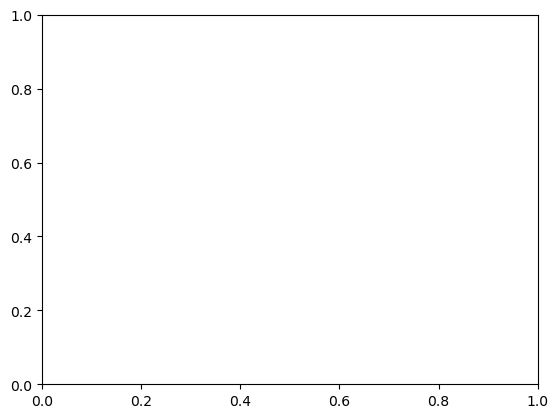

<Figure size 1000x400 with 0 Axes>

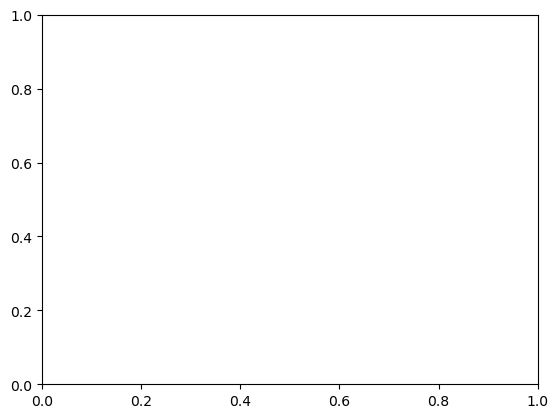

<Figure size 1000x400 with 0 Axes>

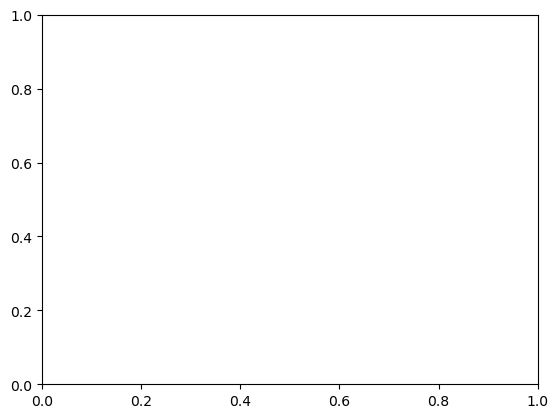

<Figure size 1000x400 with 0 Axes>

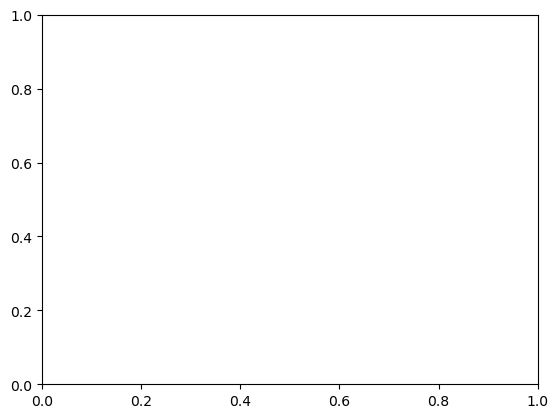

<Figure size 1000x400 with 0 Axes>

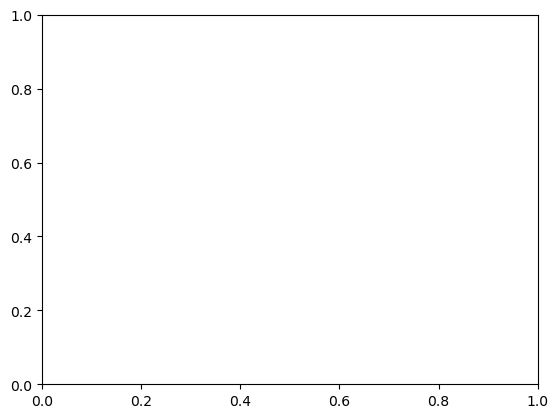

<Figure size 1000x400 with 0 Axes>

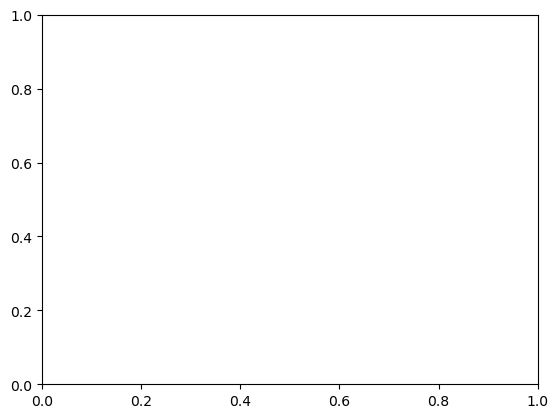

<Figure size 1000x400 with 0 Axes>

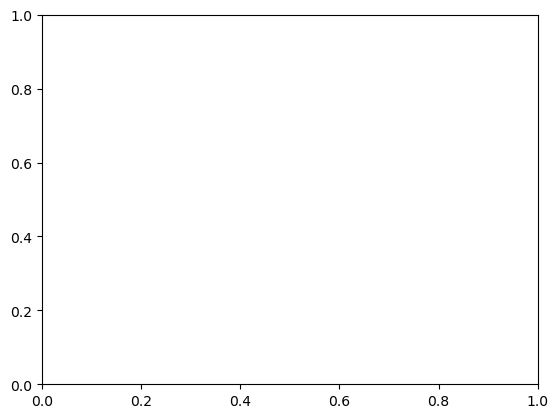

<Figure size 1000x400 with 0 Axes>

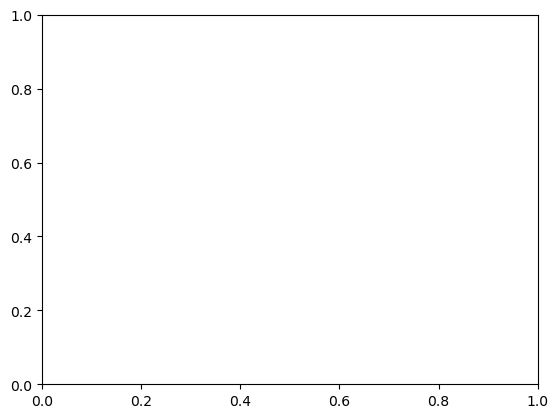

<Figure size 1000x400 with 0 Axes>

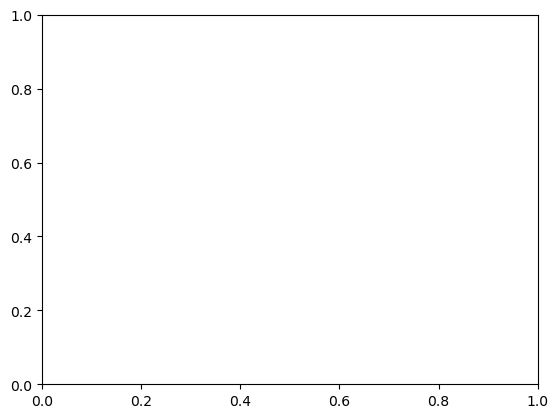

<Figure size 1000x400 with 0 Axes>

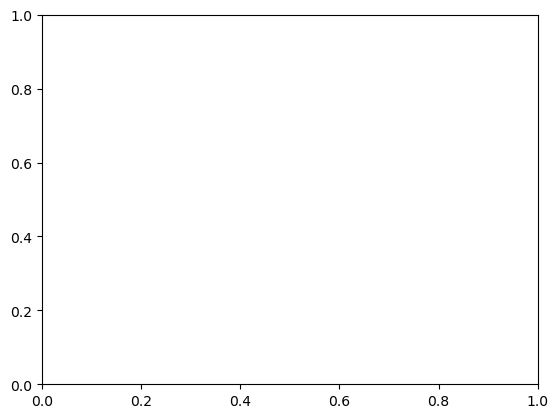

<Figure size 1000x400 with 0 Axes>

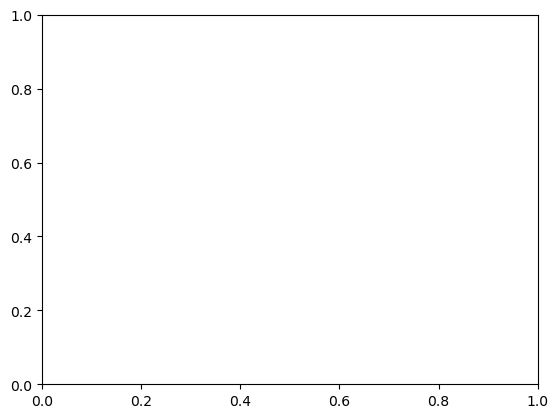

<Figure size 1000x400 with 0 Axes>

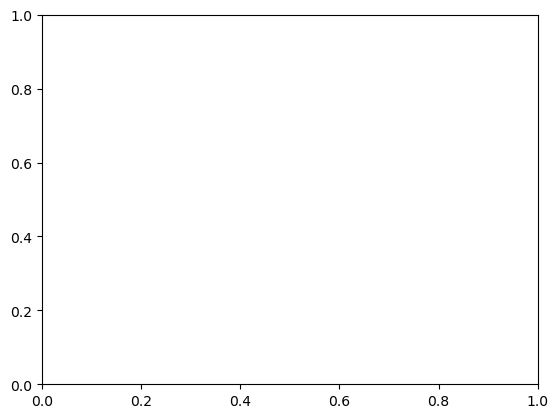

<Figure size 1000x400 with 0 Axes>

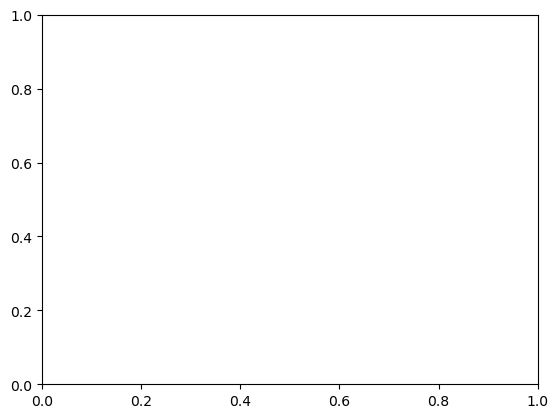

<Figure size 1000x400 with 0 Axes>

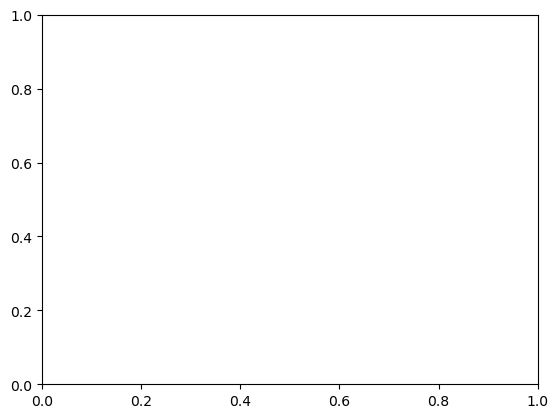

<Figure size 1000x400 with 0 Axes>

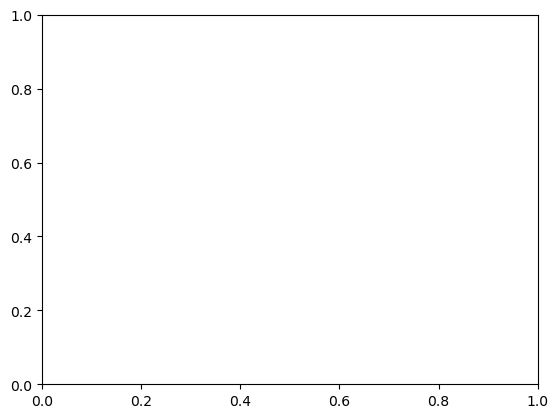

<Figure size 1000x400 with 0 Axes>

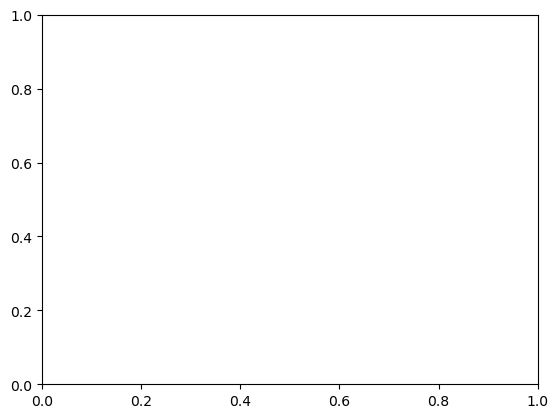

<Figure size 1000x400 with 0 Axes>

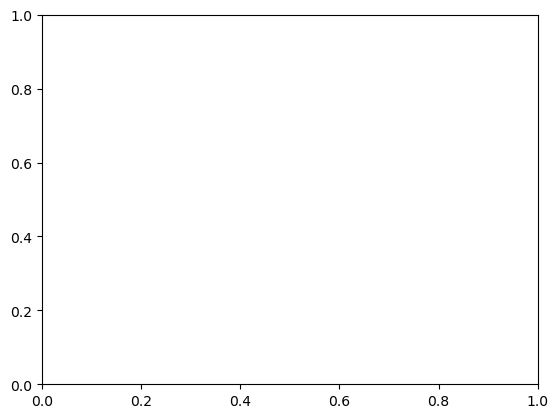

<Figure size 1000x400 with 0 Axes>

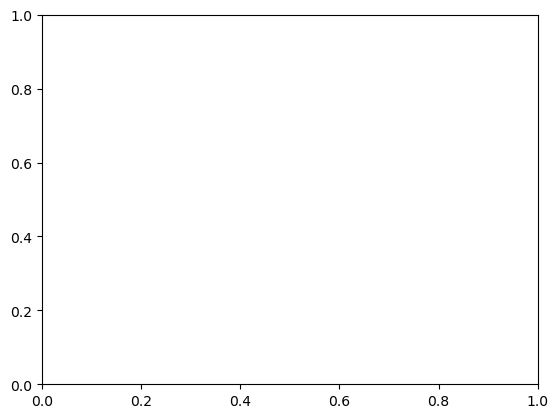

<Figure size 1000x400 with 0 Axes>

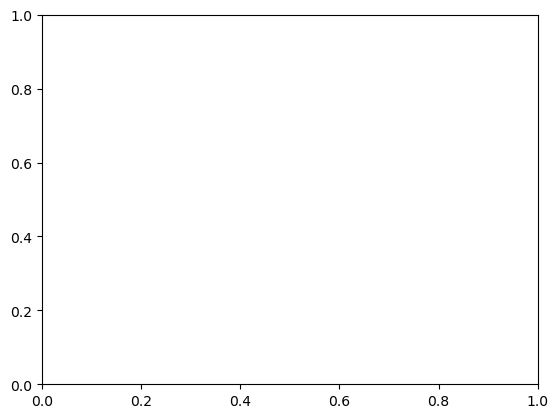

<Figure size 1000x400 with 0 Axes>

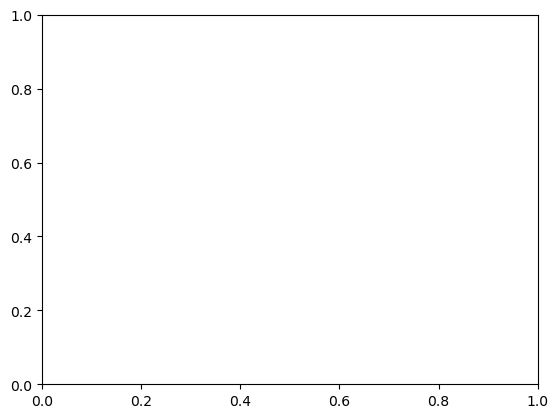

<Figure size 1000x400 with 0 Axes>

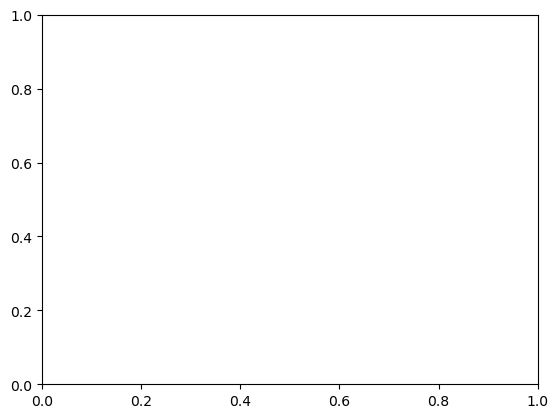

<Figure size 1000x400 with 0 Axes>

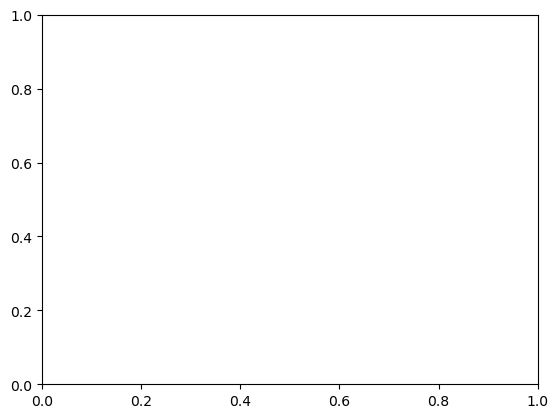

<Figure size 1000x400 with 0 Axes>

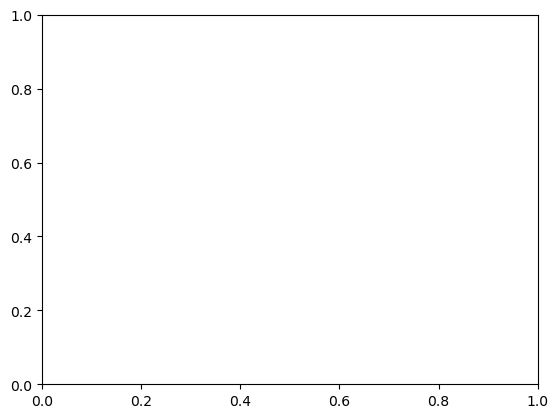

<Figure size 1000x400 with 0 Axes>

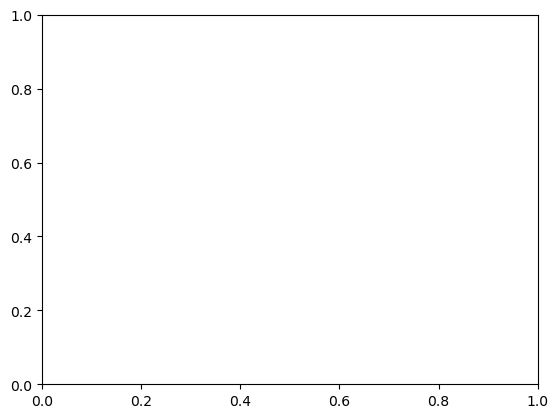

<Figure size 1000x400 with 0 Axes>

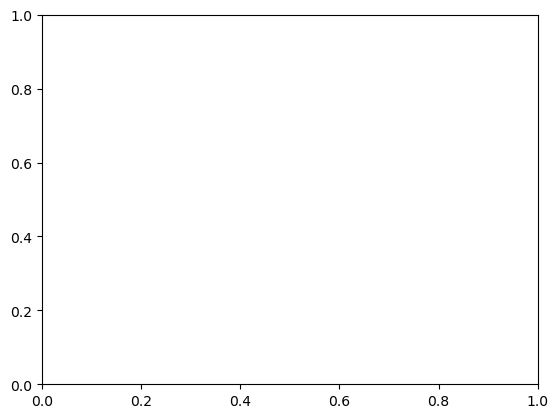

<Figure size 1000x400 with 0 Axes>

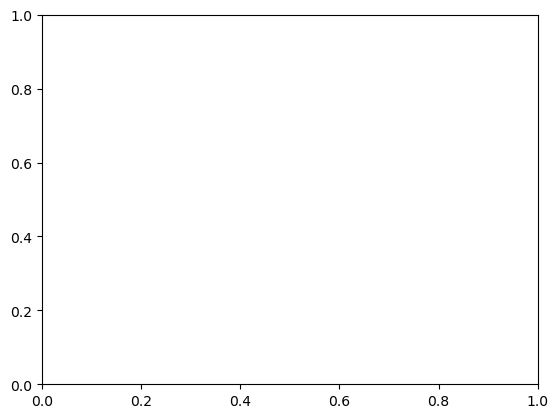

<Figure size 1000x400 with 0 Axes>

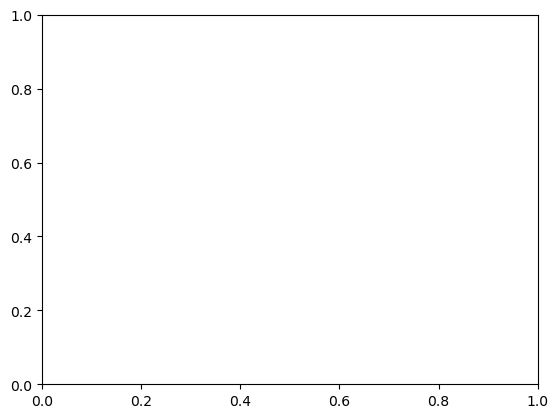

<Figure size 1000x400 with 0 Axes>

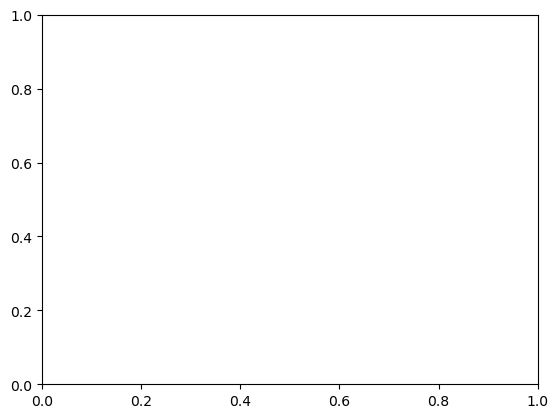

<Figure size 1000x400 with 0 Axes>

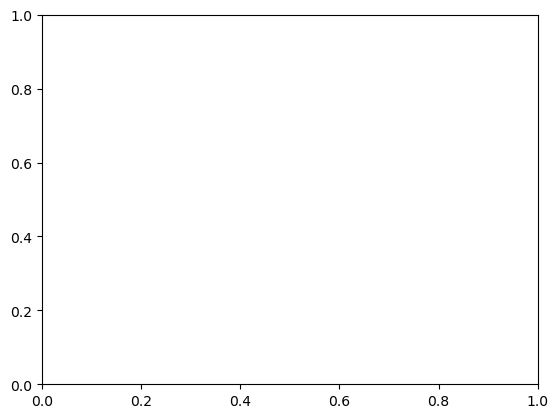

<Figure size 1000x400 with 0 Axes>

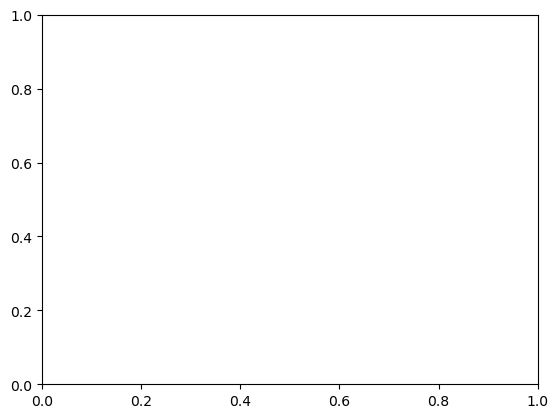

<Figure size 1000x400 with 0 Axes>

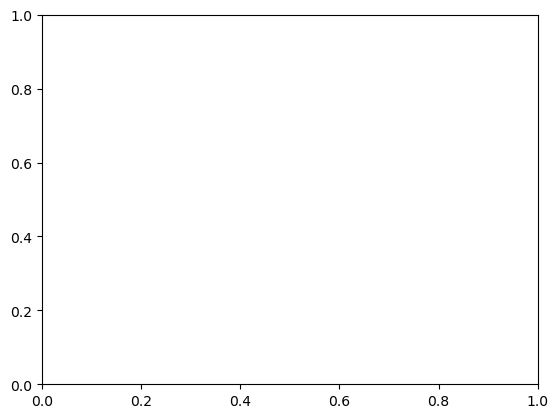

<Figure size 1000x400 with 0 Axes>

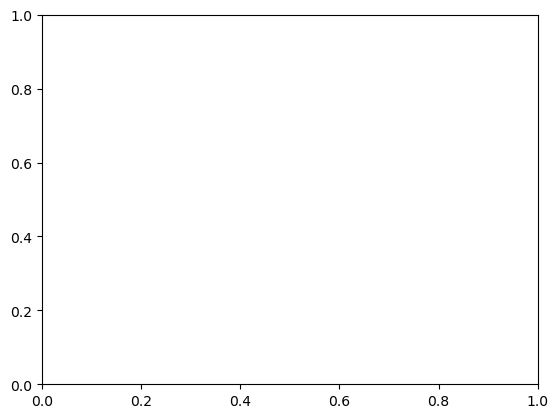

<Figure size 1000x400 with 0 Axes>

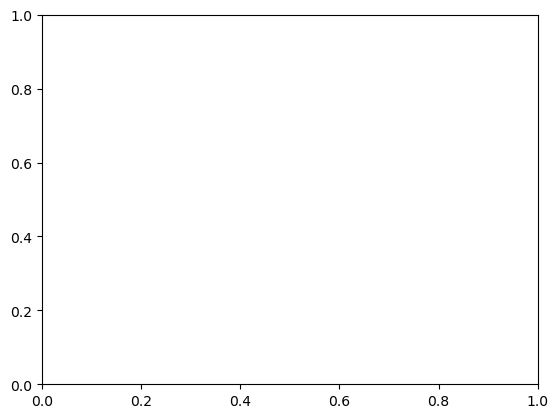

<Figure size 1000x400 with 0 Axes>

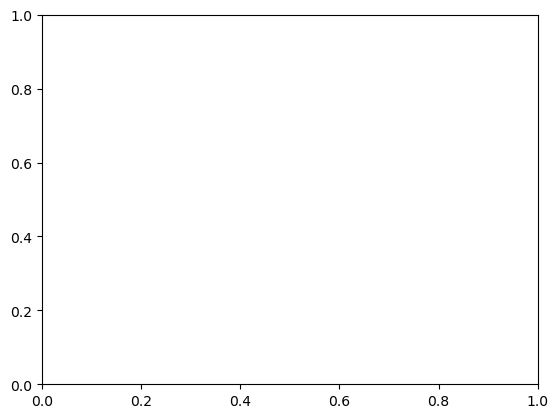

<Figure size 1000x400 with 0 Axes>

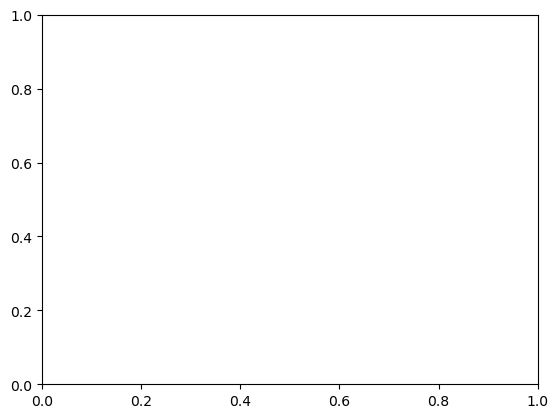

<Figure size 1000x400 with 0 Axes>

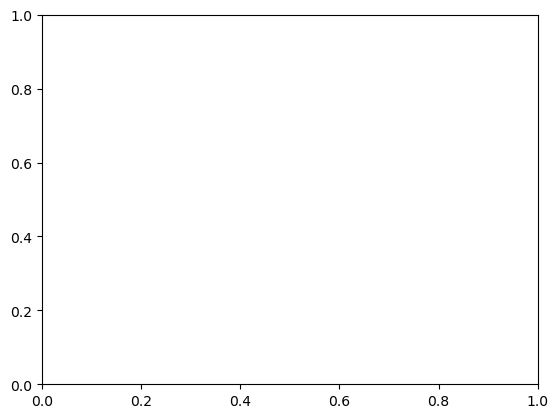

<Figure size 1000x400 with 0 Axes>

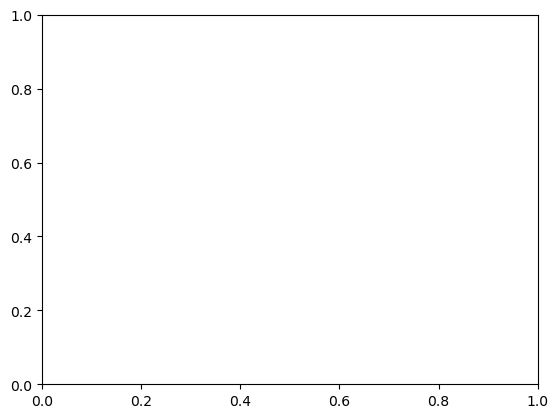

<Figure size 1000x400 with 0 Axes>

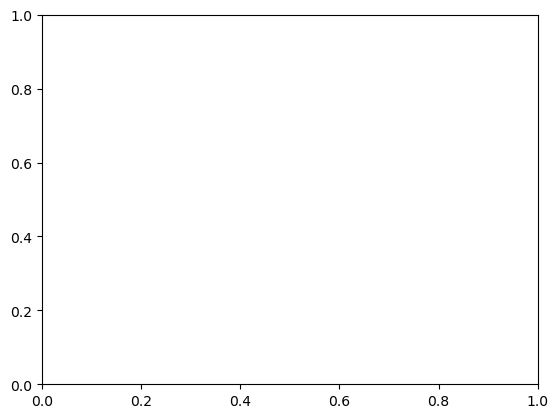

<Figure size 1000x400 with 0 Axes>

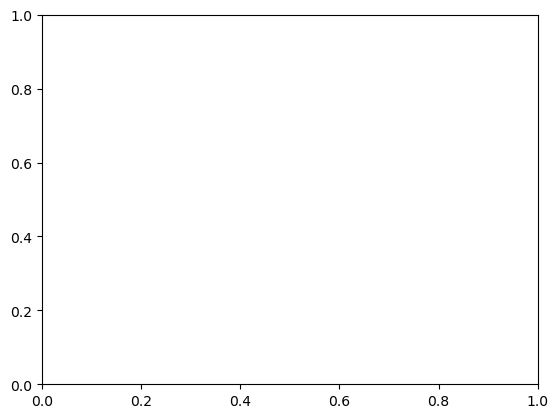

<Figure size 1000x400 with 0 Axes>

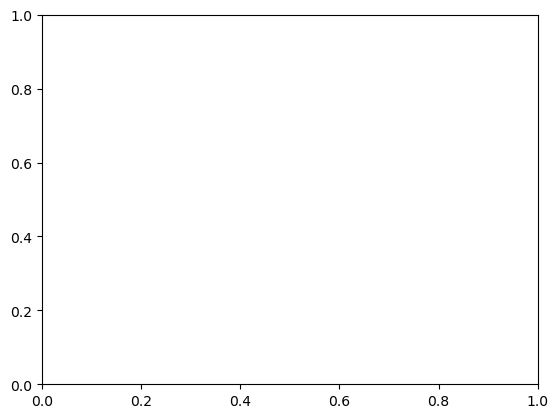

<Figure size 1000x400 with 0 Axes>

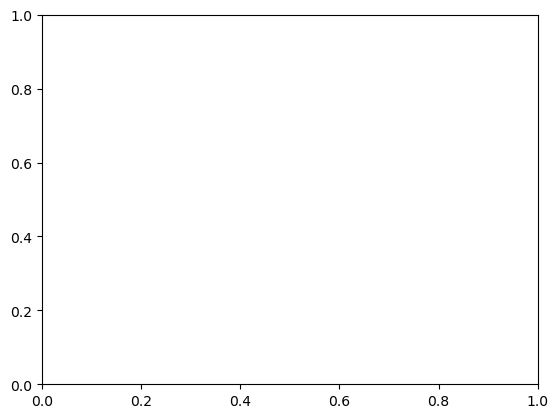

<Figure size 1000x400 with 0 Axes>

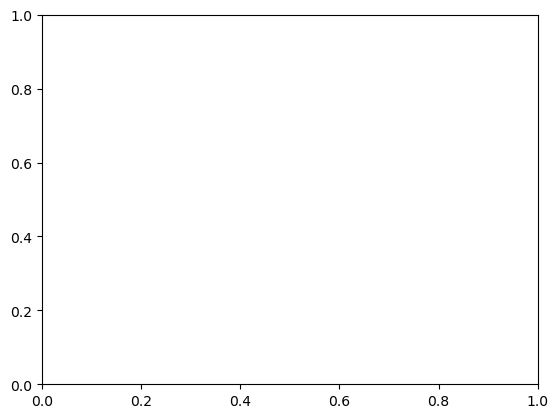

<Figure size 1000x400 with 0 Axes>

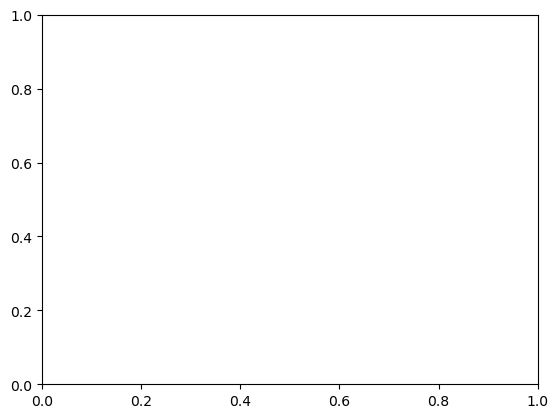

<Figure size 1000x400 with 0 Axes>

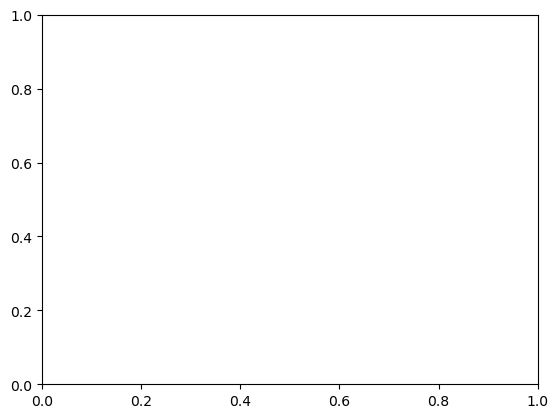

<Figure size 1000x400 with 0 Axes>

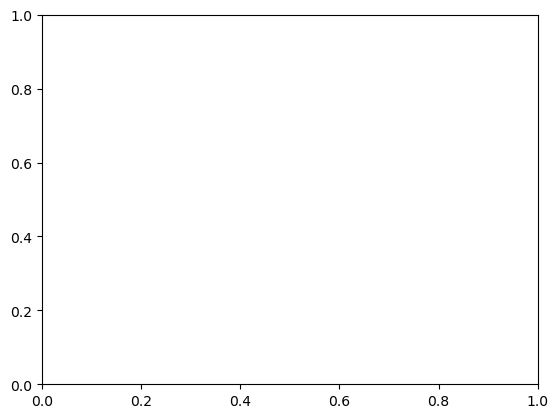

<Figure size 1000x400 with 0 Axes>

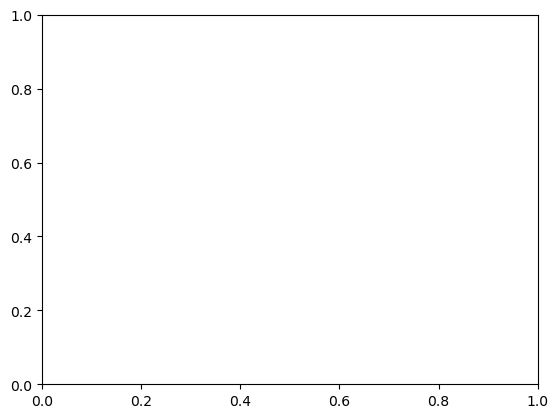

<Figure size 1000x400 with 0 Axes>

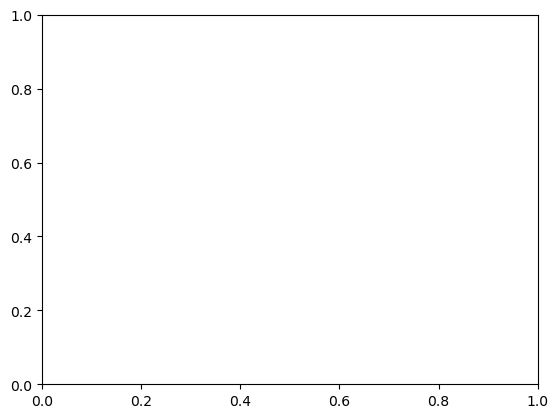

<Figure size 1000x400 with 0 Axes>

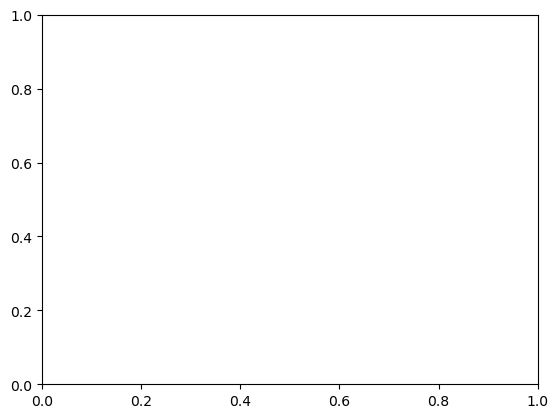

<Figure size 1000x400 with 0 Axes>

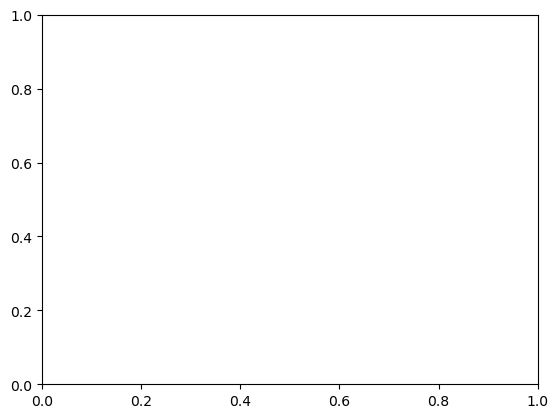

<Figure size 1000x400 with 0 Axes>

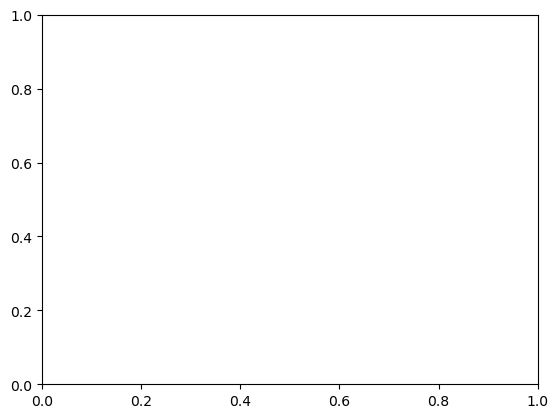

<Figure size 1000x400 with 0 Axes>

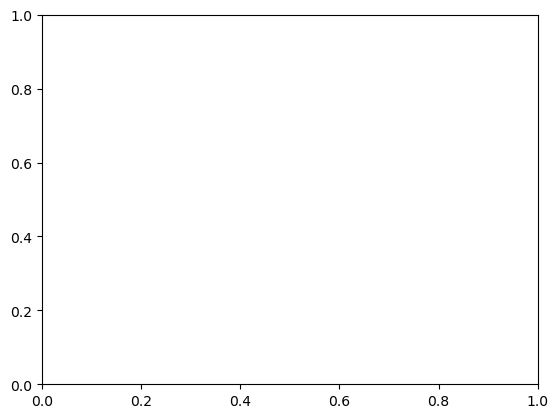

<Figure size 1000x400 with 0 Axes>

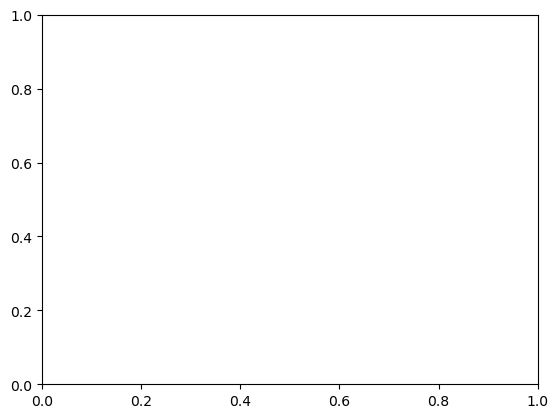

<Figure size 1000x400 with 0 Axes>

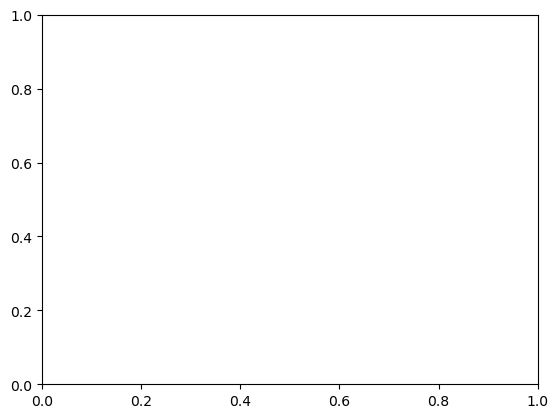

<Figure size 1000x400 with 0 Axes>

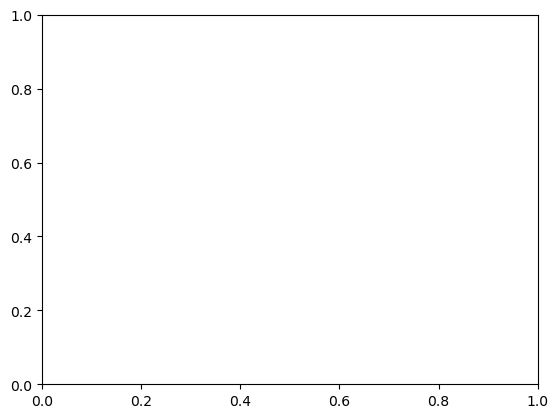

<Figure size 1000x400 with 0 Axes>

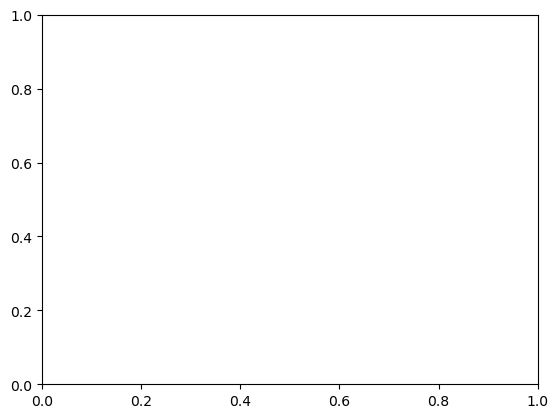

<Figure size 1000x400 with 0 Axes>

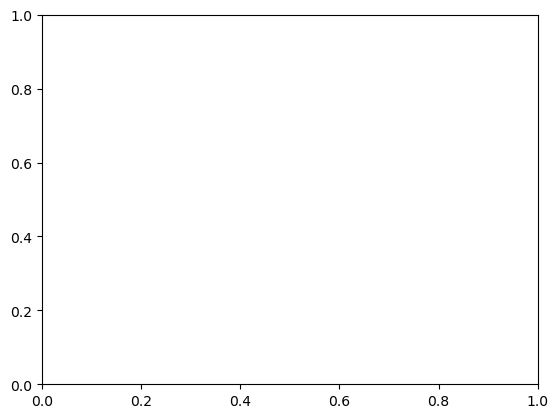

<Figure size 1000x400 with 0 Axes>

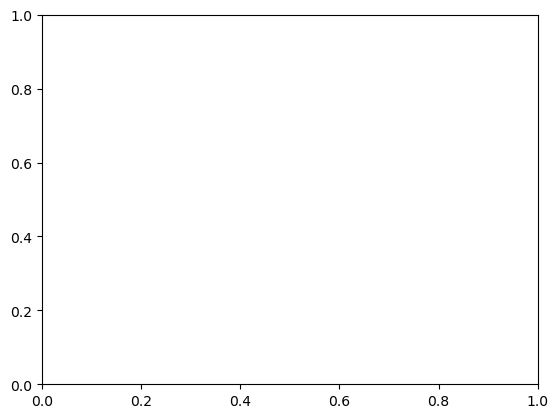

<Figure size 1000x400 with 0 Axes>

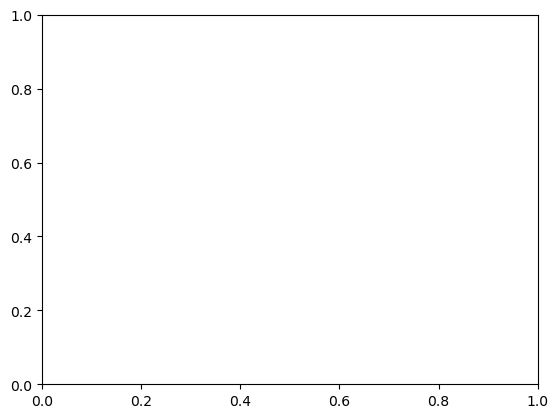

<Figure size 1000x400 with 0 Axes>

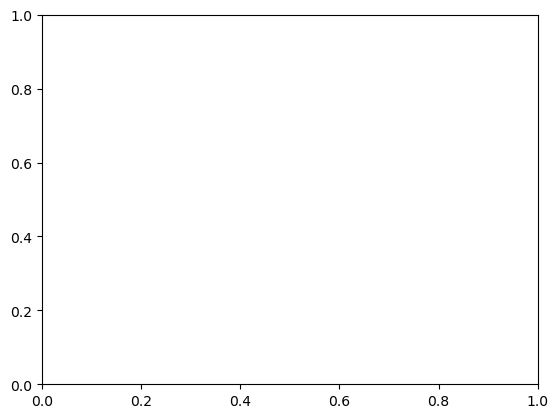

<Figure size 1000x400 with 0 Axes>

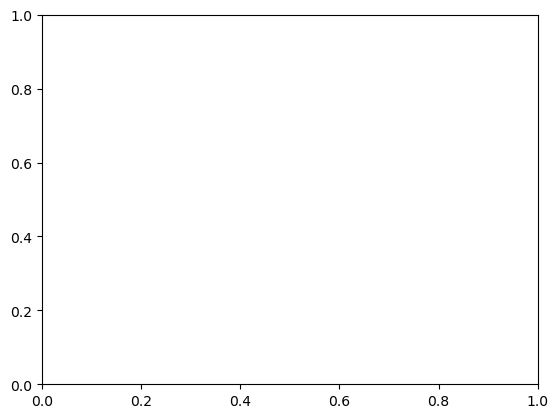

<Figure size 1000x400 with 0 Axes>

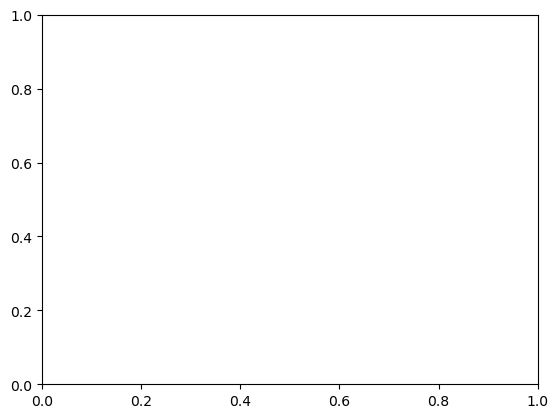

<Figure size 1000x400 with 0 Axes>

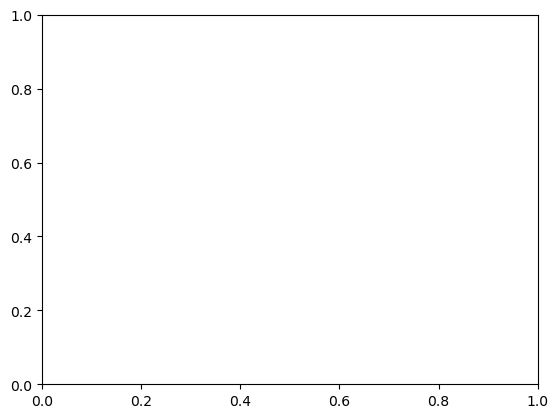

<Figure size 1000x400 with 0 Axes>

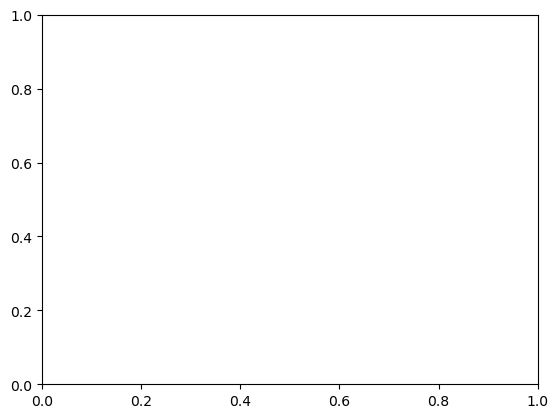

<Figure size 1000x400 with 0 Axes>

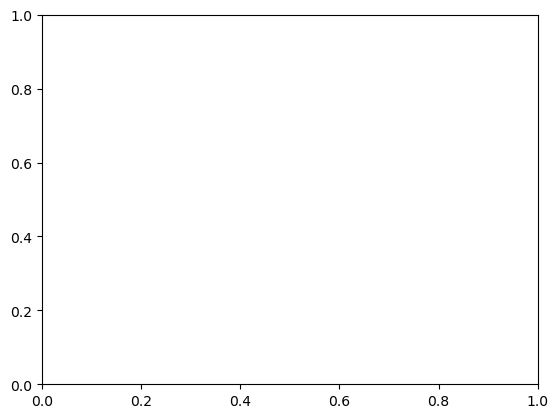

<Figure size 1000x400 with 0 Axes>

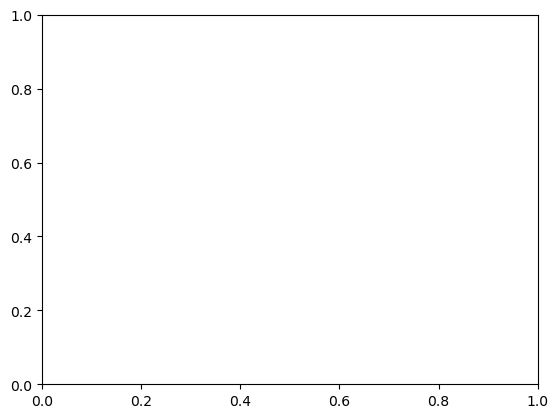

<Figure size 1000x400 with 0 Axes>

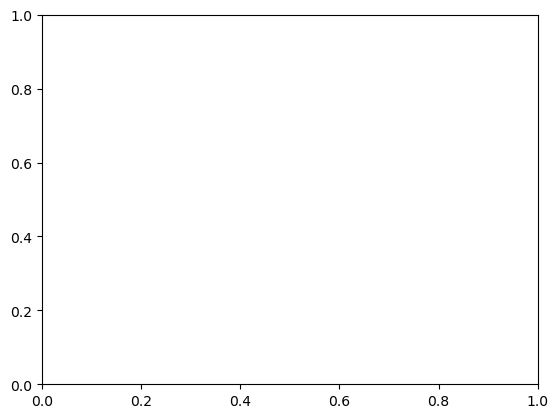

<Figure size 1000x400 with 0 Axes>

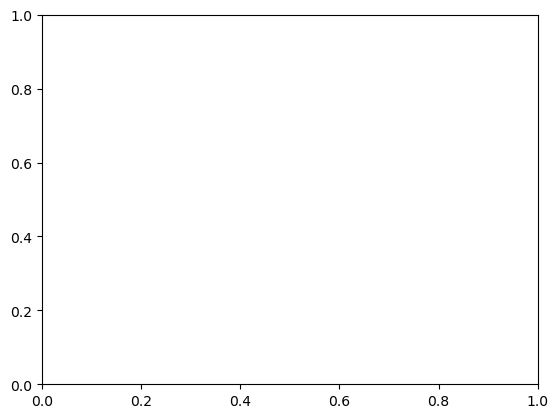

<Figure size 1000x400 with 0 Axes>

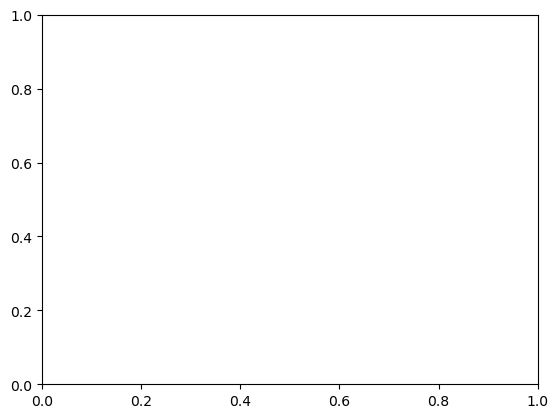

<Figure size 1000x400 with 0 Axes>

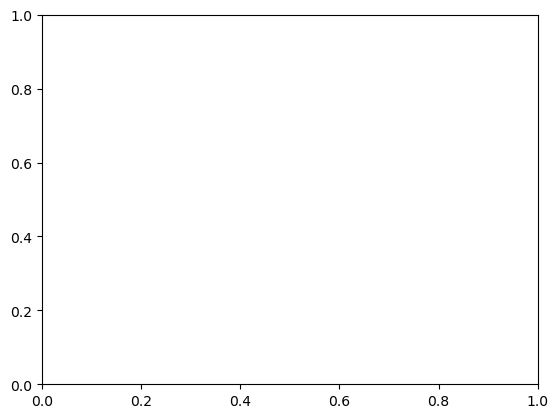

<Figure size 1000x400 with 0 Axes>

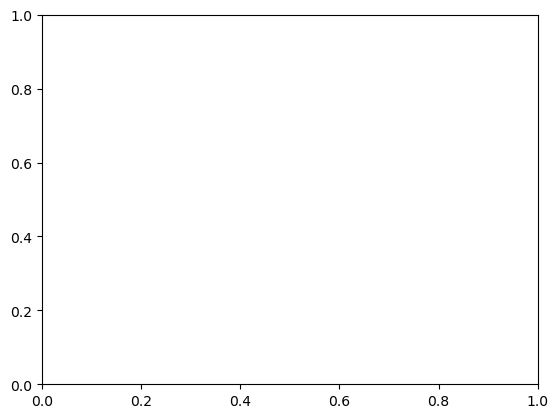

<Figure size 1000x400 with 0 Axes>

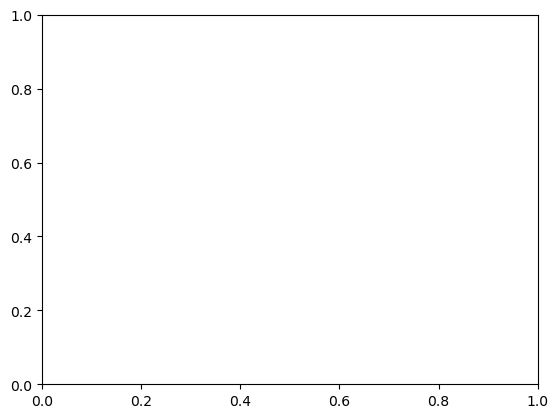

<Figure size 1000x400 with 0 Axes>

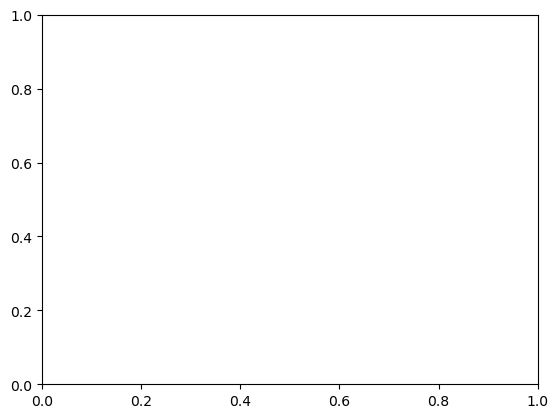

<Figure size 1000x400 with 0 Axes>

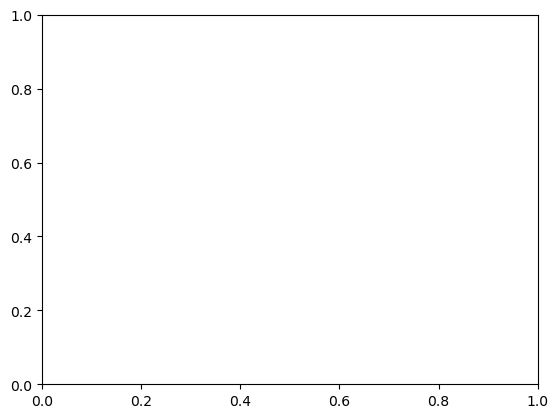

<Figure size 1000x400 with 0 Axes>

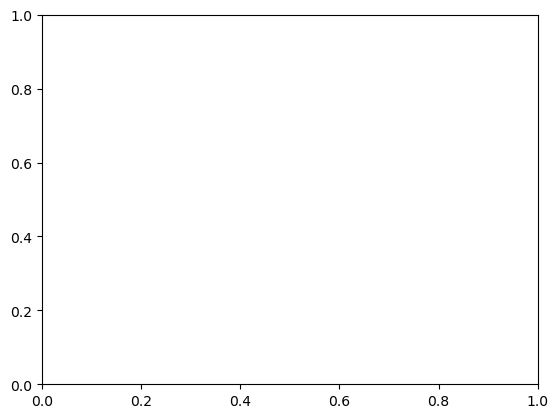

<Figure size 1000x400 with 0 Axes>

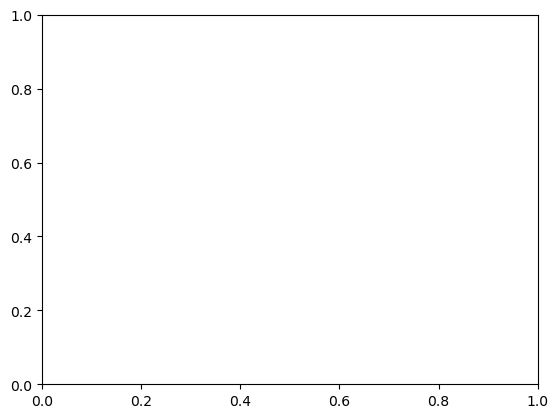

<Figure size 1000x400 with 0 Axes>

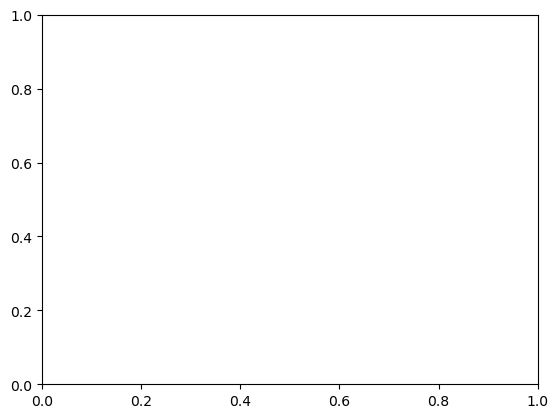

<Figure size 1000x400 with 0 Axes>

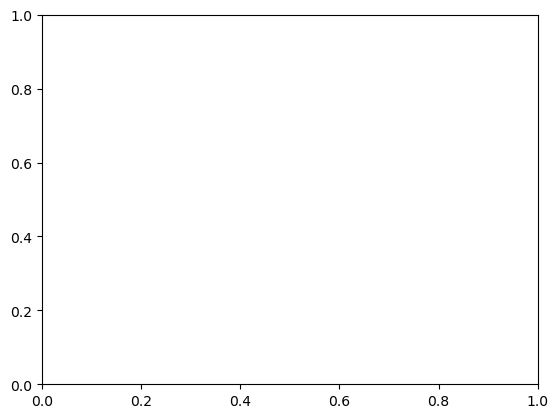

<Figure size 1000x400 with 0 Axes>

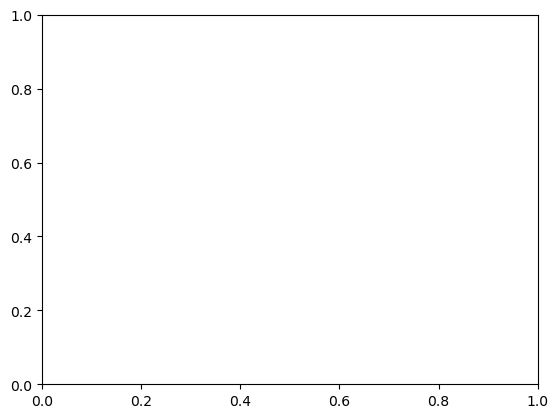

<Figure size 1000x400 with 0 Axes>

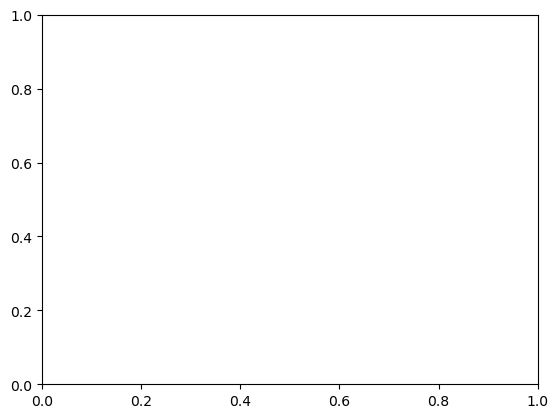

<Figure size 1000x400 with 0 Axes>

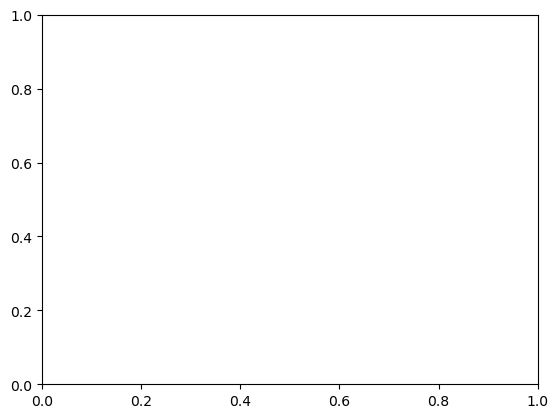

<Figure size 1000x400 with 0 Axes>

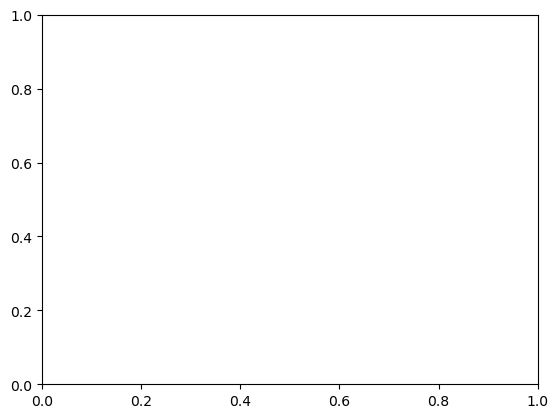

<Figure size 1000x400 with 0 Axes>

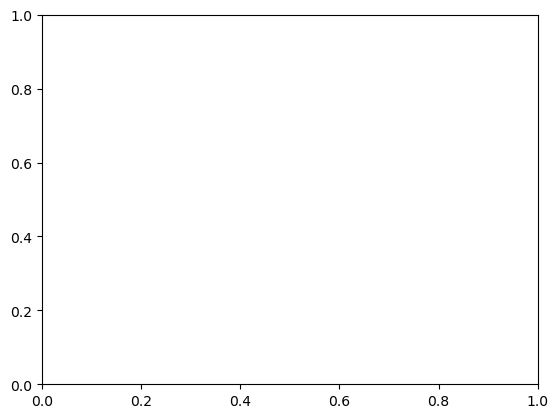

<Figure size 1000x400 with 0 Axes>

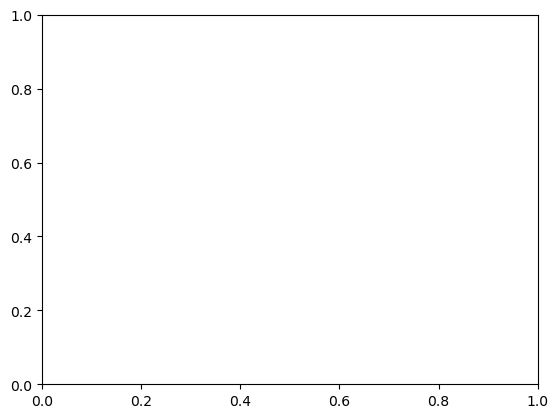

<Figure size 1000x400 with 0 Axes>

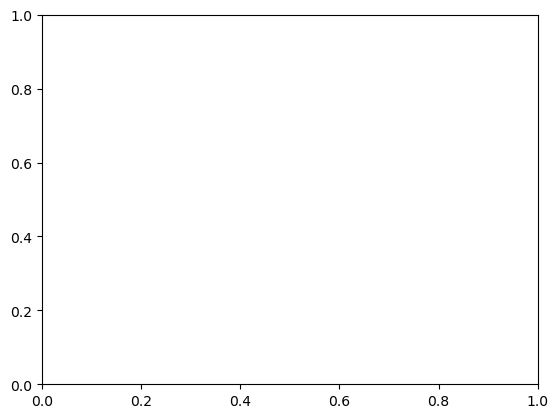

<Figure size 1000x400 with 0 Axes>

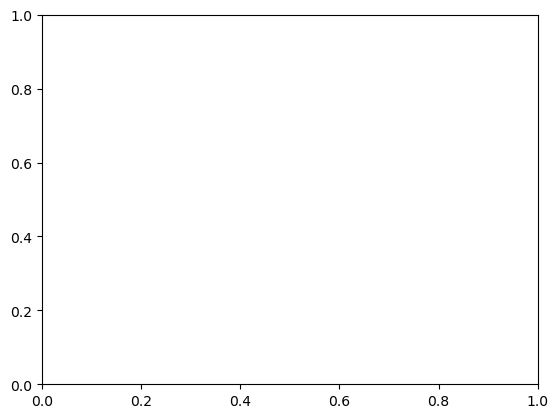

<Figure size 1000x400 with 0 Axes>

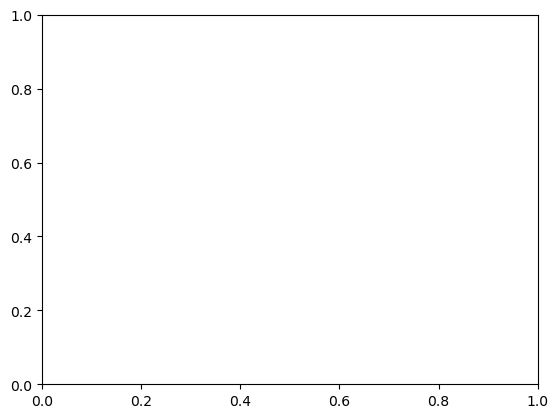

<Figure size 1000x400 with 0 Axes>

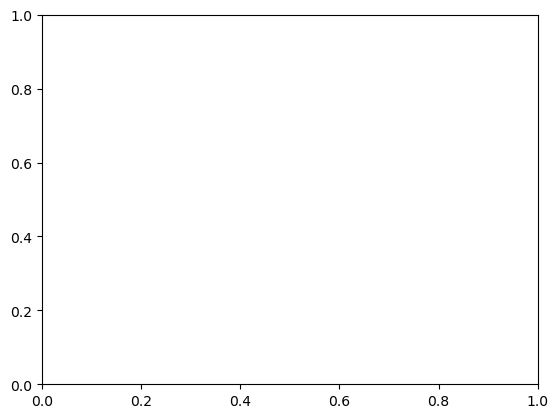

<Figure size 1000x400 with 0 Axes>

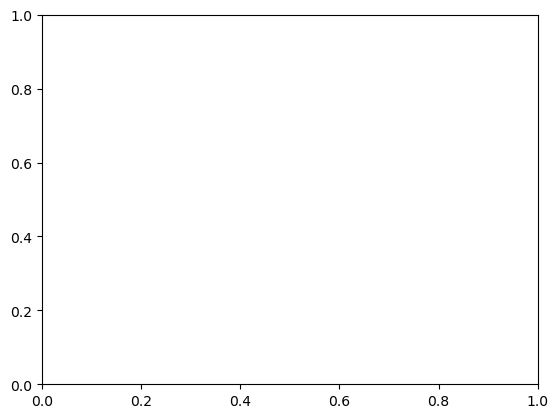

<Figure size 1000x400 with 0 Axes>

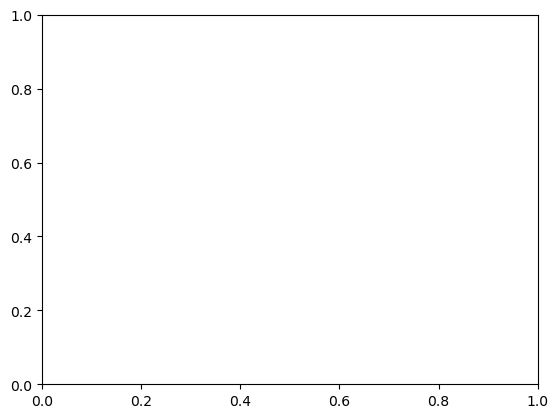

<Figure size 1000x400 with 0 Axes>

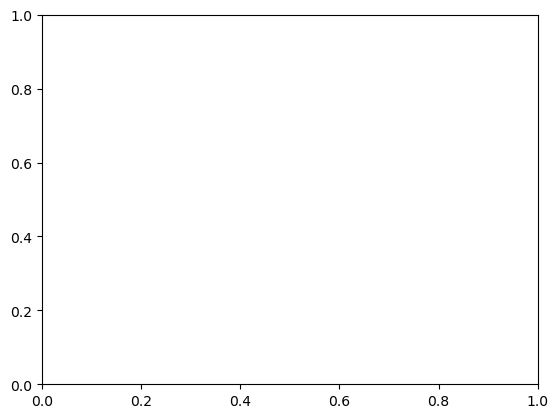

<Figure size 1000x400 with 0 Axes>

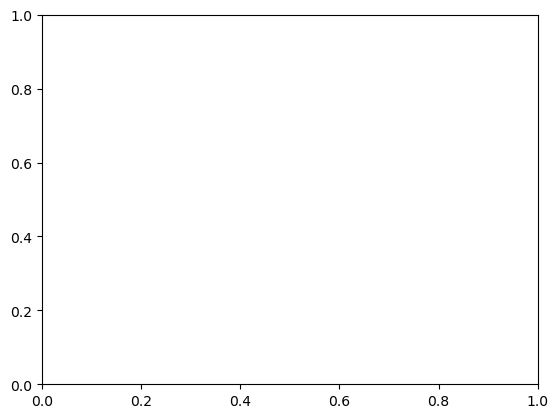

<Figure size 1000x400 with 0 Axes>

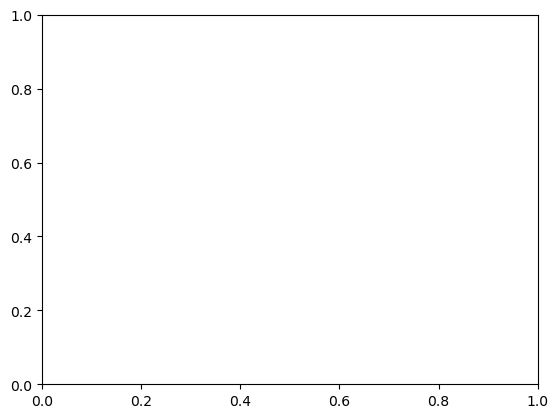

<Figure size 1000x400 with 0 Axes>

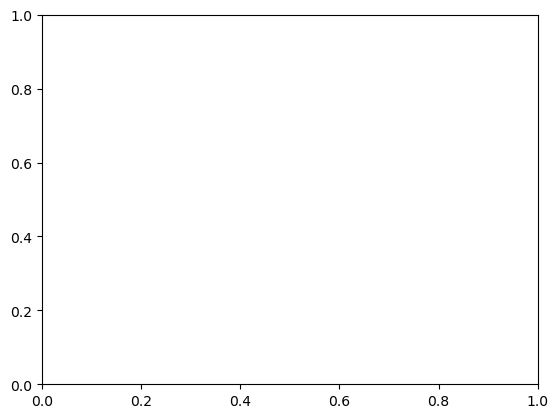

<Figure size 1000x400 with 0 Axes>

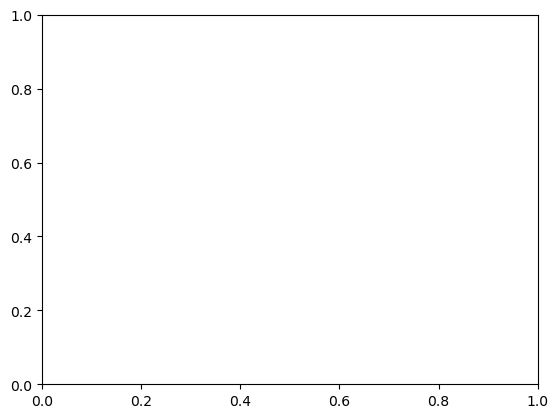

<Figure size 1000x400 with 0 Axes>

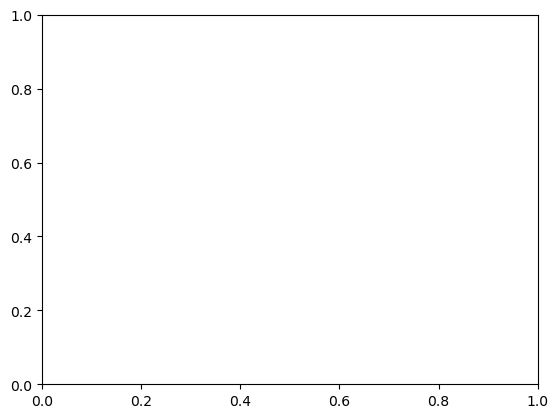

<Figure size 1000x400 with 0 Axes>

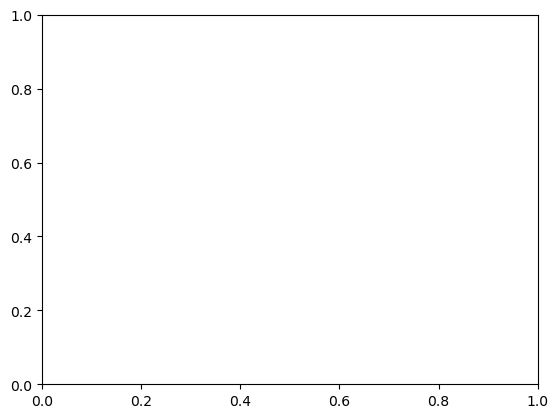

<Figure size 1000x400 with 0 Axes>

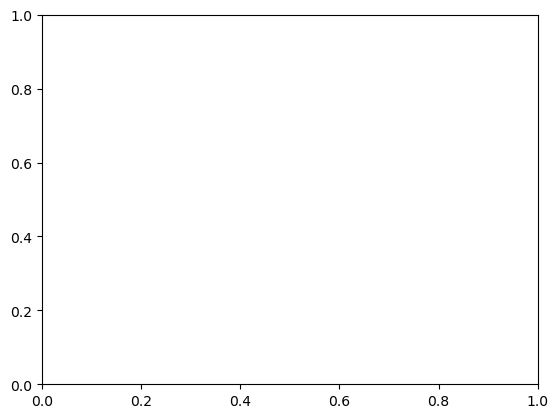

<Figure size 1000x400 with 0 Axes>

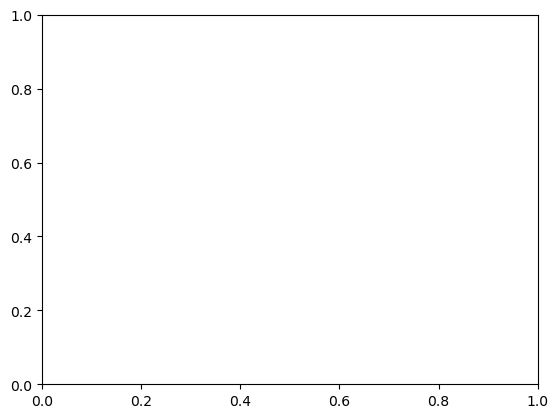

<Figure size 1000x400 with 0 Axes>

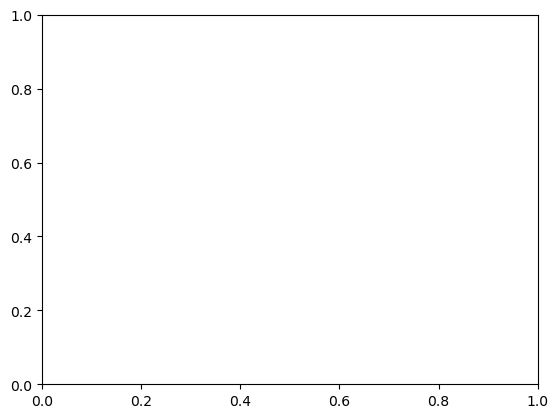

<Figure size 1000x400 with 0 Axes>

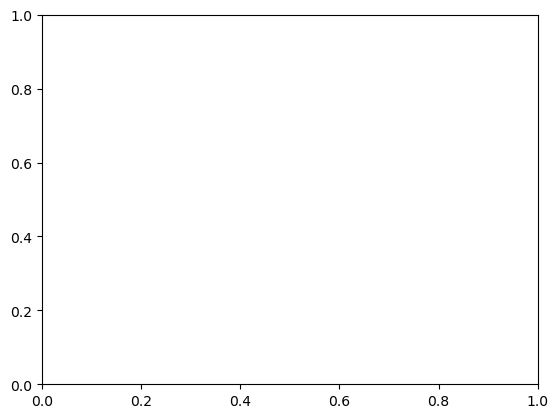

<Figure size 1000x400 with 0 Axes>

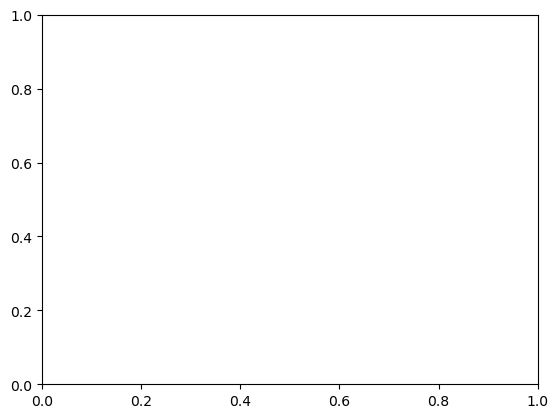

<Figure size 1000x400 with 0 Axes>

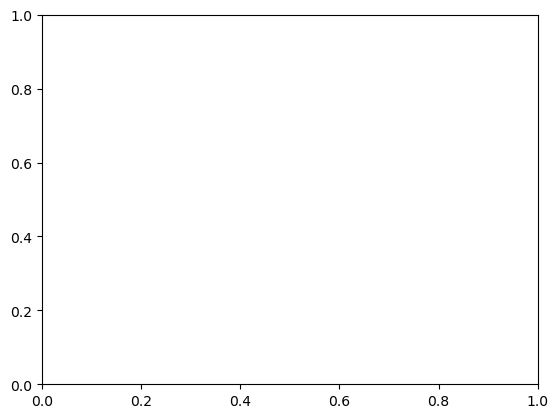

<Figure size 1000x400 with 0 Axes>

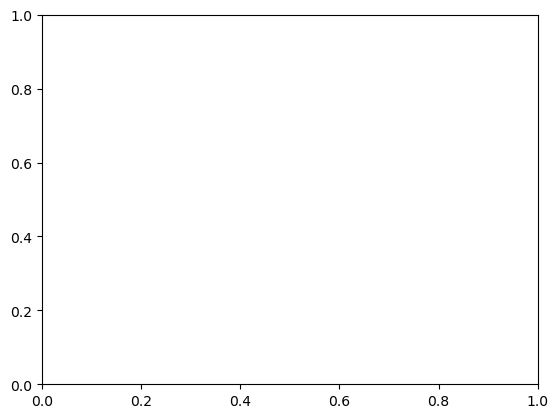

<Figure size 1000x400 with 0 Axes>

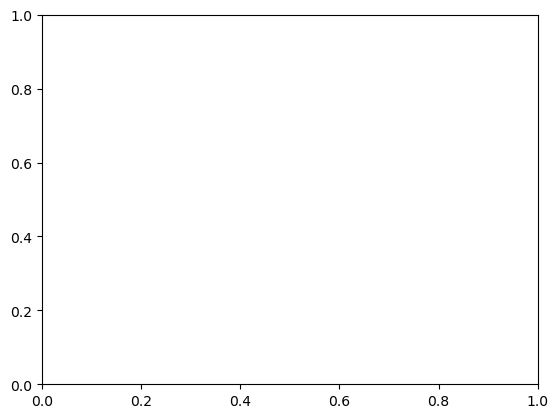

<Figure size 1000x400 with 0 Axes>

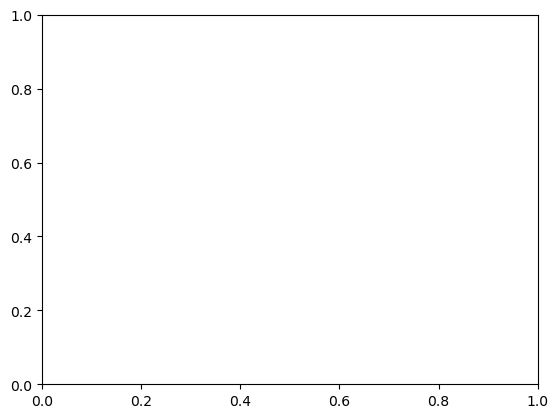

<Figure size 1000x400 with 0 Axes>

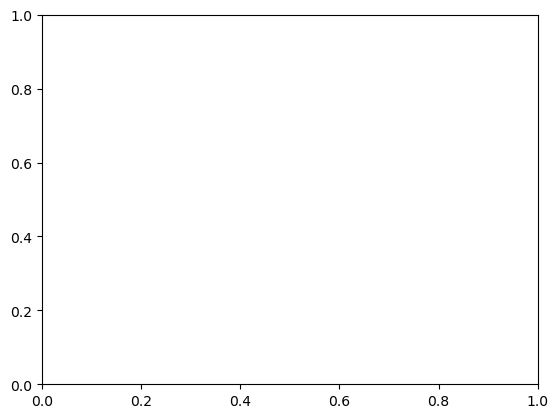

<Figure size 1000x400 with 0 Axes>

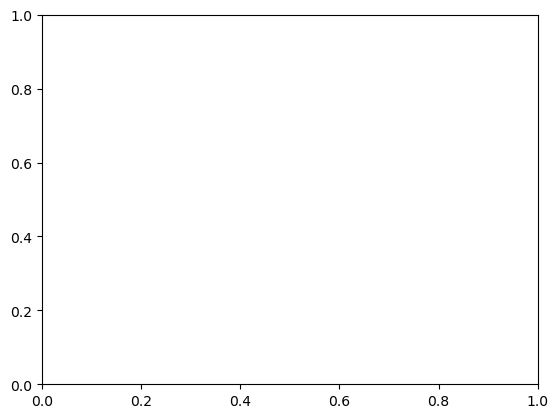

<Figure size 1000x400 with 0 Axes>

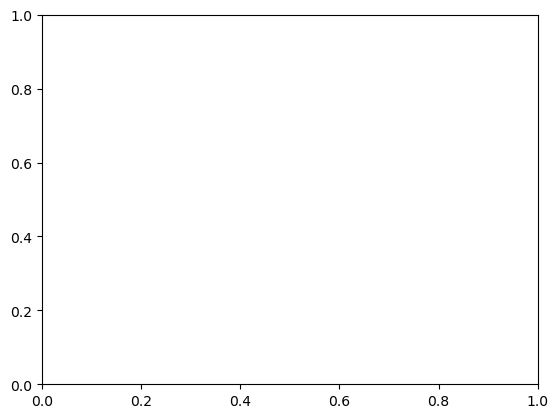

<Figure size 1000x400 with 0 Axes>

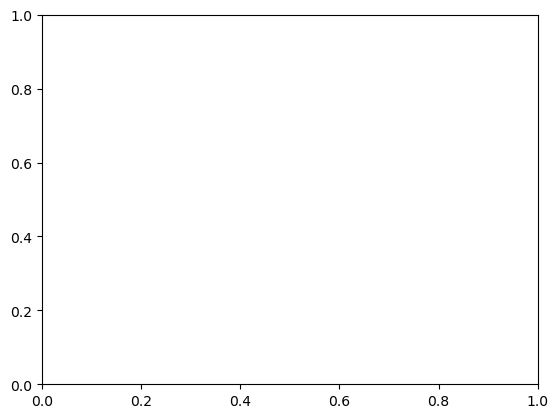

<Figure size 1000x400 with 0 Axes>

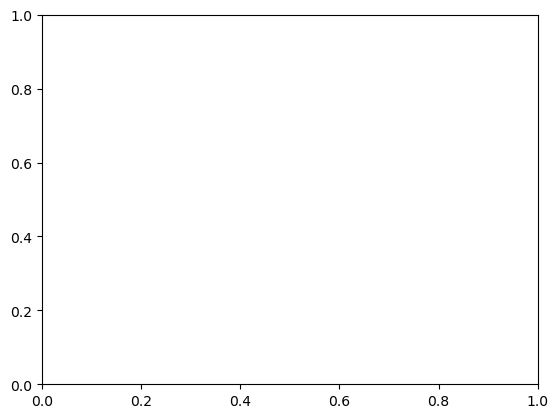

<Figure size 1000x400 with 0 Axes>

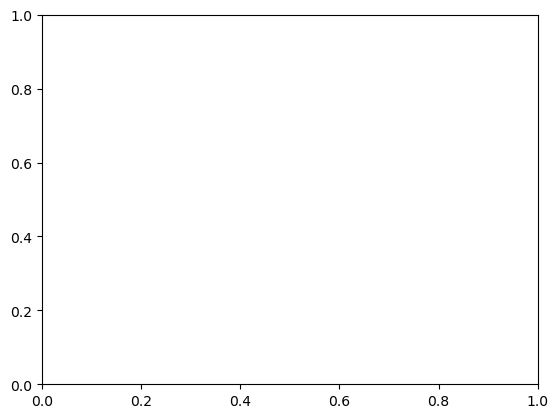

<Figure size 1000x400 with 0 Axes>

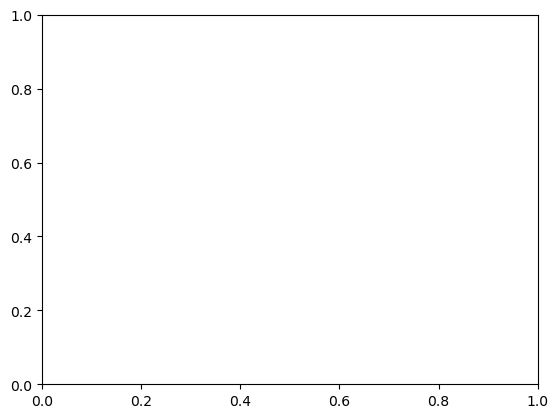

<Figure size 1000x400 with 0 Axes>

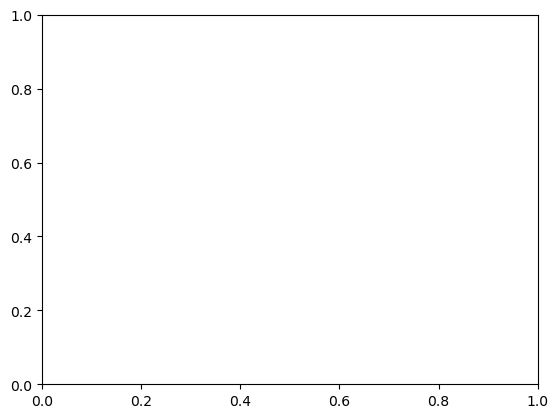

<Figure size 1000x400 with 0 Axes>

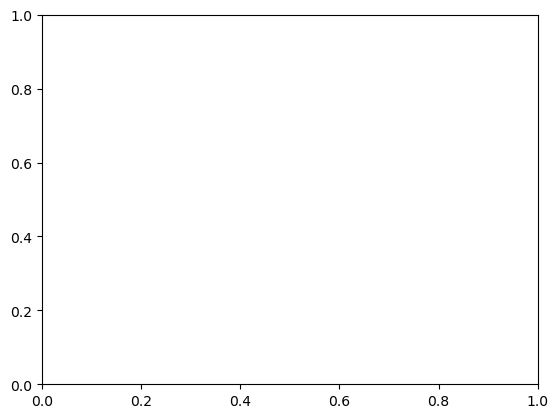

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [32]:
#Create report
def create_correction_report(filtered_list): #1
    
    #pri*nt(f"1: Create correction report")
    """This function creates a report with the corrected dataframes"""
    file_counter = 0
    genus, species_text, polarization, title = "", "", "", ""
    
    #make a list of all files with code
    files_with_code = []
    for code in codes:
        files_with_code += [file for file in filtered_list if code in file]

    #print(f"{files_with_code=}")
    
    #create a report in pdf with the original files
    
    #create report name
    original_data_file = os.path.join( report_path , f'original_data_{date}.pdf')

    with matplotlib.backends.backend_pdf.PdfPages(original_data_file) as pdf:
        
        for code in codes: 
            #Code by code we will plot all the spectra with the wsame name
            code_file_counter = 1

            #filters each file if the code is in its basename
            files_with_code = [file for file in filtered_list if code in file]
            
            #no results: continue
            if not files_with_code:
                continue
            #print(f"{files_with_code=}")
            
            #separates the files between l1050 files and CRAIC files
            CRAIC_files = [file for file in files_with_code if check_CRAIC_file(file)]
            #print(f"{CRAIC_files=}")
            
            l1050_files = [file for file in files_with_code if check_l1050_file(file)]
            #print(f"{l1050_files=}")

            #no spectroscopy files: continue
            if (not CRAIC_files) and (not l1050_files):
                continue
                
            x_label ="wavelength [nm]"
            y_label = "%R"

            if l1050_files: 
                
                plt.figure(figsize=(10, 4))
                # Create the figure and axes
                fig, ax = plt.subplots()
                draw_rainbow_background()
                
                for file in l1050_files:
                    
                    
                    #create spectrum
                    collection = Specimen_Collection.collection_lookup(code, collection_list)
                    genus,species = Specimen_Collection.genus_species_lookup(code, collection_list)
                    spectrum = Spectrum(file, collection_list,genus,species)
                    metadata = spectrum.get_metadata()
                    
                    
                    code_file_counter += 1
                    file_counter += 1
                    
                    label = str(Path(file).name).replace(".ASC","").replace(".txt","").replace(".csv","")
                    
                    #get df and metadata
                    df = spectrum.get_dataframe()
                    metadata = spectrum.get_metadata()
                    species = spectrum.get_species()
                    genus = spectrum.get_genus()
                    polarization = spectrum.get_polarization()
                    
                    if species == "na":
                        species_text = "sp."
                    else:
                        species_text = species
                        
                    #plots before changes
                    plt.plot(df["wavelength"], df[metadata["measuring_mode"]], color=get_contrasting_color(), label=label)
                    
                    
                    ### end for
    
                    # Labels and title

                if polarization == "na":
                    polarization = "O"
                title = f'1. L1050 raw. Code: {code}. {genus} {species_text}. {polarization} pol.'
                plt.xlabel(x_label)
                plt.ylabel(y_label)
                plt.title(title)
                plt.ylim(0,120)
                plt.legend()
                plt.grid(True)
                #plt.show()
                pdf.savefig()
                plt.close()
            
            ########################################################################################################################
            #CRAIC files 
            
            
            R_files = [file for file in CRAIC_files if "R" in file]
            L_files = [file for file in CRAIC_files if "L" in file]
            O_files = [file for file in CRAIC_files if ("L" not in file) & ("R" not in file)]

            CRAIC_pols = [R_files,L_files,O_files]

            
            
            for i, pol_file in enumerate(CRAIC_pols):
                
                plt.figure(figsize=(10, 4))
                # Create the figure and axes
                fig, ax = plt.subplots()
                draw_rainbow_background()

                pol = ""
                
                for file in pol_file:
                    #create spectrum
                    collection = Specimen_Collection.collection_lookup(code, collection_list)
                    genus,species = Specimen_Collection.genus_species_lookup(code, collection_list)

                    #print(f"{genus=} {species=}")
                    spectrum = Spectrum(file, collection_list,genus,species)
                    metadata = spectrum.get_metadata()
                    pol = metadata["polarization"]
                    label = code +" "+ pol
                    code_file_counter += 1
                    file_counter += 1
        
                    #get df and metadata
                    df = spectrum.get_dataframe()
                    metadata = spectrum.get_metadata()
                    species = spectrum.get_species()
                    genus = spectrum.get_genus()
                    polarization = spectrum.get_polarization()
                    
                    if species == "na":
                        species_text = "sp"
                    else:
                        species_text = species
                        
                    #plots before changes
                    plt.plot(df["wavelength"], df[metadata["measuring_mode"]], color=get_contrasting_color(), label=label)
                    
                    ### end for
                if polarization == "na":
                    polarization = "O"
                title = f'1. CRAIC raw. Code: {code}. {genus} {species_text}. {pol} pol.'
                plt.xlabel(x_label)
                plt.ylabel(y_label)
                plt.title(title)
                plt.ylim(0,120)
                plt.legend()
                plt.grid(True)
                #plt.show()
                pdf.savefig()
                plt.close()
                
        #end for code in codes: 
            
    ####################################################################################################################################}
    #CORRECTIONS
    
    #create report name
    file_counter = 0
    corrected_data_file = os.path.join( report_path , f'corrected_data_{date}.pdf')
    jump_corrected_dict = []
    average_polarized_dict = []
    #pri*nt(f"1: Create corrected_data_file report")

    with matplotlib.backends.backend_pdf.PdfPages(corrected_data_file) as pdf:
        
        for code in codes:
            
            
            #pri*nt(f"{codes=}")
            #Code by code we will plot all the spectra with the wsame name
            code_file_counter = 1
            #constants
            x_label ="wavelength [nm]"
            y_label = "%R"

            #filters each file if the code is in its basename
            files_with_code = [file for file in filtered_list if code in file]
            #print(f"{files_with_code=}")
            
            #separates the files between l1050 files and CRAIC files
            CRAIC_files = [file for file in files_with_code if check_CRAIC_file(file)]
            #print(f"{CRAIC_files=}")
            
            l1050_files = [file for file in files_with_code if check_l1050_file(file)]
            #print(f"{l1050_files=}")
            
            if l1050_files:
                
                #creates a figure to plot 
                plt.figure(figsize=(10, 4))
                # Create the figure and axes
                fig, ax = plt.subplots()
                draw_rainbow_background()
                #for each l1050 file 
                
                for file in l1050_files:

                    #Get info for each file
                    file = CRAIC_files[0]
                    collection = Specimen_Collection.collection_lookup(code, collection_list)
                    genus,species = Specimen_Collection.genus_species_lookup(code, collection_list)
                    spectrum = Spectrum(file, collection_list,genus,species)
                    metadata = spectrum.get_metadata()

                    #get df and metadata
                    df = spectrum.get_dataframe()
                    metadata = spectrum.get_metadata()
                    species = spectrum.get_species()
                    genus = spectrum.get_genus()
                    polarization = spectrum.get_polarization()
                    
                    #Initialize corrected_dict
                    corrected_dict = {}
                    
                    corrected_dict = l1050_get_corrected_dataframe_and_info(file, code, collection_list, code_file_counter)
    
                    #append files to the jump_corrected_dict to be used later
                    jump_corrected_dict.append(corrected_dict) #declared at the beginning of this method
    
                    #pri*nt(f"{corrected_dict["df_corrected"]=}")
                    #saves the corrected file 
                    basename = corrected_dict["file"]
                    label = str(Path(file).name).replace(".ASC","").replace(".txt","").replace(".csv","")
                    
                    #pri*nt(f"{corrected_dict["df"]}")
                    save_corrected_df(folder=corrected_files, basename = Path(file).name, metadata=corrected_dict["metadata"], dataframe=corrected_dict["df"])
                    save_corrected_plot(folder = corrected_files, basename = Path(file).name,metadata = dict["metadata"], dataframe=corrected_dict["df"], label = label )
                    
                    ### end for
                plt.title(f'1. L1050. Jump Correction. {code}')
                plt.xlabel(x_label)
                plt.ylabel(y_label)
                plt.ylim(0,120)
                plt.legend()
                plt.grid(True)
                #plt.show()
                pdf.savefig()
                plt.close()

            
            #Now for CRAIC files, these are separated between R, L and O polarization
            #and these are not corrected for jumps, only pri*nted
            code_file_counter = 1
            
            #creates a figure to plot
            if CRAIC_files:
                code_file_counter += 1
                
                #Get info for each file
                file = CRAIC_files[0]
                collection = Specimen_Collection.collection_lookup(code, collection_list)
                genus,species = Specimen_Collection.genus_species_lookup(code, collection_list)
                spectrum = Spectrum(file, collection_list,genus,species)
                metadata = spectrum.get_metadata()

                #check polarizations
                right_pol= [file for file in files_with_code if "R" in Path(file).name ]
                left_pol= [file for file in files_with_code if "L" in Path(file).name ]
                no_polarization = [file for file in files_with_code if "O" in Path(file).name]

                if (not right_pol) or (not left_pol):
                    continue
                #pri*nt("2. CRAIC_get_average_polarizations")
                
                right_average_df, left_average_df, no_polarization_average_df = CRAIC_get_average_polarizations(CRAIC_files, code)
                #print(f"{right_average_df=}")
                #print(f"{left_average_df=}")
                right_pol_path = corrected_files_path / "R"
                left_pol_path = corrected_files_path / "L"

                plt.figure(figsize=(10, 4))
                # Create the figure and axes
                
                draw_rainbow_background()

                #set polarization to R and save
                metadata["polarization"] = "R"
                basename = code+ "_R.csv"
                
                save_corrected_df(folder = right_pol_path, basename = basename ,metadata = metadata,dataframe = right_average_df )
                
                label = code + "_R"
                
                save_corrected_plot(folder = right_pol_path, basename = basename,metadata = metadata,dataframe = right_average_df, label = label )
                

                #set polarization to L and save
                metadata["polarization"] = "L"
                basename = code+ "_L.csv"
                save_corrected_df(folder = left_pol_path, basename = basename ,metadata = metadata,dataframe = left_average_df )

                label = (code + "_L")
                save_corrected_plot(folder = left_pol_path, basename = basename ,metadata = metadata,dataframe = left_average_df, label = label )

                
                #get average polarizations
                    
                    
                #get total average_df
                #pri*nt("2. CRAIC_get_total_average_dataframe")
                total_average_df = CRAIC_get_total_average_dataframe(right_average_df, left_average_df)
                
                #get corrected total average
                #pri*nt("2. CRAIC_correct_total_average")
                corrected_total_average_df = CRAIC_correct_total_average(total_average_df)

                #p*rint(f"{corrected_total_average_df=}")
                

                basename = code + ".csv"

                
                
                #saves the corrected file save_corrected_df(folder, basename, metadata, dataframe)
                #pri*nt("2. save_corrected_df")
                #set polarization to O and save
                metadata["polarization"] = "O"
                basename = code +".csv"
                save_corrected_df(folder = corrected_files_path, basename = basename,metadata = metadata,dataframe = corrected_total_average_df )
                label = (code) + "_O"
                save_corrected_plot(folder = corrected_files_path, basename = basename,metadata = metadata,dataframe = corrected_total_average_df, label = label )
                
                plt.title(f'1. CRAIC. R, L and total. Code {code}. {genus} {species}')
                plt.xlabel(x_label)
                plt.ylabel(y_label)
                plt.ylim(0,120)
                plt.legend()
                plt.grid(True)
                #plt.show()
                pdf.savefig()
                plt.close()
                ### end for
                
           
create_correction_report(non_empty_files)

In [33]:
var_dataframes = None
def average_l1050_files(file_list, code_set, directory, pdf):

    #parent directory and save_directory
    jump_corrected_path = os.path.join( directory , "jump_corrected_files")
    save_directory = os.path.dirname(jump_corrected_path)
    
    #p*rint(f"{save_directory=}")
    file_counter = 0

    #Look for every available code in the folder
    for code in code_set:
        #pr*int(f"{code=}") 
        
        dataframes = []
        files_with_code =[file for file in file_list if code in Path(file).name] #gets each file that starts with the code provided
        #pri*nt(files_with_code)
        metadata, df = None, None
        
        # Read each file, create dataframes, and plot them
        for file_path in file_list:
            #pri*nt(f"{file_path=}")
            #create spectrum object
            collection = Specimen_Collection.collection_lookup(code, collection_list)
            spectrum = Spectrum(file_path, collection_list)
            
            #get metadata and dataframe
            #pri*nt("Reading file...")
            #pri*nt("Getting metadata and dataframe...")
            metadata, df = spectrum.get_metadata(), spectrum.get_dataframe()

            #metadata info
            measuring_mode = metadata["measuring_mode"]
            sample_name = metadata["code"] 

            # Read the file into a pandas DataFrame
            #convert columns to float
            #pri*nt("Converting columns to float...")
            df['wavelength'] = df['wavelength'].astype(float)
            df[measuring_mode] = df[measuring_mode].astype(float)
            
            #pri*nt("Dropping index...")
            try:
                df = df.drop("index", axis = 1)
            except Exception as e:
                #pri*nt (e)
                pass
            #pri*nt("pri*nting head...")
            
            #pri*nt(df.head())
            # Append the dataframe to the list if not empty
            if not df.empty and not None and len(df) != 0:
                dataframes.append(df) 
            
        # Calculate the average of all dataframes ignore empty ones
        # average l1050 files and polarization_sum CRAIC files
        #pri*nt("elements")
        
        #pri*nt(dataframes)
        #pri*nt(f"{len(dataframes)=}")

        #If there are no dataframes, continue
        if len(dataframes) == 0:
            continue
        #If there is only one 
        elif len(dataframes) == 1:
            average_df = dataframes[0]
            std_dev_df = pd.DataFrame([])
            std_dev_df["wavelength"] = []
            std_dev_df["%R"] =[]
        #If there are many
        else:
            average_df = pd.concat(dataframes).groupby('wavelength').mean().reset_index()
            std_dev_df = pd.concat(dataframes).groupby('wavelength').std().reset_index()

        try: 
            #pri*nt(f"{average_df=}")
            
            #average plot
            
            plot_wavelength_intensity(metadata = metadata, dataframe = average_df,kind='scatter', s=markersize, label = sample_name + " avg" )
            #save figures
            plt.title(f"Average. Code {code}")
            plt.ylim(0,y.max()*1.1)
            pdf.savefig()
            #close plot
            plt.close()
            
            # #standard deviation plot
            # std_plot = std_dev_df.plot(x='wavelength', y=measuring_mode, color = "r", kind='scatter', s=markersize, title = sample_name + " std dev", figsize = (10,4), grid=True)
            # #save figures
            # pdf.savefig()
            # #close plot
            # plt.close()
        except Exception as e:
            pass
            #pri*nt(e)
            
        #SAVE FILE
        #Convert to numpy
        average_np = average_df.to_numpy()
        std_dev_np = std_dev_df.to_numpy()
        
        #Create new folder
      
        avg_new_path = os.path.join(save_directory , "average")
        std_dev_new_path = os.path.join(save_directory , "std_dev") 

        
        if not os.path.exists(avg_new_path):
            os.mkdir(avg_new_path)
        if not os.path.exists(std_dev_new_path):
            os.mkdir(std_dev_new_path)

        #creates new filename
        #pri*nt(f"sample name: {sample_name}")

        new_avg_archive_name = os.path.join(avg_new_path, sample_name+'.txt')
        new_std_dev_archive_name = os.path.join( std_dev_new_path , sample_name+'.txt')

        #pri*nt(new_avg_archive_name)
        #saves files
        np.savetxt(new_avg_archive_name, average_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
        np.savetxt(new_std_dev_archive_name, std_dev_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
        #pri*nt("fin de la iteracion")

        def delete_blank_row(archive_name):
            with open(archive_name, "r") as f:
                data = f.read()
            with open(archive_name, "w") as f:
                f.write(data.replace("#DATA\n","#DATA"))

        delete_blank_row(new_avg_archive_name)
        delete_blank_row(new_std_dev_archive_name)
                         
        file_counter = file_counter +1
        
    #pri*nt(f"{file_counter} averages were calculated")
    #pri*nt(f"Report file is located in {save_directory}")
        
        

In [34]:
var_dataframes = None
def std_l1050_files(file_list, code_set, directory, pdf):

    #parent directory and save_directory
    jump_corrected_path = os.path.join( directory , "jump_corrected_files")
    save_directory = os.path.dirname(jump_corrected_path)
    
    #p*rint(f"{save_directory=}")
    file_counter = 0

    #Look for every available code in the folder
    for code in code_set:
        #pr*int(f"{code=}") 
        
        dataframes = []
        files_with_code =[file for file in file_list if code in Path(file).name] #gets each file that starts with the code provided
        #pri*nt(files_with_code)
        metadata, df = None, None
        
        # Read each file, create dataframes, and plot them
        for file_path in file_list:
            #pri*nt(f"{file_path=}")
            #create spectrum object
            collection = Specimen_Collection.collection_lookup(code, collection_list)
            spectrum = Spectrum(file_path, collection_list)
            
            #get metadata and dataframe
            #pri*nt("Reading file...")
            #pri*nt("Getting metadata and dataframe...")
            metadata, df = spectrum.get_metadata(), spectrum.get_dataframe()

            #metadata info
            measuring_mode = metadata["measuring_mode"]
            sample_name = metadata["code"] 

            # Read the file into a pandas DataFrame
            #convert columns to float
            #pri*nt("Converting columns to float...")
            df['wavelength'] = df['wavelength'].astype(float)
            df[measuring_mode] = df[measuring_mode].astype(float)
            
            #pri*nt("Dropping index...")
            try:
                df = df.drop("index", axis = 1)
            except Exception as e:
                #pri*nt (e)
                pass
            #pri*nt("pri*nting head...")
            
            #pri*nt(df.head())
            # Append the dataframe to the list if not empty
            if not df.empty and not None and len(df) != 0:
                dataframes.append(df) 
            
        # Calculate the average of all dataframes ignore empty ones
        # average l1050 files and polarization_sum CRAIC files
        #pri*nt("elements")
        
        #pri*nt(dataframes)
        #pri*nt(f"{len(dataframes)=}")

        #If there are no dataframes, continue
        if len(dataframes) == 0:
            continue
        #If there is only one 
        elif len(dataframes) == 1:
            average_df = dataframes[0]
            std_dev_df = pd.DataFrame([])
        #If there are many
        else:
            average_df = pd.concat(dataframes).groupby('wavelength').mean().reset_index()
            std_dev_df = pd.concat(dataframes).groupby('wavelength').std().reset_index()

        try: 
            #pri*nt(f"{average_df=}")
            
            #average plot
         
            
            #standard deviation plot
            std_plot = std_dev_df.plot(x='wavelength', y=measuring_mode, color = "r", kind='scatter', s=markersize, title = sample_name + " std dev", figsize = (10,4), grid=True)
            #save figures
            pdf.savefig()
            #close plot
            plt.close()
        except Exception as e:
            pass
            #pri*nt(e)
            
        #SAVE FILE
        #Convert to numpy
        average_np = average_df.to_numpy()
        std_dev_np = std_dev_df.to_numpy()
        
        #Create new folder
      
        avg_new_path = os.path.join(save_directory , "average")
        std_dev_new_path = os.path.join(save_directory , "std_dev") 

        
        if not os.path.exists(avg_new_path):
            os.mkdir(avg_new_path)
        if not os.path.exists(std_dev_new_path):
            os.mkdir(std_dev_new_path)

        #creates new filename
        #pri*nt(f"sample name: {sample_name}")

        new_avg_archive_name = os.path.join(avg_new_path, sample_name+'.txt')
        new_std_dev_archive_name = os.path.join( std_dev_new_path , sample_name+'.txt')

        #pri*nt(new_avg_archive_name)
        #saves files
        np.savetxt(new_avg_archive_name, average_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
        np.savetxt(new_std_dev_archive_name, std_dev_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
        #pri*nt("fin de la iteracion")

        def delete_blank_row(archive_name):
            with open(archive_name, "r") as f:
                data = f.read()
            with open(archive_name, "w") as f:
                f.write(data.replace("#DATA\n","#DATA"))

        delete_blank_row(new_avg_archive_name)
        delete_blank_row(new_std_dev_archive_name)
                         
        file_counter = file_counter +1
        
    #pri*nt(f"{file_counter} averages were calculated")
    #pri*nt(f"Report file is located in {save_directory}")
        

In [35]:
def average_CRAIC_files(file_list, code, directory, pdf):

    for file in file_list:

        #pri*nt("3. CRAIC_get_average_polarizations")
        right_average_df, left_average_df, no_pol_average_df = CRAIC_get_average_polarizations(files_with_code= file_list, code = code)
        #pri*nt(f"{right_average_df=}")
        #pri*nt(f"{left_average_df=}")
      
        #return average dataframe
        total_average_df = CRAIC_get_total_average_dataframe(right_average_df, left_average_df)
        if total_average_df.empty:
            total_average_df = no_pol_average_df
        #pri*nt(f"{total_average_df=}")
        #correct it 
        corrected_df = CRAIC_correct_total_average(total_average_df)
        #pri*nt(f"{corrected_df=}")
        #create spectrum with that df

        return corrected_df

In [36]:
def std_CRAIC_df(file_list, code, collection_list):
    #pri*nt(f"Average Craic")
    spectra = []
    #create a spectrum for each file
    for file in file_list:
        try:
            
            spectrum = create_spectrum_from_file(file, code, collection_list)
            spectra.append(spectrum)
            #pri*nt(f"{spectra=}")
        except Exception as e: 
            pass
            #pri*nt(e)
            
    #get each dataframe
    dfs = [spectrum.get_dataframe() for spectrum in spectra]
    dfs = [df for df in dfs if not df.empty]
    #print(dfs)
    #average each dataframe
    grouped_df = pd.concat(dfs).groupby('wavelength')
    std_df = grouped_df.std().reset_index()
    
    #return average dataframe
    return std_df

In [37]:
def CRAIC_get_std_polarizations(files_with_code= file_list, code = code):
    #pri*nt(f"{files_with_code=}")
    #pri*nt(f"{code=}")
    #get right and left polarization 
    right_pol= [file for file in files_with_code if "R" in Path(file).name ]
    left_pol= [file for file in files_with_code if "L" in Path(file).name ]
    #no_polarization = [file for file in files_with_code if "O" in Path(file).name]
    no_polarization_std_df = None
    #pri*nt(f"{right_pol=}")
    #pri*nt(f"{left_pol=}")
    #pri*nt(f"{no_polarization=}")
    #average each polarization
    #pri*nt("4. right average_CRAIC_df")
    right_std_df = std_CRAIC_df(right_pol, code, collection_list)
    right_std_df["%R"] = right_std_df["%R"] *0.5 #TODO spectral factor for filter correction  
    #pri*nt("4. left average_CRAIC_df")
    left_std_df = std_CRAIC_df(left_pol, code, collection_list)
    left_std_df["%R"] = left_std_df["%R"] *0.5 #TODO spectral factor for filter correction  
    #pri*nt(f"{right_average_df=}")
    #pri*nt(f"{left_average_df=}")
    return right_std_df, left_std_df, no_polarization_std_df
    

In [38]:
def CRAIC_get_total_std_dataframe(right_std_df, left_std_df):
    
    # Ensure the DataFrames have the same structure
    if right_std_df.shape != left_std_df.shape:
        raise ValueError("DataFrames must have the same shape to compute total averages.")
    
    # Calculate the total average DataFrame
    total_std_df = right_std_df
    #sigma_Z = np.sqrt(sigma_X**2 + sigma_Y**2)
    total_std_df["%R"] = (right_std_df["%R"]*right_std_df["%R"] + left_std_df["%R"]*left_std_df["%R"])**(1/2)
    
    return total_std_df


In [39]:
def std_CRAIC_files(file_list, code, directory, pdf):

    for file in file_list:

        #pri*nt("3. CRAIC_get_average_polarizations")
        right_average_df, left_average_df, no_pol_average_df = CRAIC_get_average_polarizations(files_with_code= file_list, code = code)
        right_std_df, left_std_df, no_pol_std_df = CRAIC_get_std_polarizations(files_with_code= file_list, code = code)
        #pri*nt(f"{right_average_df=}")
        #pri*nt(f"{left_average_df=}")
      
        #return average dataframe
        total_std_df = CRAIC_get_total_std_dataframe(right_std_df, left_std_df)
        
        #pri*nt(f"{total_average_df=}")
        #correct it 
        #pri*nt(f"{corrected_df=}")
        #create spectrum with that df

        return total_std_df

In [40]:
# From this list we will make a set of codes.
#pri*nt(filenames)
codes_2 = get_codes_from_filenames(non_empty_files)
#pri*nt(f"codes {codes}")

In [48]:
### Calculate the average for each spectrum if it has the same name
avg_std_report_file = report_path.parent/ Path(parent_folder_data_path).name / f"average_report_{date}.pdf"
#pri*nt(avg_std_report_file)

with matplotlib.backends.backend_pdf.PdfPages(avg_std_report_file) as pdf:
    
    for code in codes_2:

        files_with_code = [file for file in non_empty_files if code in file]
        
        #separates the files between l1050 files and CRAIC files
        
        CRAIC_files = [file for file in files_with_code if check_CRAIC_file(file)]
        l1050_files = [file for file in files_with_code if check_l1050_file(file)]

        if len(CRAIC_files) >= 1:
            file_path = CRAIC_files[0]
            collection = Specimen_Collection.collection_lookup(code, collection_list)
            genus,species = Specimen_Collection.genus_species_lookup(code, collection_list)
            spectrum = Spectrum(file_path, collection_list,genus,species)
            metadata = spectrum.get_metadata()
            df = average_CRAIC_files(file_list=CRAIC_files, code= code, directory= avg_std_report_file, pdf=pdf)
            #pri*nt(f"{df=}")
            spectrum.set_dataframe(df)
            
            save_corrected_CRAIC_spectrum(pdf= pdf, code = code, spectrum = spectrum, folder = Path(parent_folder_data_path).parent)
            
            plt.figure(figsize=(10, 4))
            draw_rainbow_background()
            plot_corrected_spectrum(pdf= pdf, code = code, spectrum = spectrum, folder = Path(parent_folder_data_path).parent)
            
            plt.ylim(0,120)
            plt.xlabel("wavelength [nm]")
            plt.ylabel(f"{metadata['measuring_mode']}")
            plt.title(f"CRAIC. Std Dev. {genus} {species}. Code: {code}.  ")
            plt.legend()
            plt.grid(True)
            #plt.show()
            pdf.savefig()
            plt.close()
            
        if len(l1050_files) >= 1:
            file_path = l1050_files[0]
            genus,species = Specimen_Collection.genus_species_lookup(code, collection_list)
            spectrum2 = Spectrum(file_path, collection_list,genus,species)
            metadata = spectrum2.get_metadata()
            df = std_l1050_files(file_list=l1050_files, code_set= code_set, directory= avg_std_report_file, pdf=pdf)
            #pri*nt(df)
            spectrum2.set_dataframe(df)
            save_corrected_l1050_spectrum(pdf= pdf, code = code, spectrum = spectrum2, folder = Path(parent_folder_data_path).parent)
            
            plt.figure(figsize=(10, 4))
            draw_rainbow_background()
            
            plot_corrected_spectrum(pdf= pdf, code = code, spectrum = spectrum2, folder = Path(parent_folder_data_path).parent)
            plt.title(f"L1050. Std Dev. {genus} {species}. Code: {code}.")
            plt.xlabel("wavelength [nm]")
            plt.ylabel(f"{metadata['measuring_mode']}")
            plt.ylim(0,120)
            plt.legend()
            plt.grid(True)
            #plt.show()
            pdf.savefig()
            plt.close()

Susp. 1037298
Susp. 1037298
Susp. 1037299
Susp. 1037299
Susp. 1037308
Susp. 1037308
Susp. 1037312
Susp. 1037312
Susp. 1054219
Susp. 1054219
The provided code (1309364) is not in the collection list:
 [INBIO, ANGSOL, CICIMAUCR1, CICIMAUCR2, CICIMAUCR3, INBUCR, BIOUCR] 
. Returning None instead
The provided code (1309364) is not in the collection list:
 [INBIO, ANGSOL, CICIMAUCR1, CICIMAUCR2, CICIMAUCR3, INBUCR, BIOUCR] 
. Returning None instead
Susp. 1309364


KeyError: '%R'

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [ ]:
### Calculate the average for each spectrum if it has the same name
avg_std_report_file = report_path.parent/ Path(parent_folder_data_path).name / f"standard_deviation_report_{date}.pdf"
#pri*nt(avg_std_report_file)

with matplotlib.backends.backend_pdf.PdfPages(avg_std_report_file) as pdf:
    
    for code in codes_2:

        files_with_code = [file for file in non_empty_files if code in file]
        
        #separates the files between l1050 files and CRAIC files
        
        CRAIC_files = [file for file in files_with_code if check_CRAIC_file(file)]
        l1050_files = [file for file in files_with_code if check_l1050_file(file)]

        if len(CRAIC_files) >= 1:
            file_path = CRAIC_files[0]
            collection = Specimen_Collection.collection_lookup(code, collection_list)
            genus,species = Specimen_Collection.genus_species_lookup(code, collection_list)
            spectrum = Spectrum(file_path, collection_list,genus,species)
            metadata = spectrum.get_metadata()
            df = std_CRAIC_files(file_list=CRAIC_files, code= code, directory= avg_std_report_file, pdf=pdf)
            #pri*nt(f"{df=}")
            spectrum.set_dataframe(df)
            
            save_corrected_CRAIC_spectrum(pdf= pdf, code = code, spectrum = spectrum, folder = Path(parent_folder_data_path).parent)
            
            plt.figure(figsize=(10, 4))
            draw_rainbow_background()
            plot_corrected_spectrum(pdf= pdf, code = code, spectrum = spectrum, folder = Path(parent_folder_data_path).parent)
            
            plt.ylim(0,120)
            plt.xlabel("wavelength [nm]")
            plt.ylabel(f"{metadata['measuring_mode']}")
            plt.title(f"CRAIC. Average. {genus} {species}. Code: {code}.  ")
            plt.legend()
            plt.grid(True)
            #plt.show()
            pdf.savefig()
            plt.close()
            
        if len(l1050_files) >= 1:
            file_path = l1050_files[0]
            genus,species = Specimen_Collection.genus_species_lookup(code, collection_list)
            spectrum2 = Spectrum(file_path, collection_list,genus,species)
            metadata = spectrum2.get_metadata()
            df = std_l1050_files(file_list=l1050_files, code_set= code_set, directory= avg_std_report_file, pdf=pdf)
            #pri*nt(df)
            spectrum2.set_dataframe(df)
            save_corrected_l1050_spectrum(pdf= pdf, code = code, spectrum = spectrum2, folder = Path(parent_folder_data_path).parent)
            
            plt.figure(figsize=(10, 4))
            draw_rainbow_background()
            
            plot_corrected_spectrum(pdf= pdf, code = code, spectrum = spectrum2, folder = Path(parent_folder_data_path).parent)
            plt.title(f"L1050. Average. {genus} {species}. Code: {code}.")
            plt.xlabel("wavelength [nm]")
            plt.ylabel(f"{metadata['measuring_mode']}")
            plt.ylim(0,120)
            plt.legend()
            plt.grid(True)
            #plt.show()
            pdf.savefig()
            plt.close()